<a href="https://colab.research.google.com/github/Bovi-analytics/Hut-et-al-2022/blob/main/DefinitiveModelStandingTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for Standing time

*   Load libraries
*   Create dataset standing grouped per 3/4/5
*   Descriptives dataset standing all cows
*   Run models standing grouped in 7 groups per 4
    * Create subsets standing
    * Descriptives lactating AMS/CMS and dry cows
    * Models linear mixed models (glmmTNB):
      1. THI mean
      2. THI max
      3. THI min
      4. THI mean 1 day before
      5. THI mean 2 days before
      6. Temperature mean
      7. Temperature max
      8. Temperature min
      9. Temperature mean 1 day before
      10. Temperature mean 2 days before
      a= lactating cows AMS farms
      b= lactating cows CMS farms
      c= dry cows
*   Standing time figures:
    * THI mean figures
    * Temperature mean figures


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
%reload_ext rpy2.ipython

# Libraries

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("glmmTMB",
                  "dplyr",
                  "ggplot2",
                  "emmeans",
                  "lsmeans",
                  "plyr")

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: The 'lsmeans' package is now basically a front end for 'emmeans'.
Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: 
Attaching package: ‘plyr’


R[write to 

# Create dataset standing grouped per 3/4/5

In [ ]:
%%R
url_standing <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/in/SensorData/ObservationType=StandingTimeMinutesPerDay/part-00022-tid-7288064156538290647-292796ee-9893-4de2-a04f-ea381f27134d-141-1.c000.csv'
dataset_behaviour <- read.csv(url_standing, header = TRUE, sep = ",") %>% 
 dplyr::mutate(
    Date = as.Date(EventDate,"%Y-%m-%d")
    ) %>%
 dplyr::select(
     -c(EventDate, Hour)
    ) %>%
 mutate(DimCat = case_when(DaysInMilk <= 0 ~ 0, #condition 1
                         DaysInMilk <= 21  ~ 1, #condition 2
                         DaysInMilk <= 60  ~ 3, #condition 3
                         DaysInMilk <= 120 ~ 4, #condition 4
                         DaysInMilk <= 200 ~ 5, #condition 5
                         DaysInMilk >= 200 ~ 6
    )) %>%
  mutate(AutomaticMilking = case_when(HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314 ~ 1, 
                         HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888~ 0
    )) %>%
  mutate(CowLac = paste(LactationNumber, AnimalEartag)) 

In [ ]:
%%R
url_KNMI3 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per3.csv'
url_KNMI4 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per4.csv'
url_KNMI5 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per5.csv'

In [ ]:
%%R
dataset_KNMI3 <- read.csv(url_KNMI3, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )
  dataset_KNMI4 <- read.csv(url_KNMI4, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )
  dataset_KNMI5 <- read.csv(url_KNMI5, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )

In [ ]:
%%R
df_joined_per4 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI4, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8))

In [ ]:
%%R
df_joined_per3 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI3, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8))

In [ ]:
%%R
df_joined_per5 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI5, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8))

In [ ]:
%%R
write.csv(df_joined_per3, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/df_joined_per3_standing.csv', row.names = FALSE)
write.csv(df_joined_per4, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/df_joined_per4_standing.csv', row.names = FALSE)
write.csv(df_joined_per5, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/df_joined_per5_standing.csv', row.names = FALSE)

#Descriptives dataset standing all cows together

In [ ]:
## Count unique cowlactations in the dataset
%%R
length(unique(df_joined_per4$CowLac))

[1] 4646


In [ ]:
## Count number of measurements per lactationgroup in the dataset. 
%%R
table(df_joined_per4$LactationNumber)


     1      2      3      4      5      6      7      8 
247966 264956 208258 145624  88099  44019  17517  17878 


In [ ]:
## Days in each THI mean group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMeanCat)


     0      1      2      3      4      5      6 
 11427 620089 136292 134042  90680  30587  11200 


In [ ]:
## Days in each THI max group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMaxCat)


     0      1      2      3      4      5      6 
  1375 448196 114224 114913 137994 124473  93142 


In [ ]:
## Days in each THI min group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMinCat)


     0      1      2      3      4      5      6 
 68140 563839 135299 121444  94731  40069  10795 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
 11448 620045 136210 134064  90697  30568  11180 


In [ ]:
## Days in each THI mean 2 daysbefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 11469 620268 136142 133919  90535  30619  11156 


In [ ]:
## Days in each Temperature mean group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMeanCat)


     0      1      2      3      4      5      6 
 37293 533182 196153 185234  63917  15604   2934 


In [ ]:
## Days in each Temperature max group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMaxCat)


     0      1      2      3      4      5      6 
 12635 387901 167368 160708 168156  89975  47574 


In [ ]:
## Days in each Temperature min group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMinCat)


     0      1      2      3      4      5      6 
136256 212923 245948 223928 173941  36683   4638 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
 37208 533208 196119 185127  64045  15581   2924 


In [ ]:
## Days in each Temperature mean 2 daysbefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 37267 533188 196155 184896  64141  15539   2922 


In [ ]:
## Days in each THI mean group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMeanCat)



     0      1      2      3      4      5      6      7 
 11427 651572 104809 103086  91404  40436  20383  11200 


In [ ]:
## Days in each THI max group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMaxCat)


     0      1      2      3      4      5      6      7 
  1375 478591  83829  85291  96124 109481  86484  93142 


In [ ]:
## Days in each THI min group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMinCat)


     0      1      2      3      4      5      6      7 
198551 326751 106677 102951  92120  91181  65222  50864 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 11448 651370 104885 103106  91390  40459  20374  11180 


In [ ]:
## Days in each THI mean 2daysbefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 11469 651548 104862 103017  91180  40462  20414  11156 


In [ ]:
## Days in each Temperature mean group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMeanCat)


     0      1      2      3      4      5      6      7 
 37293 574525 154810 149299  78755  27750   8951   2934 


In [ ]:
## Days in each Temperature max group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMaxCat)


     0      1      2      3      4      5      6      7 
 12635 430133 125136 116695 132418 110552  59174  47574 


In [ ]:
## Days in each Temperature min group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMinCat)


     0      1      2      3      4      5      6      7 
136256 212923 184090 176378 160948 122401  36683   4638 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 37208 533208 196119 149352  78731  27729   8941   2924 


In [ ]:
## Days in each Temperature mean 2daysbefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 37267 533188 196155 149274  78594  27780   8928   2922 


In [ ]:
## Days in each THI mean group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMeanCat)


     0      1      2      3      4      5 
 11427 590963 165418 167802  76192  22515 


In [ ]:
## Days in each THI max group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMaxCat)


     0      1      2      3      4      5 
  1375 420484 141936 147782 179417 143323 


In [ ]:
## Days in each THI min group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMinCat)


     0      1      2      3      4      5 
 68140 457162 175430 155337 127384  50864 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
 11448 590697 165558 167636  76390  22483 


In [ ]:
## Days in each THI mean 2daysbefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
 11469 590819 165591 167474  76319  22436 


In [ ]:
## Days in each Temperature mean group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMeanCat)


     0      1      2      3      4      5 
 37293 441601 227045 245923  70570  11885 


In [ ]:
## Days in each Temperature max group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMaxCat)


     0      1      2      3      4      5 
 12635 289794 219868 206315 198957 106748 


In [ ]:
## Days in each Temperature min group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMinCat)


     0      1      2      3      4      5 
136256 276846 296545 252930  67102   4638 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMean1daybeforeCat)


     0      1      2      3      4      5 
 37208 441610 227048 245796  70685  11865 


In [ ]:
## Days in each Temperature mean 2daysbefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
 37267 441555 227267 245417  70752  11850 


In [ ]:
%%R
rm(dataset_behaviour)
rm(dataset_KNMI3)
rm(dataset_KNMI4)
rm(dataset_KNMI5)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2001132 106.9    6371953  340.3   5129761  274.0
Vcells 107831496 822.7  207949834 1586.6 207754620 1585.1


# Run models Standing grouped in 7 groups per 4

## Create sub datasets standing

In [ ]:
## load dataset
%%R 
url4 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/df_joined_per4_standing.csv'

dataset_per4 <- read.csv(url4, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag','CowLac', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per4
dataset$fDimCat <- factor(dataset$DimCat)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per4_standing_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per4_standing_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per4_standing_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per4_standing_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per4_standing_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per4_standing_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1338


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   560


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2821


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1288


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3616


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1879


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5      6 
  1729 181556  37132  39444  26203   7871   2672 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5      6 
   111 134182  31870  33309  39401  33893  23841 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


     0      1      2      3      4      5      6 
 14966 161287  36941  35100  30988  14154   3171 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
  1736 181594  37120  39454  26174   7865   2664 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  1736 181843  37126  39316  26096   7838   2652 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5      6 
  9104 157847  53705  55045  16925   3403    578 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


     0      1      2      3      4      5      6 
  2935 116250  48081  48638  45774  24152  10777 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5     6 
31341 61702 73029 61357 54930 13161  1087 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
  9093 157864  53742  55022  16919   3391    576 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  9042 158043  53767  54894  16915   3372    574 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5      6 
  8773 396656  88575  83352  56737  20247   7599 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5      6 
  1158 284253  74372  72746  87569  80217  61624 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5      6 
 48331 364130  88255  76322  55663  22527   6711 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
  8771 396544  88603  83315  56773  20242   7596 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  8768 396536  88539  83325  56673  20308   7601 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5      6 
 25475 339680 127467 114603  41704  10926   2084 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5      6 
  8728 246082 107596  99454 108742  58434  32903 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5      6 
 95610 136872 156112 145534 104284  20382   3145 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
 25383 339674 127474 114509  41794  10925   2085 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 25477 339478 127509 114397  41881  10914   2094 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5     6 
  925 41877 10585 11246  7740  2469   929 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5     6 
  106 29761  7982  8858 11024 10363  7677 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5     6 
 4843 38422 10103 10022  8080  3388   913 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5     6 
  941 41907 10487 11295  7750  2461   920 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5     6 
  965 41889 10477 11278  7766  2473   903 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5     6 
 2714 35655 14981 15586  5288  1275   272 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5     6 
  972 25569 11691 12616 13640  7389  3894 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5     6 
 9305 14349 16807 17037 14727  3140   406 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5     6 
 2732 35670 14903 15596  5332  1265   263 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5     6 
 2748 35667 14879 15605  5345  1253   254 


## Model THI mean

In [ ]:
%%R
##AMS
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709327  3709730 -1854626  3709251   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.292e+04 250.8473       
              Day         1.431e-01   0.3782 -0.78 
 Residual                 1.547e+04 124.3789       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          727.4598    13.1478   55.33  < 2e-16 ***
fDimCat3              11.8124     1.1345   10.41  < 2e-16 ***
fDimCat4              -5.9495     1.1523   -5.16 2.43e-07 ***
fDimCat5             -37.0836     1.3277  -27.93  < 2e-16 ***
fDimCat6             -44.

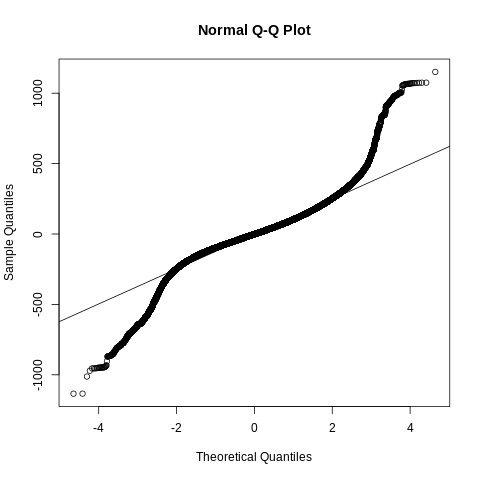

In [ ]:
%%R
qqnorm(residuals(fit.1a))
abline(0,sd(residuals(fit.1a)))

In [ ]:
%%R
confint(fit.1a)

                             2.5 %      97.5 %    Estimate
(Intercept)          701.690666921 753.2289705 727.4598187
fDimCat3               9.588809504  14.0359579  11.8123837
fDimCat4              -8.207911537  -3.6911322  -5.9495219
fDimCat5             -39.685851137 -34.4814031 -37.0836271
fDimCat6             -47.580406177 -41.0278190 -44.3041126
fLactationNumberCat2  28.794818430  38.4735358  33.6341771
fLactationNumberCat3  52.727041772  70.9064906  61.8167662
fLactationNumberCat4  59.577749902  86.0513919  72.8145709
fLactationNumberCat5  57.156705814  92.2018117  74.6792588
fLactationNumberCat6  47.304419146  91.3437482  69.3240837
fLactationNumberCat7  64.042555924 117.0155964  90.5290761
fLactationNumberCat8  52.976620443 115.7964428  84.3865316
fThiMeanCat0          15.617099673  27.6678969  21.6424983
fThiMeanCat2           0.004693768   3.5794510   1.7920724
fThiMeanCat3           4.466242765   8.5317984   6.4990206
fThiMeanCat4           8.255367961  13.0067691  10.63106

In [ ]:
%%R
rm(fit.1a)
gc()

           used  (Mb) gc trigger   (Mb)  max used  (Mb)
Ncells  2359290 126.0    5360834  286.3   4137112 221.0
Vcells 83424995 636.5  151132107 1153.1 126319069 963.8


In [ ]:
%%R
##CMS 
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071691  8072147 -4035805  8071611   661899 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.409e+04 184.6334       
              Day         5.896e-02   0.2428 -0.73 
 Residual                 1.134e+04 106.4859       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          772.9811     9.8896   78.16  < 2e-16 ***
fDimCat3              -0.2423     0.6181   -0.39 0.695035    
fDimCat4             -26.4336     0.6160  -42.91  < 2e-16 ***
fDimCat5             -52.6959     0.6896  -76.42  < 2e-16 ***
fDimCat6             -67

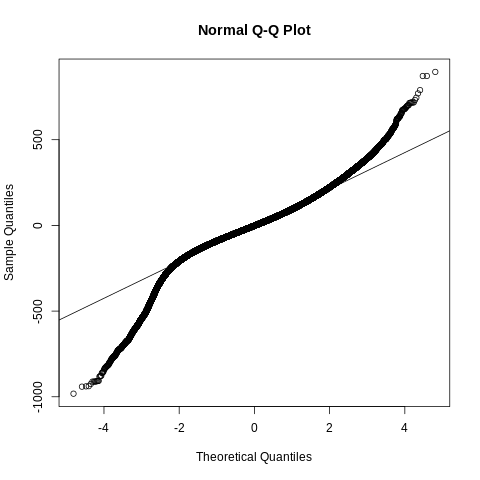

In [ ]:
%%R
qqnorm(residuals(fit.1b))
abline(0,sd(residuals(fit.1b)))

In [ ]:
%%R
confint(fit.1b)

                           2.5 %      97.5 %    Estimate
(Intercept)          753.5978722 792.3644243 772.9811482
fDimCat3              -1.4537154   0.9691035  -0.2423060
fDimCat4             -27.6409352 -25.2263272 -26.4336312
fDimCat5             -54.0474287 -51.3443958 -52.6959122
fDimCat6             -69.0462146 -65.7397278 -67.3929712
fLactationNumberCat2   6.4694163  11.1714022   8.8204093
fLactationNumberCat3  27.6889032  36.2986264  31.9937648
fLactationNumberCat4  50.7468267  63.3601584  57.0534926
fLactationNumberCat5  61.3052798  78.1155016  69.7103907
fLactationNumberCat6  83.9607207 105.6088115  94.7847661
fLactationNumberCat7  82.1309293 109.2606205  95.6957749
fLactationNumberCat8 111.4296674 145.0172999 128.2234836
fThiMeanCat0           2.4617215   7.1580901   4.8099058
fThiMeanCat2           1.8107918   3.7823240   2.7965579
fThiMeanCat3           5.0558810   7.3865386   6.2212098
fThiMeanCat4          19.1248982  21.7242661  20.4245822
fThiMeanCat5          30.743366

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763621  147.6    6371953  340.3   5763827  307.9
Vcells 205647779 1569.0  378167675 2885.2 326644246 2492.1


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960943.3  961303.5 -480432.7  960865.3     75732 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.313e+04 152.0730       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.681e+04 129.6361       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          680.2308     8.8329   77.01  < 2e-16 ***
fLactationNumberCat2 -26.4011     3.2123   -8.22  < 2e-16 ***
fLactationNumberCat3 -24.6016     4.2928   -5.73 9.99e-09 ***
fLactationNumberCat4 -18.9055     5.1588   -3.66 0.000248 ***
fLactationNumberCat5 -17.

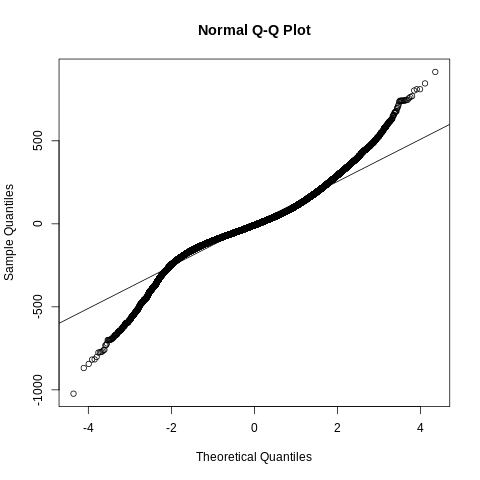

In [ ]:
%%R
qqnorm(residuals(fit.1c))
abline(0,sd(residuals(fit.1c)))

In [ ]:
%%R
confint(fit.1c)

                           2.5 %      97.5 %    Estimate
(Intercept)          662.9186138 697.5429792 680.2307965
fLactationNumberCat2 -32.6971156 -20.1050985 -26.4011070
fLactationNumberCat3 -33.0152741 -16.1879737 -24.6016239
fLactationNumberCat4 -29.0165782  -8.7943521 -18.9054652
fLactationNumberCat5 -29.1513706  -5.3747614 -17.2630660
fLactationNumberCat6 -35.5007364  -6.5689994 -21.0348679
fLactationNumberCat7 -69.6536215 -31.5527905 -50.6032060
fLactationNumberCat8 -91.4158230 -38.6640935 -65.0399583
fThiMeanCat0          10.7526560  29.3183326  20.0354943
fThiMeanCat2           0.9059418   8.3836624   4.6448021
fThiMeanCat3           1.8053664  10.4168946   6.1111305
fThiMeanCat4           1.0050229  10.5841311   5.7945770
fThiMeanCat5           5.5684281  18.8015456  12.1849869
fThiMeanCat6          34.1493463  53.6913872  43.9203668
fYear2018            -21.2648187  -9.9364175 -15.6006181
fYear2019            -18.8119222   0.3190852  -9.2464185
fYear2020            -30.926173

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177608  116.3    6371953  340.3   5763827  307.9
Vcells 177468454 1354.0  378167675 2885.2 326644246 2492.1


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709813  3710216 -1854868  3709737   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.328e+04 251.546        
              Day         1.437e-01   0.379  -0.78 
 Residual                 1.550e+04 124.480        
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          731.97881   13.19662   55.47  < 2e-16 ***
fDimCat3              11.83479    1.13541   10.42  < 2e-16 ***
fDimCat4              -5.88943    1.15334   -5.11 3.28e-07 ***
fDimCat5             -36.98571    1.32924  -27.82  < 2e-16 ***
fDimCat6             

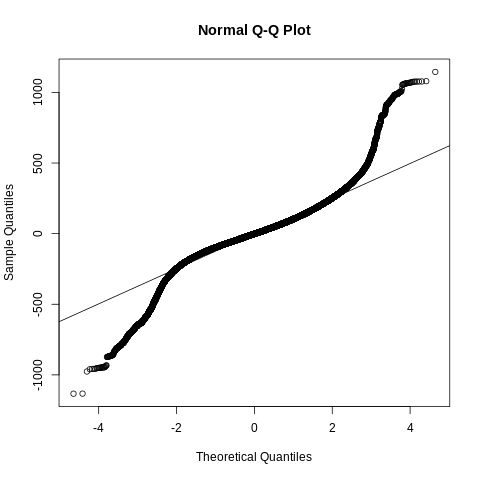

In [ ]:
%%R
qqnorm(residuals(fit.2a))
abline(0,sd(residuals(fit.2a)))

In [ ]:
%%R
confint(fit.2a)

                           2.5 %      97.5 %     Estimate
(Intercept)          706.1139132 757.8436980 731.97880559
fDimCat3               9.6094277  14.0601560  11.83479183
fDimCat4              -8.1499465  -3.6289185  -5.88943253
fDimCat5             -39.5909694 -34.3804448 -36.98570709
fDimCat6             -47.3112941 -40.7497848 -44.03053946
fLactationNumberCat2  29.3435928  39.0369545  34.19027363
fLactationNumberCat3  53.9240021  72.1319771  63.02798961
fLactationNumberCat4  61.4034928  87.9193989  74.66144586
fLactationNumberCat5  59.7931315  94.8948236  77.34397758
fLactationNumberCat6  50.8522203  94.9619491  72.90708471
fLactationNumberCat7  68.5783807 121.6337407  95.10606068
fLactationNumberCat8  58.3284379 121.2406861  89.78456201
fThiMaxCat0           18.3581246  64.9285080  41.64331627
fThiMaxCat2           -7.9110941  -4.3422435  -6.12666879
fThiMaxCat3           -5.7386441  -1.6314576  -3.68505086
fThiMaxCat4           -1.8297416   2.5424766   0.35636750
fThiMaxCat5   

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2398148  128.1    6371953  340.3   5763827  307.9
Vcells 187480554 1430.4  378167675 2885.2 326644246 2492.1


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071913  8072370 -4035917  8071833   661899 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.413e+04 184.7345       
              Day         5.899e-02   0.2429 -0.73 
 Residual                 1.134e+04 106.5036       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          774.7195     9.8975   78.27  < 2e-16 ***
fDimCat3              -0.2538     0.6182   -0.41 0.681379    
fDimCat4             -26.4202     0.6161  -42.88  < 2e-16 ***
fDimCat5             -52.7059     0.6898  -76.40  < 2e-16 ***
fDimCat6             -67.

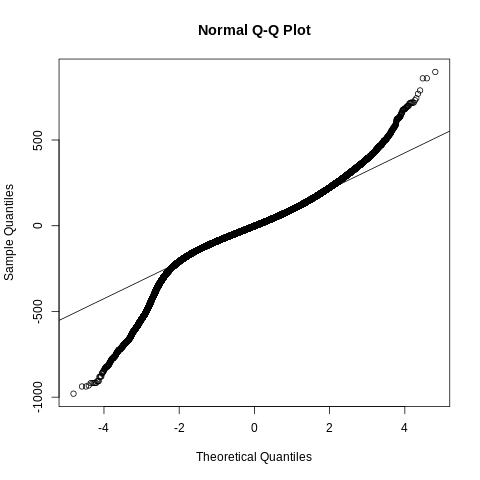

In [ ]:
%%R
qqnorm(residuals(fit.2b))
abline(0,sd(residuals(fit.2b)))

In [ ]:
%%R
confint(fit.2b)

                           2.5 %      97.5 %    Estimate
(Intercept)          755.3206724 794.1183271 774.7194997
fDimCat3              -1.4654523   0.9578147  -0.2538188
fDimCat4             -27.6278243 -25.2126121 -26.4202182
fDimCat5             -54.0579773 -51.3538662 -52.7059217
fDimCat6             -69.0630073 -65.7546841 -67.4088457
fLactationNumberCat2   6.3980631  11.1028377   8.7504504
fLactationNumberCat3  27.6833673  36.2989568  31.9911621
fLactationNumberCat4  50.8683667  63.4909325  57.1796496
fLactationNumberCat5  61.7238100  78.5467614  70.1352857
fLactationNumberCat6  84.6384459 106.3032376  95.4708417
fLactationNumberCat7  83.0519816 110.2022866  96.6271341
fLactationNumberCat8 112.5686745 146.1797307 129.3742026
fThiMaxCat0          -17.4445764  -5.0515846 -11.2480805
fThiMaxCat2           -3.8389495  -1.7889475  -2.8139485
fThiMaxCat3           -1.6252999   0.7412052  -0.4420474
fThiMaxCat4           -3.1644478  -0.6713743  -1.9179110
fThiMaxCat5            7.125952

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763644  147.6    6371953  340.3   5763827  307.9
Vcells 205647833 1569.0  395124671 3014.6 395124671 3014.6


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 961026.3  961386.5 -480474.1  960948.3     75732 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.313e+04 152.0966       
              Day         4.915e-02   0.2217 -0.78 
 Residual                 1.682e+04 129.7109       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          682.8619     8.8209   77.41  < 2e-16 ***
fLactationNumberCat2 -26.4337     3.2131   -8.23  < 2e-16 ***
fLactationNumberCat3 -24.5743     4.2938   -5.72 1.04e-08 ***
fLactationNumberCat4 -18.9141     5.1600   -3.67 0.000247 ***
fLactationNumberCat5 -17.4

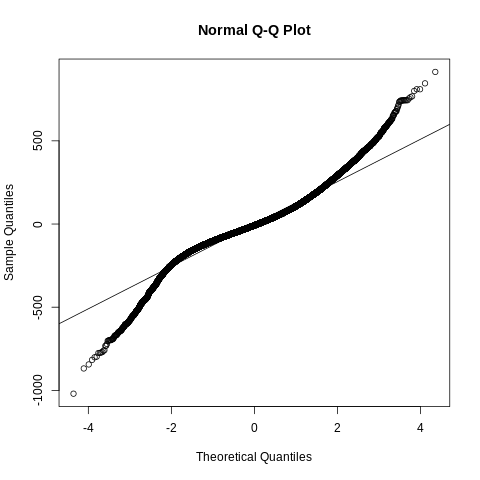

In [ ]:
%%R
qqnorm(residuals(fit.2c))
abline(0,sd(residuals(fit.2c)))

In [ ]:
%%R
confint(fit.2c)

                           2.5 %      97.5 %    Estimate
(Intercept)          665.5733343 700.1505165 682.8619254
fLactationNumberCat2 -32.7313058 -20.1360282 -26.4336670
fLactationNumberCat3 -32.9899435 -16.1587337 -24.5743386
fLactationNumberCat4 -29.0275512  -8.8007327 -18.9141419
fLactationNumberCat5 -29.3748478  -5.5947716 -17.4848097
fLactationNumberCat6 -35.9059640  -6.9738495 -21.4399067
fLactationNumberCat7 -69.5095380 -31.4074031 -50.4584706
fLactationNumberCat8 -90.3636053 -37.6148459 -63.9892256
fThiMaxCat0          -17.8806594  32.7972081   7.4582743
fThiMaxCat2           -7.5596353   0.4923003  -3.5336675
fThiMaxCat3           -6.2520803   2.9433251  -1.6543776
fThiMaxCat4           -6.7527179   3.0276248  -1.8625466
fThiMaxCat5           -5.2229647   5.0055130  -0.1087258
fThiMaxCat6           -0.7208256  10.4287049   4.8539396
fYear2018            -21.5728011 -10.2408423 -15.9068217
fYear2019            -18.8830769   0.2375318  -9.3227725
fYear2020            -31.263432

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177631  116.3    6371953  340.3   5763827  307.9
Vcells 177468508 1354.0  395124671 3014.6 395124671 3014.6


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709838  3710240 -1854881  3709762   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.314e+04 251.2720       
              Day         1.437e-01   0.3791 -0.78 
 Residual                 1.550e+04 124.4856       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          731.3682    13.1865   55.46  < 2e-16 ***
fDimCat3              11.8265     1.1355   10.42  < 2e-16 ***
fDimCat4              -5.8326     1.1533   -5.06 4.25e-07 ***
fDimCat5             -36.9048     1.3291  -27.77  < 2e-16 ***
fDimCat6             -44.0

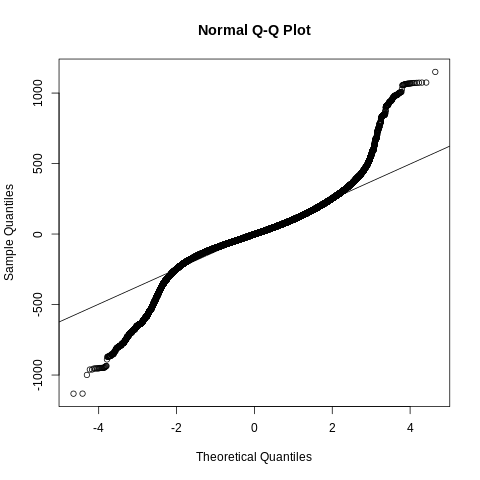

In [ ]:
%%R
qqnorm(residuals(fit.3a))
abline(0,sd(residuals(fit.3a)))

In [ ]:
%%R
confint(fit.3a)

                           2.5 %      97.5 %    Estimate
(Intercept)          705.5231747 757.2132572 731.3682159
fDimCat3               9.6010702  14.0520199  11.8265450
fDimCat4              -8.0930714  -3.5721711  -5.8326213
fDimCat5             -39.5098096 -34.2998793 -36.9048444
fDimCat6             -47.3221966 -40.7619301 -44.0420634
fLactationNumberCat2  28.7860281  38.4800201  33.6330241
fLactationNumberCat3  52.6242122  70.8325312  61.7283717
fLactationNumberCat4  59.7371365  86.2512329  72.9941847
fLactationNumberCat5  57.5123731  92.6104139  75.0613935
fLactationNumberCat6  47.9003505  92.0050560  69.9527032
fLactationNumberCat7  65.0414983 118.0920868  91.5667925
fLactationNumberCat8  54.2316993 117.1403415  85.6860204
fThiMinCat0            8.1567279  12.4792219  10.3179749
fThiMinCat2           -1.7489842   1.4576677  -0.1456583
fThiMinCat3            0.3540542   4.1320161   2.2430351
fThiMinCat4            4.5633029   8.7339549   6.6486289
fThiMinCat5           10.800331

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2398635  128.2    6371953  340.3   5763827  307.9
Vcells 187485861 1430.5  395124671 3014.6 395124671 3014.6


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8073417  8073873 -4036668  8073337   661899 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.417e+04 184.8628       
              Day         5.923e-02   0.2434 -0.73 
 Residual                 1.137e+04 106.6248       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          774.8837     9.8995   78.28  < 2e-16 ***
fDimCat3              -0.3374     0.6189   -0.55  0.58558    
fDimCat4             -26.4605     0.6168  -42.90  < 2e-16 ***
fDimCat5             -52.7493     0.6905  -76.39  < 2e-16 ***
fDimCat6             -67.

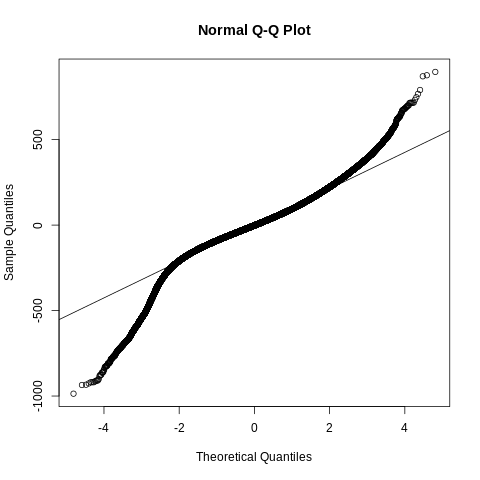

In [ ]:
%%R
qqnorm(residuals(fit.3b))
abline(0,sd(residuals(fit.3b)))

In [ ]:
%%R
confint(fit.3b)

                            2.5 %      97.5 %    Estimate
(Intercept)          755.48105218 794.2863192 774.8836857
fDimCat3              -1.55043190   0.8755374  -0.3374473
fDimCat4             -27.66947471 -25.2516194 -26.4605471
fDimCat5             -54.10277700 -51.3958750 -52.7493260
fDimCat6             -69.07336755 -65.7618447 -67.4176061
fLactationNumberCat2   6.36360694  11.0730391   8.7183230
fLactationNumberCat3  27.67527387  36.2990429  31.9871584
fLactationNumberCat4  50.84334557  63.4769562  57.1601509
fLactationNumberCat5  61.55269602  78.3900297  69.9713628
fLactationNumberCat6  84.41362839 106.0966453  95.2551369
fLactationNumberCat7  82.97657710 110.1498549  96.5632160
fLactationNumberCat8 112.59361166 146.2345439 129.4140778
fThiMinCat0            1.30936706   3.4214877   2.3654274
fThiMinCat2            3.11974640   4.9026805   4.0112134
fThiMinCat3            8.08564327  10.1305774   9.1081103
fThiMinCat4            8.55915258  10.8472236   9.7031881
fThiMinCat5   

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2763538  147.6    6371953  340.3   5763827  307.9
Vcells 205646146 1569.0  395129962 3014.7 395129962 3014.7


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960978.0  961338.2 -480450.0  960900.0     75732 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.314e+04 152.1157       
              Day         4.920e-02   0.2218 -0.78 
 Residual                 1.681e+04 129.6658       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          679.9666     8.8422   76.90  < 2e-16 ***
fLactationNumberCat2 -26.1402     3.2138   -8.13 4.16e-16 ***
fLactationNumberCat3 -24.2684     4.2944   -5.65 1.59e-08 ***
fLactationNumberCat4 -18.7352     5.1609   -3.63 0.000283 ***
fLactationNumberCat5 -17.0

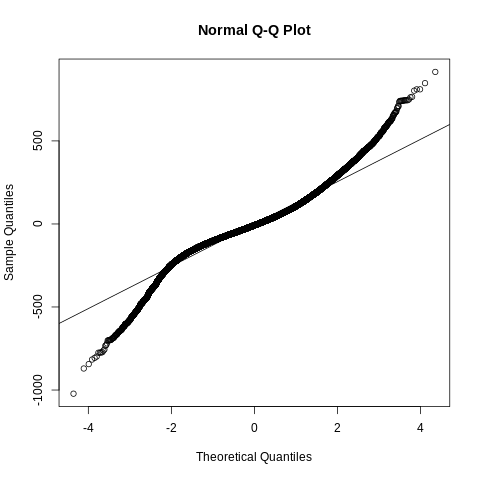

In [ ]:
%%R
qqnorm(residuals(fit.3c))
abline(0,sd(residuals(fit.3c)))

In [ ]:
%%R
confint(fit.3c)

                           2.5 %      97.5 %    Estimate
(Intercept)          662.6361223 697.2970895 679.9666059
fLactationNumberCat2 -32.4391251 -19.8412960 -26.1402105
fLactationNumberCat3 -32.6853527 -15.8515040 -24.2684284
fLactationNumberCat4 -28.8504242  -8.6199477 -18.7351859
fLactationNumberCat5 -28.9803389  -5.1949277 -17.0876333
fLactationNumberCat6 -35.4944713  -6.5547124 -21.0245919
fLactationNumberCat7 -69.5920979 -31.4817003 -50.5368991
fLactationNumberCat8 -90.6108316 -37.8481143 -64.2294730
fThiMinCat0            5.2607068  14.0602509   9.6604788
fThiMinCat2           -0.4516655   6.2558042   2.9020694
fThiMinCat3           -0.3481362   7.1427615   3.3973126
fThiMinCat4           -0.8978094   7.3391208   3.2206557
fThiMinCat5           -1.6075179   9.5346085   3.9635453
fThiMinCat6           22.7624818  41.5990951  32.1807885
fYear2018            -21.0904278  -9.7736860 -15.4320569
fYear2019            -18.7583961   0.3734206  -9.1924877
fYear2020            -30.917353

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2177356  116.3    6371953  340.3   5763827  307.9
Vcells 177465098 1354.0  395129962 3014.7 395129962 3014.7


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710046  3710449 -1854985  3709970   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.347e+04 251.94         
              Day         1.444e-01   0.38   -0.78 
 Residual                 1.551e+04 124.53         
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            735.2273    13.2303   55.57  < 2e-16 ***
fDimCat3                11.8713     1.1359   10.45  < 2e-16 ***
fDimCat4                -5.8425     1.1539   -5.06 4.12e-07 ***
fDimCat5               -36.8866     1.3299  -27.74  < 2e-16 ***
fDimC

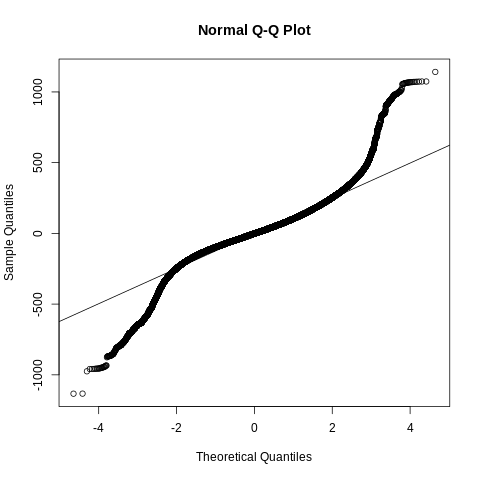

In [ ]:
%%R
qqnorm(residuals(fit.4a))
abline(0,sd(residuals(fit.4a)))

In [ ]:
%%R
confint(fit.4a)

                              2.5 %      97.5 %    Estimate
(Intercept)             709.2964394 761.1581831 735.2273112
fDimCat3                  9.6450060  14.0976454  11.8713257
fDimCat4                 -8.1040331  -3.5809470  -5.8424900
fDimCat5                -39.4931910 -34.2799289 -36.8865599
fDimCat6                -47.1537126 -40.5883165 -43.8710145
fLactationNumberCat2     29.2991894  38.9988260  34.1490077
fLactationNumberCat3     53.8795996  72.1003315  62.9899656
fLactationNumberCat4     61.5337128  88.0688106  74.8012617
fLactationNumberCat5     59.9892902  95.1166320  77.5529611
fLactationNumberCat6     51.1205805  95.2625780  73.1915793
fLactationNumberCat7     68.7792738 121.8727994  95.3260366
fLactationNumberCat8     58.5505383 121.5066348  90.0285866
fThiMean1daybeforeCat0   13.6169982  25.6068016  19.6118999
fThiMean1daybeforeCat2   -2.4261383   1.1585930  -0.6337726
fThiMean1daybeforeCat3   -7.5855406  -3.4710252  -5.5282829
fThiMean1daybeforeCat4    2.4621825   7.

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399156  128.2    6371953  340.3   5763827  307.9
Vcells 187484616 1430.4  395129962 3014.7 395129962 3014.7


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072900  8073356 -4036410  8072820   661804 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.370e+04 183.5676       
              Day         5.873e-02   0.2423 -0.73 
 Residual                 1.138e+04 106.6780       
Number of obs: 661844, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            778.5621     9.8744   78.85  < 2e-16 ***
fDimCat3                -0.2991     0.6192   -0.48 0.629052    
fDimCat4               -26.3719     0.6171  -42.73  < 2e-16 ***
fDimCat5               -52.6064     0.6908  -76.15  < 2e-16 ***
fDim

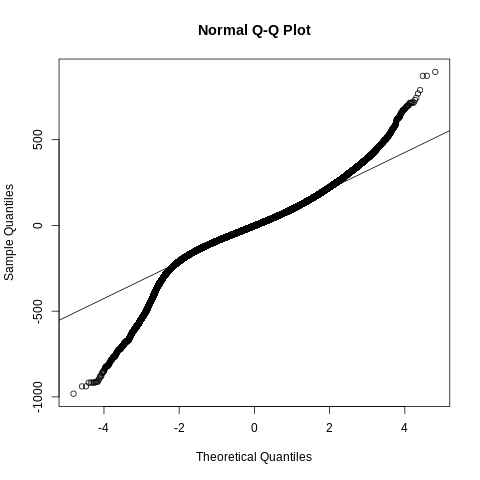

In [ ]:
%%R
qqnorm(residuals(fit.4b))
abline(0,sd(residuals(fit.4b)))

In [ ]:
%%R
confint(fit.4b)

                             2.5 %      97.5 %    Estimate
(Intercept)            759.2085818 797.9155393 778.5620605
fDimCat3                -1.5127886   0.9145387  -0.2991250
fDimCat4               -27.5814212 -25.1623682 -26.3718947
fDimCat5               -53.9604080 -51.2524771 -52.6064425
fDimCat6               -68.8726506 -65.5601629 -67.2164068
fLactationNumberCat2     6.7518255  11.4614648   9.1066452
fLactationNumberCat3    28.3722496  36.9963635  32.6843065
fLactationNumberCat4    51.8980342  64.5332986  58.2156664
fLactationNumberCat5    63.0772157  79.9180191  71.4976174
fLactationNumberCat6    86.3175052 108.0071585  97.1623318
fLactationNumberCat7    85.0549064 112.2386690  98.6467877
fLactationNumberCat8   115.0749521 148.7302370 131.9025945
fThiMean1daybeforeCat0   3.3978175   8.0957988   5.7468082
fThiMean1daybeforeCat2  -2.8715104  -0.8968384  -1.8841744
fThiMean1daybeforeCat3   1.3925928   3.7448554   2.5687241
fThiMean1daybeforeCat4   9.2821747  11.8932549  10.58771

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764552  147.7    6371953  340.3   5763827  307.9
Vcells 205978355 1571.5  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960864.2  961224.4 -480393.1  960786.2     75722 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.314e+04 152.1093       
              Day         4.919e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6789       
Number of obs: 75761, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            681.74668    8.83318   77.18  < 2e-16 ***
fLactationNumberCat2   -26.51170    3.21321   -8.25  < 2e-16 ***
fLactationNumberCat3   -24.59441    4.29382   -5.73 1.02e-08 ***
fLactationNumberCat4   -18.99327    5.15970   -3.68 0.000232 ***


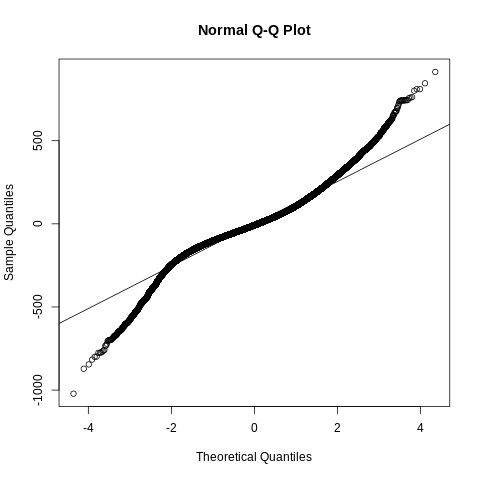

In [ ]:
%%R
qqnorm(residuals(fit.4c))
abline(0,sd(residuals(fit.4c)))

In [ ]:
%%R
confint(fit.4c)

                             2.5 %      97.5 %     Estimate
(Intercept)            664.4339711 699.0593910 681.74668105
fLactationNumberCat2   -32.8094747 -20.2139211 -26.51169787
fLactationNumberCat3   -33.0101429 -16.1786836 -24.59441325
fLactationNumberCat4   -29.1060971  -8.8804509 -18.99327403
fLactationNumberCat5   -29.3222707  -5.5435416 -17.43290614
fLactationNumberCat6   -35.6554470  -6.7233775 -21.18941225
fLactationNumberCat7   -69.2883998 -31.1885642 -50.23848202
fLactationNumberCat8   -90.5035774 -37.7526664 -64.12812190
fThiMean1daybeforeCat0   0.2025970  18.5837721   9.39318455
fThiMean1daybeforeCat2  -4.6207711   2.9016599  -0.85955558
fThiMean1daybeforeCat3  -6.8245029   1.8579358  -2.48328355
fThiMean1daybeforeCat4  -4.7810977   4.8566407   0.03777151
fThiMean1daybeforeCat5  -6.9502920   6.3877776  -0.28125717
fThiMean1daybeforeCat6   1.4966121  21.1891822  11.34289712
fYear2018              -21.0816583  -9.7522779 -15.41696806
fYear2019              -18.8295887   0.2

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178622  116.4    6371953  340.3   5763827  307.9
Vcells 177509955 1354.3  396429561 3024.6 396429561 3024.6


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710208  3710611 -1855066  3710132   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.370e+04 252.3908       
              Day         1.449e-01   0.3806 -0.78 
 Residual                 1.552e+04 124.5624       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             737.2551    13.2624   55.59  < 2e-16 ***
fDimCat3                 11.9132     1.1362   10.48  < 2e-16 ***
fDimCat4                 -5.7780     1.1543   -5.01 5.57e-07 ***
fDimCat5                -36.8027     1.3306  -27.66  < 2e-16 ***

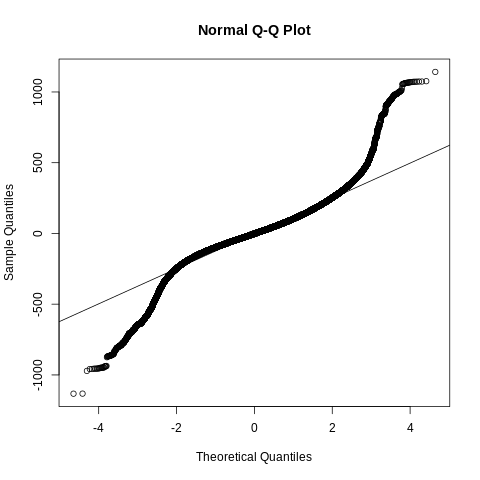

In [ ]:
%%R
qqnorm(residuals(fit.5a))
abline(0,sd(residuals(fit.5a)))

In [ ]:
%%R
confint(fit.5a)

                                2.5 %      97.5 %    Estimate
(Intercept)              711.26135837 763.2489221 737.2551403
fDimCat3                   9.68622218  14.1401271  11.9131746
fDimCat4                  -8.04030651  -3.5156195  -5.7779630
fDimCat5                 -39.41057547 -34.1947425 -36.8026590
fDimCat6                 -47.00681157 -40.4374306 -43.7221211
fLactationNumberCat2      29.44148250  39.1479085  34.2946955
fLactationNumberCat3      54.18178835  72.4159770  63.2988827
fLactationNumberCat4      62.04781084  88.6030488  75.3254298
fLactationNumberCat5      60.77136058  95.9256496  78.3485051
fLactationNumberCat6      52.13476730  96.3102965  74.2225319
fLactationNumberCat7      70.12133960 123.2538745  96.6876070
fLactationNumberCat8      60.15699620 123.1565973  91.6567968
fThiMean2daysbeforeCat0   14.81562921  26.8090486  20.8123389
fThiMean2daysbeforeCat2   -2.94704746   0.6353693  -1.1558391
fThiMean2daysbeforeCat3   -5.41974608  -1.2865230  -3.3531345
fThiMean

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399170  128.2    6371953  340.3   5763827  307.9
Vcells 187484445 1430.4  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072287  8072743 -4036104  8072207   661710 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.371e+04 183.6103       
              Day         5.883e-02   0.2425 -0.73 
 Residual                 1.139e+04 106.7208       
Number of obs: 661750, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             780.0537     9.8823   78.93  < 2e-16 ***
fDimCat3                 -0.2992     0.6195   -0.48 0.629149    
fDimCat4                -26.3438     0.6174  -42.67  < 2e-16 ***
fDimCat5                -52.5833     0.6913  -76.07  < 2e-16 **

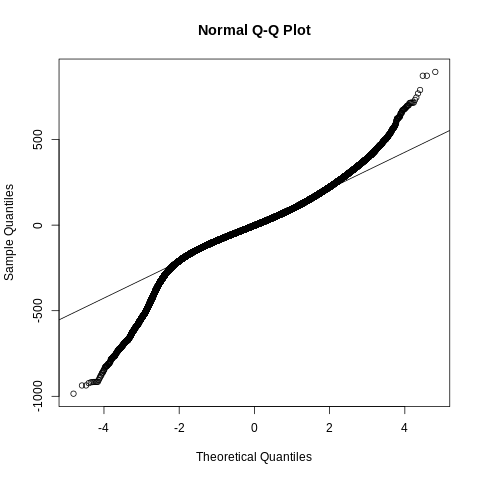

In [ ]:
%%R
qqnorm(residuals(fit.5b))
abline(0,sd(residuals(fit.5b)))

In [ ]:
%%R
confint(fit.5b)

                              2.5 %      97.5 %    Estimate
(Intercept)             760.6847151 799.4226349 780.0536750
fDimCat3                 -1.5134120   0.9150511  -0.2991805
fDimCat4                -27.5539827 -25.1336603 -26.3438215
fDimCat5                -53.9381616 -51.2284624 -52.5833120
fDimCat6                -68.8199706 -65.5047939 -67.1623823
fLactationNumberCat2      6.6695137  11.3832043   9.0263590
fLactationNumberCat3     28.3775547  37.0096018  32.6935782
fLactationNumberCat4     52.0532017  64.7006887  58.3769452
fLactationNumberCat5     63.4881997  80.3458838  71.9170417
fLactationNumberCat6     87.0089295 108.7206734  97.8648015
fLactationNumberCat7     86.1100214 113.3211854  99.7156034
fLactationNumberCat8    116.4698000 150.1569654 133.3133827
fThiMean2daysbeforeCat0  -1.4352561   3.2636932   0.9142186
fThiMean2daysbeforeCat2   3.6539096   5.6215564   4.6377330
fThiMean2daysbeforeCat3   1.4731439   3.8322484   2.6526961
fThiMean2daysbeforeCat4   8.6705127  11.

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764470  147.7    6371953  340.3   5763827  307.9
Vcells 205973637 1571.5  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960743.5  961103.7 -480332.7  960665.5     75712 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.316e+04 152.1810       
              Day         4.924e-02   0.2219 -0.78 
 Residual                 1.682e+04 129.6836       
Number of obs: 75751, groups:  AnimalEartag, 1878

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             681.9389     8.8416   77.13  < 2e-16 ***
fLactationNumberCat2    -26.5513     3.2140   -8.26  < 2e-16 ***
fLactationNumberCat3    -24.6047     4.2953   -5.73 1.01e-08 ***
fLactationNumberCat4    -19.0481     5.1612   -3.69 0.000224 ***


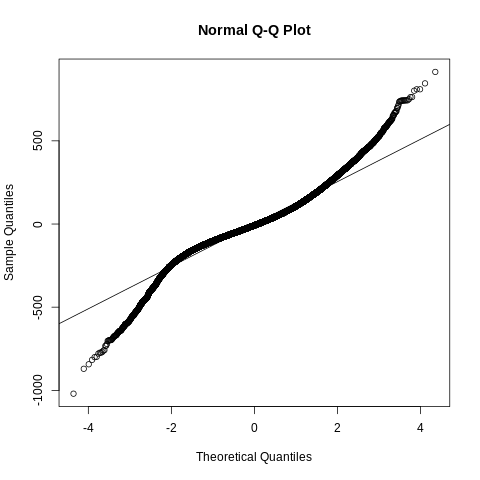

In [ ]:
%%R
qqnorm(residuals(fit.5c))
abline(0,sd(residuals(fit.5c)))

In [ ]:
%%R
confint(fit.5c)

                              2.5 %      97.5 %    Estimate
(Intercept)             664.6095756 699.2681488 681.9388622
fLactationNumberCat2    -32.8506019 -20.2520891 -26.5513455
fLactationNumberCat3    -33.0233714 -16.1860059 -24.6046886
fLactationNumberCat4    -29.1639686  -8.9322587 -19.0481137
fLactationNumberCat5    -29.4759583  -5.6909680 -17.5834632
fLactationNumberCat6    -35.9009886  -6.9623655 -21.4316770
fLactationNumberCat7    -69.3229500 -31.2153739 -50.2691619
fLactationNumberCat8    -90.1198408 -37.3580086 -63.7389247
fThiMean2daysbeforeCat0  -3.7481013  14.4698920   5.3608954
fThiMean2daysbeforeCat2  -4.2158742   3.2997435  -0.4580654
fThiMean2daysbeforeCat3  -3.3224663   5.3852343   1.0313840
fThiMean2daysbeforeCat4  -0.9854101   8.6795580   3.8470740
fThiMean2daysbeforeCat5  -9.5761752   3.7737388  -2.9012182
fThiMean2daysbeforeCat6  -1.6802699  18.1912282   8.2554791
fYear2018               -21.1713375  -9.8355263 -15.5034319
fYear2019               -18.6943421   0.

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178625  116.4    6371953  340.3   5763827  307.9
Vcells 177509283 1354.3  396429561 3024.6 396429561 3024.6


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709204  3709607 -1854564  3709128   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.313e+04 251.2526       
              Day         1.435e-01   0.3789 -0.78 
 Residual                 1.546e+04 124.3525       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          727.0617    13.1652   55.23  < 2e-16 ***
fDimCat3              11.7843     1.1342   10.39  < 2e-16 ***
fDimCat4              -5.9652     1.1521   -5.18 2.25e-07 ***
fDimCat5             -37.0574     1.3278  -27.91  < 2e-16 ***
fDimCat6             -44.

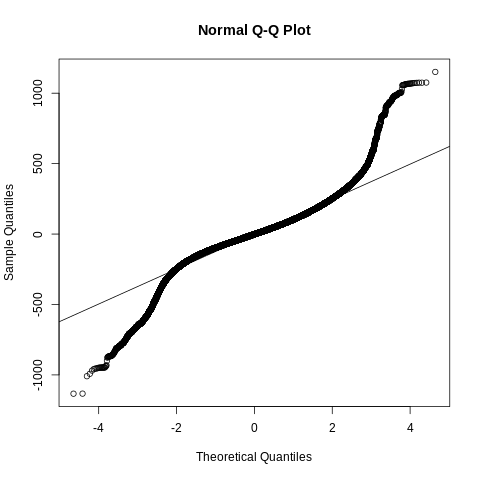

In [ ]:
%%R
qqnorm(residuals(fit.6a))
abline(0,sd(residuals(fit.6a)))

In [ ]:
%%R
confint(fit.6a)

                           2.5 %      97.5 %    Estimate
(Intercept)          701.2584926 752.8649363 727.0617144
fDimCat3               9.5612048  14.0073611  11.7842829
fDimCat4              -8.2233643  -3.7070859  -5.9652251
fDimCat5             -39.6598637 -34.4549428 -37.0574032
fDimCat6             -47.5973269 -41.0432225 -44.3202747
fLactationNumberCat2  29.2561082  38.9392655  34.0976868
fLactationNumberCat3  53.4831299  71.6712004  62.5771652
fLactationNumberCat4  60.3643708  86.8500282  73.6071995
fLactationNumberCat5  57.8625281  92.9227025  75.3926153
fLactationNumberCat6  47.9118797  91.9686855  69.9402826
fLactationNumberCat7  64.2406317 117.2331619  90.7368968
fLactationNumberCat8  52.6291485 115.4696083  84.0493784
fTempMeanCat0         14.8807746  20.3782057  17.6294902
fTempMeanCat2         -0.7996004   2.6337484   0.9170740
fTempMeanCat3          5.4278042   9.5326852   7.4802447
fTempMeanCat4         22.7898458  28.1496533  25.4697496
fTempMeanCat5         54.318057

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399652  128.2    6371953  340.3   5763827  307.9
Vcells 187489739 1430.5  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071880  8072336 -4035900  8071800   661899 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.409e+04 184.6393       
              Day         5.889e-02   0.2427 -0.73 
 Residual                 1.134e+04 106.5013       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          773.2947     9.8890   78.20  < 2e-16 ***
fDimCat3              -0.2296     0.6182   -0.37 0.710322    
fDimCat4             -26.4315     0.6161  -42.90  < 2e-16 ***
fDimCat5             -52.7013     0.6897  -76.42  < 2e-16 ***
fDimCat6             -67

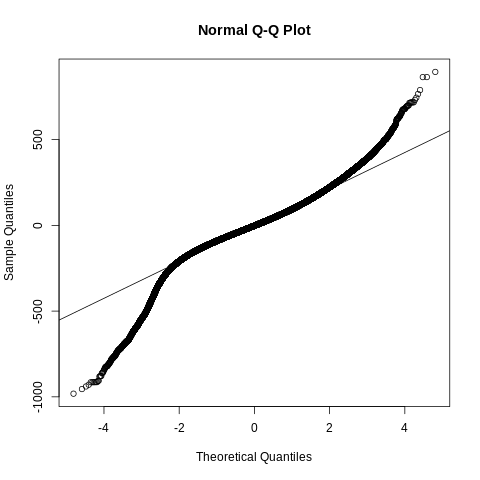

In [ ]:
%%R
qqnorm(residuals(fit.6b))
abline(0,sd(residuals(fit.6b)))

In [ ]:
%%R
confint(fit.6b)

                           2.5 %      97.5 %    Estimate
(Intercept)          753.9126694 792.6766591 773.2946643
fDimCat3              -1.4411969   0.9819898  -0.2296036
fDimCat4             -27.6389879 -25.2240143 -26.4315011
fDimCat5             -54.0530072 -51.3495513 -52.7012793
fDimCat6             -69.0398769 -65.7328899 -67.3863834
fLactationNumberCat2   6.5899769  11.2934145   8.9416957
fLactationNumberCat3  27.8736189  36.4853257  32.1794723
fLactationNumberCat4  50.8961063  63.5112234  57.2036648
fLactationNumberCat5  61.3736942  78.1854744  69.7795843
fLactationNumberCat6  83.9041451 105.5540502  94.7290977
fLactationNumberCat7  81.8808895 109.0129664  95.4469279
fLactationNumberCat8 110.8592847 144.4507806 127.6550326
fTempMeanCat0          2.8107757   5.6959692   4.2533724
fTempMeanCat2          0.4939753   2.3565198   1.4252476
fTempMeanCat3          8.0819339  10.3725709   9.2272524
fTempMeanCat4         25.4387396  28.3227603  26.8807500
fTempMeanCat5         46.246629

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764685  147.7    6371953  340.3   5763827  307.9
Vcells 205651588 1569.0  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960942.1  961302.3 -480432.1  960864.1     75732 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.313e+04 152.0962       
              Day         4.920e-02   0.2218 -0.78 
 Residual                 1.681e+04 129.6343       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           679.036      8.848   76.74  < 2e-16 ***
fLactationNumberCat2  -26.397      3.213   -8.22  < 2e-16 ***
fLactationNumberCat3  -24.558      4.294   -5.72 1.07e-08 ***
fLactationNumberCat4  -18.918      5.160   -3.67 0.000246 ***
fLactationNumberCat5  -1

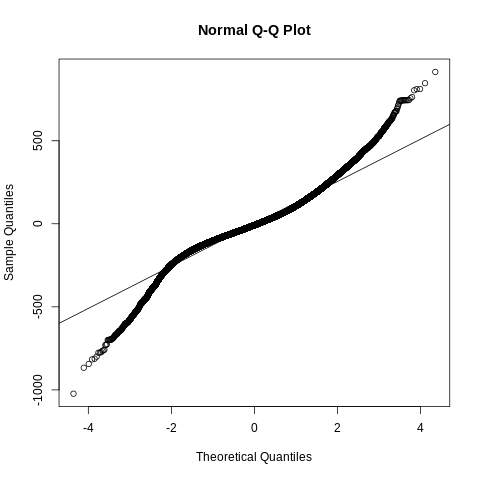

In [ ]:
%%R
qqnorm(residuals(fit.6c))
abline(0,sd(residuals(fit.6c)))

In [ ]:
%%R
confint(fit.6c)

                           2.5 %      97.5 %    Estimate
(Intercept)          661.6933301 696.3777228 679.0355265
fLactationNumberCat2 -32.6946606 -20.0991893 -26.3969250
fLactationNumberCat3 -32.9734761 -16.1417849 -24.5576305
fLactationNumberCat4 -29.0309740  -8.8046778 -18.9178259
fLactationNumberCat5 -29.0860442  -5.3044712 -17.1952577
fLactationNumberCat6 -35.9578619  -7.0224109 -21.4901364
fLactationNumberCat7 -69.8692987 -31.7632262 -50.8162625
fLactationNumberCat8 -90.4990558 -37.7438756 -64.1214657
fTempMeanCat0          9.7599278  21.5170145  15.6384711
fTempMeanCat2         -0.7375003   6.5823670   2.9224333
fTempMeanCat3          1.7635926  10.5014506   6.1325216
fTempMeanCat4          3.6996257  14.6238631   9.1617444
fTempMeanCat5         12.7695868  30.2442818  21.5069343
fTempMeanCat6         46.8343791  79.9552323  63.3948057
fYear2018            -21.5633169 -10.2356076 -15.8994622
fYear2019            -18.7005344   0.4316910  -9.1344217
fYear2020            -30.009710

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178673  116.4    6371953  340.3   5763827  307.9
Vcells 177472268 1354.1  396429561 3024.6 396429561 3024.6


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709448  3709850 -1854686  3709372   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.313e+04 251.2545       
              Day         1.433e-01   0.3785 -0.78 
 Residual                 1.548e+04 124.4041       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          728.8876    13.1622   55.38  < 2e-16 ***
fDimCat3              11.8575     1.1347   10.45  < 2e-16 ***
fDimCat4              -5.8952     1.1525   -5.12 3.14e-07 ***
fDimCat5             -37.0879     1.3281  -27.93  < 2e-16 ***
fDimCat6             -44.

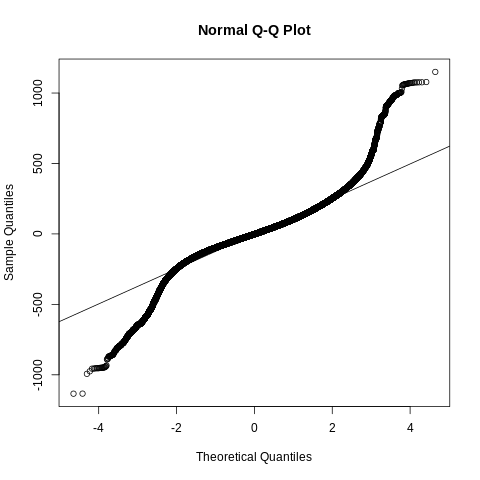

In [ ]:
%%R
qqnorm(residuals(fit.7a))
abline(0,sd(residuals(fit.7a)))

In [ ]:
%%R
confint(fit.7a)

                           2.5 %      97.5 %    Estimate
(Intercept)          703.0901772 754.6849279 728.8875525
fDimCat3               9.6335162  14.0814787  11.8574975
fDimCat4              -8.1540599  -3.6363113  -5.8951856
fDimCat5             -39.6908599 -34.4848456 -37.0878527
fDimCat6             -47.5766779 -41.0217223 -44.2992001
fLactationNumberCat2  29.1380290  38.8214832  33.9797561
fLactationNumberCat3  53.3919998  71.5799634  62.4859816
fLactationNumberCat4  60.2792085  86.7647426  73.5219756
fLactationNumberCat5  58.0518746  93.1122181  75.5820464
fLactationNumberCat6  48.4191656  92.4764871  70.4478264
fLactationNumberCat7  65.5173556 118.5102176  92.0137866
fLactationNumberCat8  54.5755651 117.4166252  85.9960952
fTempMaxCat0          13.2800793  22.4788097  17.8794445
fTempMaxCat2          -6.3725752  -3.1682590  -4.7704171
fTempMaxCat3          -4.8173976  -0.7545513  -2.7859744
fTempMaxCat4           0.9175653   5.3739095   3.1457374
fTempMaxCat5           4.838256

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399672  128.2    6371953  340.3   5763827  307.9
Vcells 187489616 1430.5  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071822  8072278 -4035871  8071742   661899 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.407e+04 184.5755       
              Day         5.885e-02   0.2426 -0.73 
 Residual                 1.134e+04 106.4967       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          774.00581    9.88759   78.28  < 2e-16 ***
fDimCat3              -0.23387    0.61815   -0.38 0.705183    
fDimCat4             -26.43605    0.61605  -42.91  < 2e-16 ***
fDimCat5             -52.69502    0.68965  -76.41  < 2e-16 ***
fDimCat6           

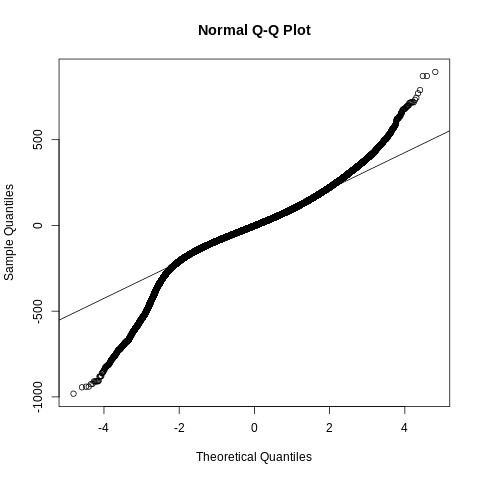

In [ ]:
%%R
qqnorm(residuals(fit.7b))
abline(0,sd(residuals(fit.7b)))

In [ ]:
%%R
confint(fit.7b)

                            2.5 %       97.5 %     Estimate
(Intercept)          754.62649048 793.38513562 774.00581305
fDimCat3              -1.44541841   0.97768480  -0.23386681
fDimCat4             -27.64348374 -25.22861583 -26.43604978
fDimCat5             -54.04670052 -51.34334156 -52.69502104
fDimCat6             -69.04910030 -65.74222622 -67.39566326
fLactationNumberCat2   6.41642993  11.11921371   8.76782182
fLactationNumberCat3  27.64783547  36.25876931  31.95330239
fLactationNumberCat4  50.72016050  63.33489196  57.02752623
fLactationNumberCat5  61.34015151  78.15187193  69.74601172
fLactationNumberCat6  84.03087585 105.68094054  94.85590820
fLactationNumberCat7  82.12362360 109.25591264  95.68976812
fLactationNumberCat8 111.40472336 144.99552163 128.20012249
fTempMaxCat0          -2.40319567   2.22848981  -0.08735293
fTempMaxCat2          -0.62649823   1.23717420   0.30533799
fTempMaxCat3          -0.02943731   2.31817012   1.14436640
fTempMaxCat4           0.97151258   3.46

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765165  147.7    6371953  340.3   5763827  307.9
Vcells 205656862 1569.1  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960992.4  961352.6 -480457.2  960914.4     75732 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.316e+04 152.2001       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6788       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          682.4780     8.8287   77.30  < 2e-16 ***
fLactationNumberCat2 -26.3956     3.2136   -8.21  < 2e-16 ***
fLactationNumberCat3 -24.6130     4.2946   -5.73 9.97e-09 ***
fLactationNumberCat4 -18.8755     5.1608   -3.66 0.000255 ***
fLactationNumberCat5 -17.

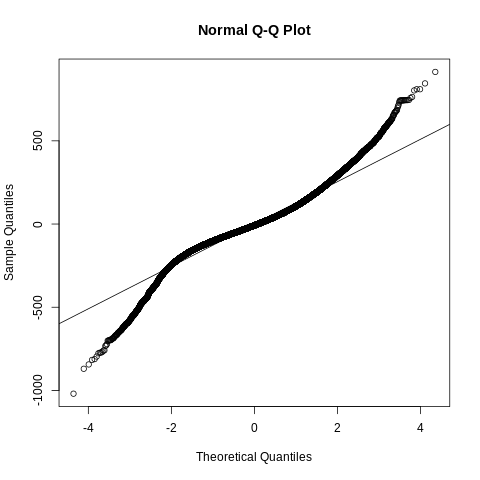

In [ ]:
%%R
qqnorm(residuals(fit.7c))
abline(0,sd(residuals(fit.7c)))

In [ ]:
%%R
confint(fit.7c)

                           2.5 %      97.5 %    Estimate
(Intercept)          665.1740037 699.7820655 682.4780346
fLactationNumberCat2 -32.6941510 -20.0970708 -26.3956109
fLactationNumberCat3 -33.0302214 -16.1957441 -24.6129827
fLactationNumberCat4 -28.9904150  -8.7606161 -18.8755156
fLactationNumberCat5 -29.2046430  -5.4210375 -17.3128402
fLactationNumberCat6 -35.8877646  -6.9526161 -21.4201903
fLactationNumberCat7 -69.6473350 -31.5418313 -50.5945832
fLactationNumberCat8 -90.7408610 -37.9874936 -64.3641773
fTempMaxCat0           3.1171297  20.6594373  11.8882835
fTempMaxCat2          -9.7683299  -2.3369896  -6.0526598
fTempMaxCat3          -7.3328988   1.9374934  -2.6977027
fTempMaxCat4          -8.9501671   0.9381602  -4.0060034
fTempMaxCat5          -8.6052164   2.4044571  -3.1003797
fTempMaxCat6           3.1993664  16.2119579   9.7056621
fYear2018            -21.4008225 -10.0603134 -15.7305680
fYear2019            -18.8023416   0.3275412  -9.2374002
fYear2020            -30.922980

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178568  116.4    6371953  340.3   5763827  307.9
Vcells 177470646 1354.0  396429561 3024.6 396429561 3024.6


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMinAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709804  3710207 -1854864  3709728   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.340e+04 251.7949       
              Day         1.441e-01   0.3797 -0.78 
 Residual                 1.549e+04 124.4781       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          732.1343    13.2130   55.41  < 2e-16 ***
fDimCat3              11.8224     1.1354   10.41  < 2e-16 ***
fDimCat4              -5.8583     1.1533   -5.08 3.78e-07 ***
fDimCat5             -36.8813     1.3293  -27.75  < 2e-16 ***
fDimCat6             -44.

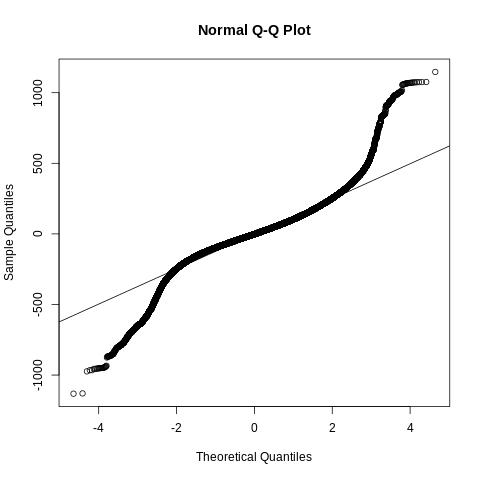

In [ ]:
%%R
qqnorm(residuals(fit.8a))
abline(0,sd(residuals(fit.8a)))

In [ ]:
%%R
confint(fit.8a)

                            2.5 %      97.5 %    Estimate
(Intercept)          706.23732115 758.0313361 732.1343286
fDimCat3               9.59699148  14.0477158  11.8223537
fDimCat4              -8.11881840  -3.5978794  -5.8583489
fDimCat5             -39.48662145 -34.2760378 -36.8813296
fDimCat6             -47.29600760 -40.7342990 -44.0151533
fLactationNumberCat2  28.80286308  38.4992144  33.6510387
fLactationNumberCat3  52.58891195  70.8025261  61.6957190
fLactationNumberCat4  59.74743430  86.2702529  73.0088436
fLactationNumberCat5  57.48208510  92.5918597  75.0369724
fLactationNumberCat6  47.84772248  91.9665876  69.9071550
fLactationNumberCat7  64.92156312 117.9876709  91.4546170
fLactationNumberCat8  53.97356362 116.8981849  85.4358743
fTempMinCat0           8.36614307  11.8394847  10.1028139
fTempMinCat2          -2.81008758  -0.0597105  -1.4348990
fTempMinCat3          -2.33077161   1.0859586  -0.6224065
fTempMinCat4           2.70225837   6.8931969   4.7977276
fTempMinCat5  

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399574  128.2    6371953  340.3   5763827  307.9
Vcells 187487971 1430.5  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8073737  8074193 -4036829  8073657   661899 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.420e+04 184.9332       
              Day         5.929e-02   0.2435 -0.73 
 Residual                 1.137e+04 106.6504       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          775.4066     9.9058   78.28  < 2e-16 ***
fDimCat3              -0.3452     0.6190   -0.56  0.57709    
fDimCat4             -26.4257     0.6170  -42.83  < 2e-16 ***
fDimCat5             -52.7217     0.6909  -76.31  < 2e-16 ***
fDimCat6             -67

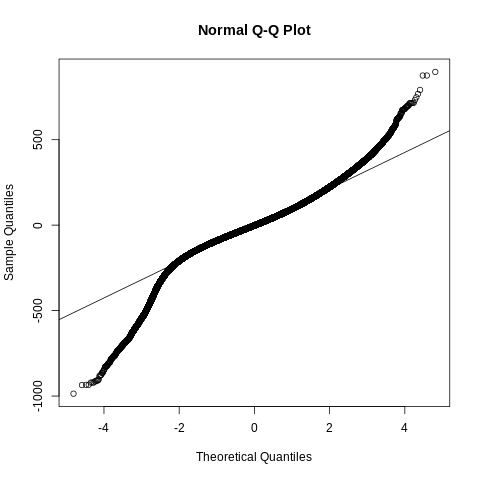

In [ ]:
%%R
qqnorm(residuals(fit.8b))
abline(0,sd(residuals(fit.8b)))

In [ ]:
%%R
confint(fit.8b)

                           2.5 %      97.5 %    Estimate
(Intercept)          755.9914897 794.8216527 775.4065712
fDimCat3              -1.5584918   0.8680864  -0.3452027
fDimCat4             -27.6350020 -25.2163654 -26.4256837
fDimCat5             -54.0757494 -51.3676145 -52.7216819
fDimCat6             -69.0288188 -65.7153115 -67.3720651
fLactationNumberCat2   6.4580077  11.1706047   8.8143062
fLactationNumberCat3  27.8788411  36.5089260  32.1938836
fLactationNumberCat4  51.1715448  63.8149463  57.4932456
fLactationNumberCat5  62.0547903  78.9053216  70.4800559
fLactationNumberCat6  85.0745578 106.7744216  95.9244897
fLactationNumberCat7  83.7564165 110.9499761  97.3531963
fLactationNumberCat8 113.5953399 147.2592872 130.4273135
fTempMinCat0           1.8103636   3.6196156   2.7149896
fTempMinCat2          -0.2281687   1.3848356   0.5783335
fTempMinCat3           3.6838779   5.6142440   4.6490610
fTempMinCat4          10.8673922  13.1627894  12.0150908
fTempMinCat5          22.505518

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765062  147.7    6371953  340.3   5763827  307.9
Vcells 205655212 1569.1  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960976.2  961336.4 -480449.1  960898.2     75732 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.314e+04 152.1211       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.681e+04 129.6639       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          678.28990    8.87330   76.44  < 2e-16 ***
fLactationNumberCat2 -26.29527    3.21329   -8.18 2.76e-16 ***
fLactationNumberCat3 -24.30652    4.29422   -5.66 1.51e-08 ***
fLactationNumberCat4 -18.77677    5.16081   -3.64 0.000274 ***
fLactationNumberCat5

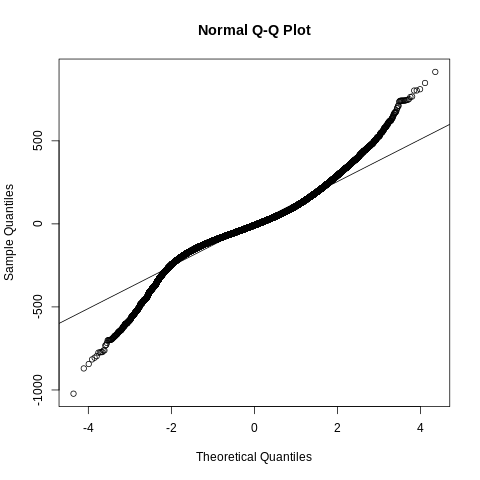

In [ ]:
%%R
qqnorm(residuals(fit.8c))
abline(0,sd(residuals(fit.8c)))

In [ ]:
%%R
confint(fit.8c)

                           2.5 %      97.5 %    Estimate
(Intercept)          660.8985422 695.6812555 678.2898989
fLactationNumberCat2 -32.5931964 -19.9973430 -26.2952697
fLactationNumberCat3 -32.7230425 -15.8899969 -24.3065197
fLactationNumberCat4 -28.8917612  -8.6617692 -18.7767652
fLactationNumberCat5 -29.3167369  -5.5323687 -17.4245528
fLactationNumberCat6 -35.8416215  -6.9016491 -21.3716353
fLactationNumberCat7 -69.4256987 -31.3133133 -50.3695060
fLactationNumberCat8 -90.3105064 -37.5452702 -63.9278883
fTempMinCat0           6.3741849  13.6996676  10.0369263
fTempMinCat2          -2.0827258   4.0988660   1.0080701
fTempMinCat3           0.8267864   8.3428965   4.5848414
fTempMinCat4           1.2391192   9.9650931   5.6021062
fTempMinCat5           2.2371509  14.8336434   8.5353972
fTempMinCat6          26.4749506  53.7594260  40.1171883
fYear2018            -21.1366375  -9.8153458 -15.4759916
fYear2019            -18.6422682   0.4951664  -9.0735509
fYear2020            -30.588608

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179047  116.4    6371953  340.3   5763827  307.9
Vcells 177475879 1354.1  396429561 3024.6 396429561 3024.6


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709941  3710344 -1854933  3709865   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.350e+04 251.9913       
              Day         1.445e-01   0.3801 -0.78 
 Residual                 1.550e+04 124.5066       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             748.9735    13.2862   56.37  < 2e-16 ***
fDimCat3                 11.9028     1.1357   10.48  < 2e-16 ***
fDimCat4                 -5.7884     1.1537   -5.02 5.25e-07 ***
fDimCat5                -36.8103     1.3299  -27.68  < 2e-16 ***

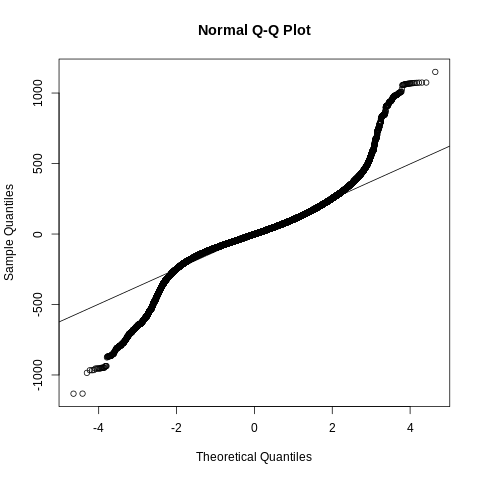

In [ ]:
%%R
qqnorm(residuals(fit.9a))
abline(0,sd(residuals(fit.9a)))

In [ ]:
%%R
confint(fit.9a)

                               2.5 %      97.5 %    Estimate
(Intercept)              722.9330217 775.0139193 748.9734705
fDimCat3                   9.6769631  14.1287164  11.9028398
fDimCat4                  -8.0496459  -3.5271255  -5.7883857
fDimCat5                 -39.4169738 -34.2037143 -36.8103441
fDimCat6                 -47.1129252 -40.5471298 -43.8300275
fLactationNumberCat2      29.7974933  39.4996303  34.6485618
fLactationNumberCat3      54.6408692  72.8659290  63.7533991
fLactationNumberCat4      62.2576867  88.7980298  75.5278582
fLactationNumberCat5      60.5746473  95.7078655  78.1412564
fLactationNumberCat6      51.4129042  95.5611367  73.4870204
fLactationNumberCat7      68.7859172 121.8861533  95.3360352
fLactationNumberCat8      58.0341519 120.9972987  89.5157253
fTempMean1daybeforeCat1  -17.3997676 -11.9083910 -14.6540793
fTempMean1daybeforeCat2  -17.8040539 -11.3231600 -14.5636069
fTempMean1daybeforeCat3  -18.6284824 -11.7720776 -15.2002800
fTempMean1daybeforeCat4 

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400051  128.2    6371953  340.3   5763827  307.9
Vcells 187493246 1430.5  396429561 3024.6 396429561 3024.6


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072651  8073107 -4036286  8072571   661804 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.366e+04 183.4558       
              Day         5.862e-02   0.2421 -0.73 
 Residual                 1.138e+04 106.6580       
Number of obs: 661844, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             783.6131     9.8893   79.24  < 2e-16 ***
fDimCat3                 -0.2717     0.6191   -0.44 0.660741    
fDimCat4                -26.3462     0.6170  -42.70  < 2e-16 ***
fDimCat5                -52.5763     0.6908  -76.11  < 2e-16 **

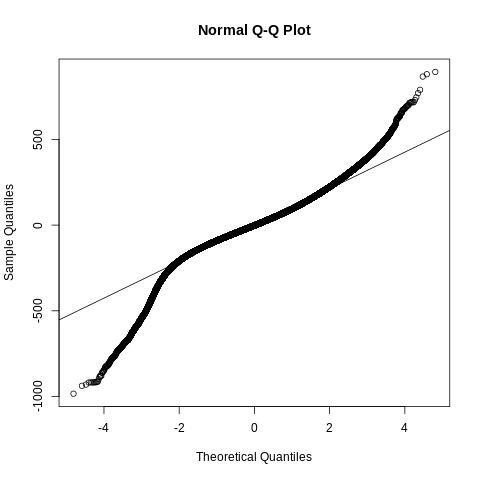

In [ ]:
%%R
qqnorm(residuals(fit.9b))
abline(0,sd(residuals(fit.9b)))

In [ ]:
%%R
confint(fit.9b)

                              2.5 %      97.5 %    Estimate
(Intercept)             764.2304472 802.9956746 783.6130609
fDimCat3                 -1.4851773   0.9417265  -0.2717254
fDimCat4                -27.5555709 -25.1368748 -26.3462228
fDimCat5                -53.9301880 -51.2224755 -52.5763317
fDimCat6                -68.8154598 -65.5029609 -67.1592103
fLactationNumberCat2      6.9380062  11.6485133   9.2932597
fLactationNumberCat3     28.6644060  37.2898649  32.9771354
fLactationNumberCat4     52.1768747  64.8133232  58.4950990
fLactationNumberCat5     63.2395318  80.0813300  71.6604309
fLactationNumberCat6     86.3395665 108.0302861  97.1849263
fLactationNumberCat7     84.9470866 112.1318899  98.5394883
fLactationNumberCat8    114.6733446 148.3297376 131.5015411
fTempMean1daybeforeCat1  -6.2498808  -3.3644404  -4.8071606
fTempMean1daybeforeCat2  -4.6999316  -1.2683587  -2.9841451
fTempMean1daybeforeCat3  -0.5301779   3.1520251   1.3109236
fTempMean1daybeforeCat4  12.7326451  16.

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2764852  147.7    6371953  340.3   5763827  307.9
Vcells 205980151 1571.6  396438190 3024.6 396438190 3024.6


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960853.3  961213.5 -480387.7  960775.3     75722 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.316e+04 152.1697       
              Day         4.922e-02   0.2219 -0.78 
 Residual                 1.681e+04 129.6680       
Number of obs: 75761, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             689.9267     9.1166   75.68  < 2e-16 ***
fLactationNumberCat2    -26.2913     3.2141   -8.18 2.84e-16 ***
fLactationNumberCat3    -24.3712     4.2949   -5.67 1.39e-08 ***
fLactationNumberCat4    -18.7220     5.1608   -3.63 0.000286 ***


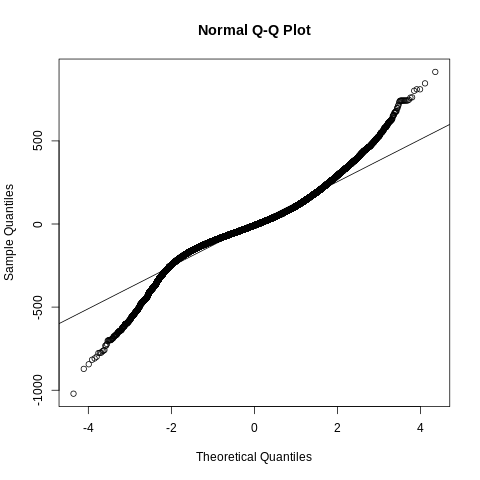

In [ ]:
%%R
qqnorm(residuals(fit.9c))
abline(0,sd(residuals(fit.9c)))

In [ ]:
%%R
confint(fit.9c)

                              2.5 %       97.5 %    Estimate
(Intercept)             672.0585359 707.79493752 689.9267367
fLactationNumberCat2    -32.5907684 -19.99178401 -26.2912762
fLactationNumberCat3    -32.7891382 -15.95326327 -24.3712007
fLactationNumberCat4    -28.8369310  -8.60712806 -18.7220295
fLactationNumberCat5    -29.1681932  -5.38468762 -17.2764404
fLactationNumberCat6    -35.7006874  -6.76496379 -21.2328256
fLactationNumberCat7    -69.3614095 -31.25549209 -50.3084508
fLactationNumberCat8    -90.3550613 -37.59984820 -63.9774548
fTempMean1daybeforeCat1 -15.3695163  -3.66095978  -9.5152380
fTempMean1daybeforeCat2 -16.1676705  -2.35969760  -9.2636841
fTempMean1daybeforeCat3 -16.8833025  -2.26430655  -9.5738045
fTempMean1daybeforeCat4 -16.0442663  -0.03984616  -8.0420563
fTempMean1daybeforeCat5  -6.4257860  14.68980623   4.1320101
fTempMean1daybeforeCat6 -39.3147027  -3.67899729 -21.4968500
fYear2018               -21.1240868  -9.79296556 -15.4585262
fYear2019               

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178922  116.4    6371953  340.3   5763827  307.9
Vcells 177511751 1354.4  396438190 3024.6 396438190 3024.6


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710203  3710605 -1855063  3710127   296569 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.357e+04 252.1272       
              Day         1.447e-01   0.3804 -0.78 
 Residual                 1.552e+04 124.5615       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              736.6599    13.2512   55.59  < 2e-16 ***
fDimCat3                  11.9341     1.1362   10.50  < 2e-16 ***
fDimCat4                  -5.7727     1.1542   -5.00 5.69e-07 ***
fDimCat5                 -36.7927     1.3305  -27.65  < 2e-

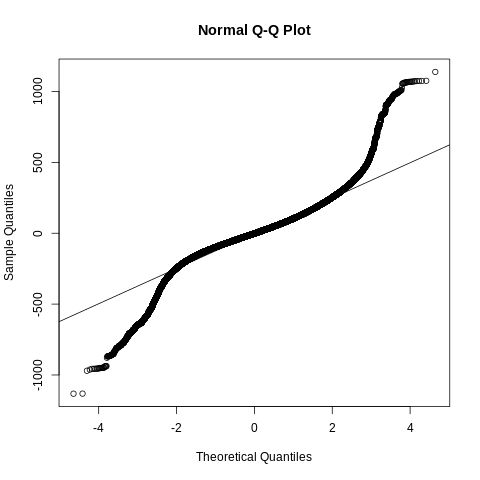

In [ ]:
%%R
qqnorm(residuals(fit.10a))
abline(0,sd(residuals(fit.10a)))

In [ ]:
%%R
confint(fit.10a)

                                2.5 %      97.5 %    Estimate
(Intercept)               710.6879438 762.6317823 736.6598630
fDimCat3                    9.7072866  14.1609581  11.9341223
fDimCat4                   -8.0349288  -3.5104844  -5.7727066
fDimCat5                  -39.4004138 -34.1850203 -36.7927170
fDimCat6                  -47.0281025 -40.4596977 -43.7439001
fLactationNumberCat2       29.6797875  39.3856970  34.5327422
fLactationNumberCat3       54.5045686  72.7366557  63.6206122
fLactationNumberCat4       62.2661210  88.8168020  75.5414615
fLactationNumberCat5       60.8222779  95.9695499  78.3959139
fLactationNumberCat6       51.9387852  96.1051192  74.0219522
fLactationNumberCat7       69.7500560 122.8721312  96.3110936
fLactationNumberCat8       59.3783942 122.3677472  90.8730707
fTempMean2daysbeforeCat0    8.2509133  13.7477269  10.9993201
fTempMean2daysbeforeCat2   -0.6984829   2.7647641   1.0331406
fTempMean2daysbeforeCat3   -3.2298862   0.9331589  -1.1483637
fTempMea

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399939  128.2    6371953  340.3   5763827  307.9
Vcells 187491695 1430.5  396438190 3024.6 396438190 3024.6


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072167  8072624 -4036044  8072087   661710 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.374e+04 183.6794       
              Day         5.880e-02   0.2425 -0.73 
 Residual                 1.139e+04 106.7110       
Number of obs: 661750, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              780.50137    9.89094   78.91  < 2e-16 ***
fDimCat3                  -0.28574    0.61948   -0.46  0.64462    
fDimCat4                 -26.29272    0.61747  -42.58  < 2e-16 ***
fDimCat5                 -52.49985    0.69146  -75.93 

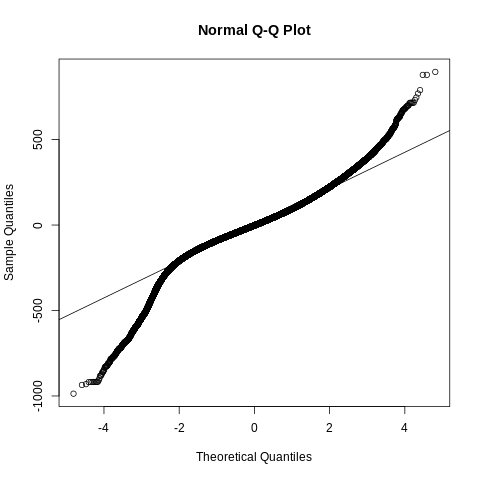

In [ ]:
%%R
qqnorm(residuals(fit.10b))
abline(0,sd(residuals(fit.10b)))

In [ ]:
%%R
confint(fit.10b)

                               2.5 %      97.5 %     Estimate
(Intercept)              761.1154879 799.8872423 780.50136513
fDimCat3                  -1.4998896   0.9284161  -0.28573676
fDimCat4                 -27.5029352 -25.0825056 -26.29272040
fDimCat5                 -53.8550805 -51.1446167 -52.49984860
fDimCat6                 -68.6785190 -65.3615289 -67.02002394
fLactationNumberCat2       7.0262144  11.7437015   9.38495797
fLactationNumberCat3      29.0003515  37.6400034  33.32017747
fLactationNumberCat4      52.8303695  65.4888418  59.15960567
fLactationNumberCat5      64.3266001  81.1988355  72.76271779
fLactationNumberCat6      87.9116445 109.6418695  98.77675700
fLactationNumberCat7      87.0948554 114.3278723 100.71136385
fLactationNumberCat8     117.4281270 151.1399064 134.28401668
fTempMean2daysbeforeCat0   1.8834094   4.7583190   3.32086420
fTempMean2daysbeforeCat2   3.7934832   5.6622524   4.72786782
fTempMean2daysbeforeCat3   4.3124321   6.6346327   5.47353244
fTempMea

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765235  147.7    6371953  340.3   5763827  307.9
Vcells 205980871 1571.6  396438190 3024.6 396438190 3024.6


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960738.1  961098.3 -480330.1  960660.1     75712 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.318e+04 152.252        
              Day         4.927e-02   0.222  -0.78 
 Residual                 1.682e+04 129.677        
Number of obs: 75751, groups:  AnimalEartag, 1878

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              681.23417    8.85691   76.92  < 2e-16 ***
fLactationNumberCat2     -26.41037    3.21495   -8.21  < 2e-16 ***
fLactationNumberCat3     -24.48261    4.29659   -5.70 1.21e-08 ***
fLactationNumberCat4     -18.82782    5.16251   -3.65 0

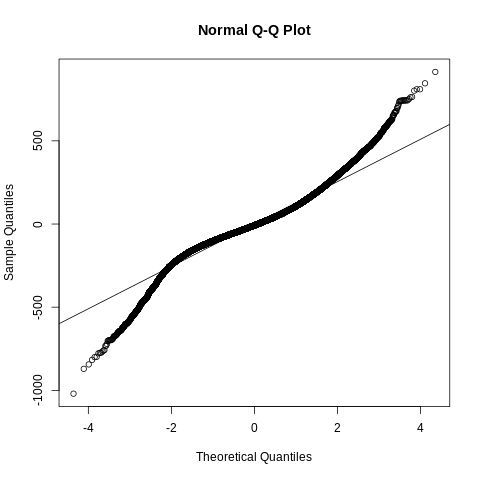

In [ ]:
%%R
qqnorm(residuals(fit.10c))
abline(0,sd(residuals(fit.10c)))

In [ ]:
%%R
confint(fit.10c)

                               2.5 %      97.5 %     Estimate
(Intercept)              663.8749443 698.5934005 681.23417240
fLactationNumberCat2     -32.7115562 -20.1091837 -26.41036995
fLactationNumberCat3     -32.9037661 -16.0614614 -24.48261372
fLactationNumberCat4     -28.9461531  -8.7094904 -18.82782176
fLactationNumberCat5     -29.4169744  -5.6268842 -17.52192932
fLactationNumberCat6     -35.9277389  -6.9851002 -21.45641955
fLactationNumberCat7     -69.4364311 -31.3223973 -50.37941420
fLactationNumberCat8     -90.1389780 -37.3727363 -63.75585717
fTempMean2daysbeforeCat0  -0.2672871  11.4160322   5.57437255
fTempMean2daysbeforeCat2  -3.7660269   3.6084027  -0.07881207
fTempMean2daysbeforeCat3  -2.6472787   6.1804131   1.76656720
fTempMean2daysbeforeCat4  -2.6655190   8.3201647   2.82732284
fTempMean2daysbeforeCat5   0.6038606  18.3110740   9.45746729
fTempMean2daysbeforeCat6 -36.7993505  -2.5210086 -19.66017954
fYear2018                -21.1796093  -9.8400537 -15.50983150
fYear201

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179389  116.4    6371953  340.3   5763827  307.9
Vcells 177516505 1354.4  396438190 3024.6 396438190 3024.6


# Run models Standing grouped in 6 groups per 5

## Create sub datasets

In [ ]:
## load dataset
%%R 
url5 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/df_joined_per5_standing.csv'

dataset_per5 <- read.csv(url5, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per5
dataset$fDimCat <- factor(dataset$DimCat)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per5_standing_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per5_standing_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per5_standing_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per5_standing_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per5_standing_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per5_standing_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1338


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   560


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2821


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1288


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3616


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1879


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5 
  1729 174230  44458  48708  21939   5543 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5 
   111 124732  41320  43075  49717  37652 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


     0      1      2      3      4      5 
 14966 129268  50504  45218  39326  17325 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
  1736 174174  44540  48623  22014   5520 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
  1736 174322  44647  48465  21936   5501 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5 
  9104 130609  63554  72434  18233   2673 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


    0     1     2     3     4     5 
 2935 85040 68152 59777 54225 26478 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5 
31341 81442 85026 74298 23413  1087 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5 
  9093 130662  63546  72420  18225   2661 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
  9042 130764  63800  72140  18211   2650 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5 
  8773 376956 108275 105004  47830  15101 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5 
  1158 267936  90689  93174 115240  93742 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5 
 48331 297222 112089  97876  77183  29238 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
  8771 376749 108398 104900  47933  15093 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
  8768 376761 108314 104892  47925  15090 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5 
 25475 281885 146777 153088  46506   8208 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5 
  8728 185559 136975 130598 128620  71459 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5 
 95610 176802 190447 157892  38043   3145 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5 
 25383 281887 146764 153006  46600   8204 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
 25477 281718 146756 152910  46676   8213 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5 
  925 39777 12685 14090  6423  1871 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5 
  106 27816  9927 11533 14460 11929 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5 
 4843 30672 12837 12243 10875  4301 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5 
  941 39774 12620 14113  6443  1870 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5 
  965 39736 12630 14117  6458  1845 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5 
 2714 29107 16714 20401  5831  1004 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5 
  972 19195 14741 15940 16112  8811 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5 
 9305 18602 21072 20740  5646   406 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5 
 2732 29061 16738 20370  5860  1000 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5 
 2748 29073 16711 20367  5865   987 


## Model THI mean

In [ ]:
%%R
##AMS
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709434  3709826 -1854680  3709360   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.297e+04 250.9318       
              Day         1.432e-01   0.3784 -0.78 
 Residual                 1.548e+04 124.4018       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          728.1459    13.1526   55.36  < 2e-16 ***
fDimCat3              11.8671     1.1347   10.46  < 2e-16 ***
fDimCat4              -5.9327     1.1525   -5.15 2.64e-07 ***
fDimCat5             -37.0489     1.3280  -27.90  < 2e-16 ***
fDimCat6             -44.

In [ ]:
%%R
confint(fit.1a)

                           2.5 %      97.5 %    Estimate
(Intercept)          702.3672881 753.9245910 728.1459396
fDimCat3               9.6431792  14.0910195  11.8670993
fDimCat4              -8.1914414  -3.6738907  -5.9326661
fDimCat5             -39.6516068 -34.4461173 -37.0488621
fDimCat6             -47.5393517 -40.9853703 -44.2623610
fLactationNumberCat2  28.8417223  38.5228625  33.6822924
fLactationNumberCat3  52.7965065  70.9805425  61.8885245
fLactationNumberCat4  59.6875839  86.1679548  72.9277693
fLactationNumberCat5  57.3775049  92.4314206  74.9044628
fLactationNumberCat6  47.6717370  91.7218970  69.6968170
fLactationNumberCat7  64.3873795 117.3733305  90.8803550
fLactationNumberCat8  53.5338397 116.3682129  84.9510263
fThiMeanCat0          15.5950276  27.6480528  21.6215402
fThiMeanCat2           1.0128120   4.5282725   2.7705422
fThiMeanCat3           5.6921914   9.7672902   7.7297408
fThiMeanCat4          16.2121643  21.2147549  18.7134596
fThiMeanCat5          49.998362

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399860  128.2    6371953  340.3   5763827  307.9
Vcells 197019216 1503.2  396438190 3024.6 396438190 3024.6


In [ ]:
%%R
##CMS 
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072192  8072637 -4036057  8072114   661900 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 34103.587 184.6716       
              Day             0.059   0.2429 -0.73 
 Residual                 11347.892 106.5265       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          772.9322     9.8921   78.14  < 2e-16 ***
fDimCat3              -0.2411     0.6183   -0.39 0.696607    
fDimCat4             -26.4159     0.6162  -42.87  < 2e-16 ***
fDimCat5             -52.7143     0.6898  -76.42  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.1b)

                            2.5 %      97.5 %    Estimate
(Intercept)          753.54396580 792.3204284 772.9321971
fDimCat3              -1.45295305   0.9707865  -0.2410833
fDimCat4             -27.62366705 -25.2081513 -26.4159092
fDimCat5             -54.06635448 -51.3623364 -52.7143455
fDimCat6             -69.06546372 -65.7577795 -67.4116216
fLactationNumberCat2   6.48313860  11.1868074   8.8349730
fLactationNumberCat3  27.71209795  36.3248515  32.0184747
fLactationNumberCat4  50.75869833  63.3764108  57.0675545
fLactationNumberCat5  61.31205292  78.1279954  69.7200242
fLactationNumberCat6  83.90252504 105.5579874  94.7302562
fLactationNumberCat7  81.97562333 109.1147843  95.5452038
fLactationNumberCat8 111.21880203 144.8182154 128.0185087
fThiMeanCat0           2.49673490   7.1948916   4.8458132
fThiMeanCat2           1.62327903   3.5274966   2.5753878
fThiMeanCat3           7.92532829  10.2135282   9.0694283
fThiMeanCat4          21.75077862  24.5116429  23.1312108
fThiMeanCat5  

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765337  147.7    6371953  340.3   5763827  307.9
Vcells 214821024 1639.0  403339384 3077.3 403339384 3077.3


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960983.2  961334.2 -480453.6  960907.2     75733 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.316e+04 152.1865       
              Day         4.923e-02   0.2219 -0.78 
 Residual                 1.681e+04 129.6719       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           680.171      8.837   76.97  < 2e-16 ***
fLactationNumberCat2  -26.409      3.214   -8.22  < 2e-16 ***
fLactationNumberCat3  -24.534      4.295   -5.71 1.11e-08 ***
fLactationNumberCat4  -18.884      5.161   -3.66 0.000253 ***
fLactationNumberCat5  -17

In [ ]:
%%R
confint(fit.1c)

                             2.5 %      97.5 %    Estimate
(Intercept)          662.851243988 697.4910382 680.1711411
fLactationNumberCat2 -32.707046090 -20.1100897 -26.4085679
fLactationNumberCat3 -32.951333912 -16.1170494 -24.5341917
fLactationNumberCat4 -28.999061498  -8.7688111 -18.8839363
fLactationNumberCat5 -29.321210318  -5.5361942 -17.4287023
fLactationNumberCat6 -35.929487636  -6.9899425 -21.4597151
fLactationNumberCat7 -69.802232070 -31.6921158 -50.7471739
fLactationNumberCat8 -90.761435213 -38.0000287 -64.3807320
fThiMeanCat0          10.762565301  29.3333857  20.0479755
fThiMeanCat2           0.003224431   7.3995299   3.7013772
fThiMeanCat3           1.122012999   9.7515687   5.4367908
fThiMeanCat4           3.005281442  13.3167933   8.1610374
fThiMeanCat5          16.034099912  31.1726001  23.6033500
fYear2018            -21.262289726  -9.9322206 -15.5972552
fYear2019            -18.590299058   0.5447153  -9.0227919
fYear2020            -30.748355724  -2.7509535 -16.74965

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2178987  116.4    6371953  340.3   5763827  307.9
Vcells 187224423 1428.5  403339384 3077.3 403339384 3077.3


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709777  3710169 -1854851  3709703   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.328e+04 251.5631       
              Day         1.436e-01   0.3789 -0.78 
 Residual                 1.549e+04 124.4734       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          731.53570   13.19348   55.45  < 2e-16 ***
fDimCat3              11.78479    1.13535   10.38  < 2e-16 ***
fDimCat4              -5.93501    1.15327   -5.15 2.66e-07 ***
fDimCat5             -37.04447    1.32912  -27.87  < 2e-16 ***
fDimCat6             

In [ ]:
%%R
confint(fit.2a)

                           2.5 %      97.5 %     Estimate
(Intercept)          705.6769490 757.3944584 731.53570371
fDimCat3               9.5595412  14.0100463  11.78479377
fDimCat4              -8.1953757  -3.6746399  -5.93500783
fDimCat5             -39.6495105 -34.4394392 -37.04447483
fDimCat6             -47.3769676 -40.8161610 -44.09656429
fLactationNumberCat2  29.2934854  38.9857547  34.13962006
fLactationNumberCat3  53.8655160  72.0713628  62.96843941
fLactationNumberCat4  61.3191645  87.8316550  74.57540975
fLactationNumberCat5  59.7118889  94.8087664  77.26032763
fLactationNumberCat6  50.8566950  94.9600433  72.90836916
fLactationNumberCat7  68.5922612 121.6396465  95.11595387
fLactationNumberCat8  58.4317520 121.3346821  89.88321702
fThiMaxCat0           18.3086049  64.8763350  41.59246995
fThiMaxCat2           -7.6711683  -4.3268198  -5.99899405
fThiMaxCat3           -5.6488162  -1.5697140  -3.60926512
fThiMaxCat4           -1.2152134   3.1751763   0.97998147
fThiMaxCat5   

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399982  128.2    6371953  340.3   5763827  307.9
Vcells 197020845 1503.2  403339384 3077.3 403339384 3077.3


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072480  8072925 -4036201  8072402   661900 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.415e+04 184.803        
              Day         5.903e-02   0.243  -0.73 
 Residual                 1.135e+04 106.549        
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          775.9302     9.9001   78.38  < 2e-16 ***
fDimCat3              -0.2726     0.6185   -0.44 0.659336    
fDimCat4             -26.4076     0.6164  -42.84  < 2e-16 ***
fDimCat5             -52.6793     0.6902  -76.33  < 2e-16 ***
fDimCat6             -67.

In [ ]:
%%R
confint(fit.2b)

                           2.5 %      97.5 %    Estimate
(Intercept)          756.5262622 795.3341063 775.9301843
fDimCat3              -1.4847957   0.9395234  -0.2726362
fDimCat4             -27.6157152 -25.1994019 -26.4075585
fDimCat5             -54.0320457 -51.3265731 -52.6793094
fDimCat6             -69.0166682 -65.7065335 -67.3616009
fLactationNumberCat2   6.3933834  11.1008540   8.7471187
fLactationNumberCat3  27.7231307  36.3438266  32.0334786
fLactationNumberCat4  51.0405979  63.6707651  57.3556815
fLactationNumberCat5  62.1076106  78.9407098  70.5241602
fLactationNumberCat6  85.2135091 106.8913954  96.0524522
fLactationNumberCat7  83.8089750 110.9755119  97.3922434
fLactationNumberCat8 113.5872743 147.2179347 130.4026045
fThiMaxCat0          -17.4803566  -5.0820024 -11.2811795
fThiMaxCat2           -3.4598675  -1.5059143  -2.4828909
fThiMaxCat3           -2.6117003  -0.2574635  -1.4345819
fThiMaxCat4            0.3932882   2.8535947   1.6234415
fThiMaxCat5           21.025244

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765459  147.7    6371953  340.3   5763827  307.9
Vcells 214822653 1639.0  403341012 3077.3 403341012 3077.3


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 961022.1  961373.1 -480473.1  960946.1     75733 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.314e+04 152.1025       
              Day         4.913e-02   0.2217 -0.78 
 Residual                 1.682e+04 129.7093       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          683.1462     8.8214   77.44  < 2e-16 ***
fLactationNumberCat2 -26.4592     3.2131   -8.23  < 2e-16 ***
fLactationNumberCat3 -24.5403     4.2936   -5.72 1.09e-08 ***
fLactationNumberCat4 -18.8636     5.1598   -3.66 0.000256 ***
fLactationNumberCat5 -17.4

In [ ]:
%%R
confint(fit.2c)

                           2.5 %      97.5 %    Estimate
(Intercept)          665.8566299 700.4358274 683.1462287
fLactationNumberCat2 -32.7568027 -20.1615461 -26.4591744
fLactationNumberCat3 -32.9556664 -16.1249753 -24.5403208
fLactationNumberCat4 -28.9765785  -8.7505875 -18.8635830
fLactationNumberCat5 -29.3360971  -5.5568356 -17.4464663
fLactationNumberCat6 -35.8914465  -6.9607584 -21.4261025
fLactationNumberCat7 -69.3559521 -31.2567842 -50.3063682
fLactationNumberCat8 -90.1997457 -37.4566116 -63.8281787
fThiMaxCat0          -17.8952098  32.7820512   7.4434207
fThiMaxCat2           -9.5840060  -1.8893862  -5.7366961
fThiMaxCat3           -7.8039472   1.4474502  -3.1782485
fThiMaxCat4           -8.5843294   1.1858255  -3.6992520
fThiMaxCat5           -4.3032380   6.2915548   0.9941584
fYear2018            -21.5309432 -10.1982121 -15.8645776
fYear2019            -18.9024845   0.2148259  -9.3438293
fYear2020            -31.1512446  -3.1832798 -17.1672622
fMonth2              -15.997261

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179433  116.4    6371953  340.3   5763827  307.9
Vcells 187229389 1428.5  403341012 3077.3 403341012 3077.3


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709988  3710381 -1854957  3709914   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.337e+04 251.7398       
              Day         1.442e-01   0.3798 -0.78 
 Residual                 1.550e+04 124.5172       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          733.22601   13.21350   55.49  < 2e-16 ***
fDimCat3              11.82093    1.13576   10.41  < 2e-16 ***
fDimCat4              -5.79683    1.15370   -5.02 5.05e-07 ***
fDimCat5             -36.82894    1.32968  -27.70  < 2e-16 ***
fDimCat6             

In [ ]:
%%R
confint(fit.3a)

                           2.5 %      97.5 %     Estimate
(Intercept)          707.3280278 759.1239942 733.22601101
fDimCat3               9.5948789  14.0469836  11.82093124
fDimCat4              -8.0580275  -3.5356227  -5.79682509
fDimCat5             -39.4350654 -34.2228077 -36.82893655
fDimCat6             -47.2175033 -40.6535554 -43.93552933
fLactationNumberCat2  28.7721821  38.4718764  33.62202925
fLactationNumberCat3  52.6535691  70.8739064  61.76373778
fLactationNumberCat4  59.9489115  86.4815232  73.21521738
fLactationNumberCat5  57.8569277  92.9802645  75.41859609
fLactationNumberCat6  48.4620397  92.5985889  70.53031427
fLactationNumberCat7  65.7631077 118.8510514  92.30707957
fLactationNumberCat8  55.2227985 118.1732742  86.69803636
fThiMinCat0            7.8475708  12.1860636  10.01681723
fThiMinCat2           -3.7573489  -0.9348957  -2.34612231
fThiMinCat3           -2.3799513   1.1540660  -0.61294267
fThiMinCat4            2.2215047   6.3069016   4.26420315
fThiMinCat5   

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400434  128.2    6371953  340.3   5763827  307.9
Vcells 197025808 1503.2  403341012 3077.3 403341012 3077.3


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8073918  8074363 -4036920  8073840   661900 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.423e+04 185.0100       
              Day         5.935e-02   0.2436 -0.73 
 Residual                 1.138e+04 106.6650       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          776.0807     9.9106   78.31  < 2e-16 ***
fDimCat3              -0.3448     0.6191   -0.56  0.57754    
fDimCat4             -26.4030     0.6171  -42.78  < 2e-16 ***
fDimCat5             -52.7013     0.6910  -76.27  < 2e-16 ***
fDimCat6             -67.

In [ ]:
%%R
confint(fit.3b)

                           2.5 %       97.5 %    Estimate
(Intercept)          756.6562577 795.50513106 776.0806944
fDimCat3              -1.5583088   0.86862353  -0.3448426
fDimCat4             -27.6124778 -25.19345639 -26.4029671
fDimCat5             -54.0556170 -51.34693405 -52.7012755
fDimCat6             -69.0002183 -65.68584437 -67.3430313
fLactationNumberCat2   6.5344335  11.24819589   8.8913147
fLactationNumberCat3  28.0247141  36.65738842  32.3410512
fLactationNumberCat4  51.3660727  64.01356838  57.6898205
fLactationNumberCat5  62.3503758  79.20676229  70.7785690
fLactationNumberCat6  85.4233514 107.13125804  96.2773047
fLactationNumberCat7  84.2133338 111.41718953  97.8152616
fLactationNumberCat8 114.1286239 147.80476750 130.9666957
fThiMinCat0            1.4542833   3.57496720   2.5146253
fThiMinCat2            1.5560688   3.19455416   2.3753115
fThiMinCat3            4.2298155   6.19783304   5.2138243
fThiMinCat4           10.2224315  12.44609059  11.3342611
fThiMinCat5   

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765161  147.7    6371953  340.3   5763827  307.9
Vcells 214819383 1639.0  403345974 3077.3 403345974 3077.3


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 961008.7  961359.7 -480466.4  960932.7     75733 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.316e+04 152.1832       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6942       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          680.20712    8.84662   76.89  < 2e-16 ***
fLactationNumberCat2 -26.19547    3.21464   -8.15 3.68e-16 ***
fLactationNumberCat3 -24.19322    4.29555   -5.63 1.78e-08 ***
fLactationNumberCat4 -18.71542    5.16219   -3.63 0.000288 ***
fLactationNumberCat5 

In [ ]:
%%R
confint(fit.3c)

                           2.5 %      97.5 %     Estimate
(Intercept)          662.8680554 697.5461834 680.20711941
fLactationNumberCat2 -32.4960460 -19.8948951 -26.19547052
fLactationNumberCat3 -32.6123382 -15.7741035 -24.19322083
fLactationNumberCat4 -28.8331400  -8.5977085 -18.71542429
fLactationNumberCat5 -29.2510725  -5.4611102 -17.35609132
fLactationNumberCat6 -35.7610418  -6.8174295 -21.28923569
fLactationNumberCat7 -69.4739317 -31.3582977 -50.41611468
fLactationNumberCat8 -90.2089221 -37.4400728 -63.82449747
fThiMinCat0            5.0606962  13.8836232   9.47215974
fThiMinCat2           -4.1640018   2.0312445  -1.06637864
fThiMinCat3           -2.8358620   4.5921829   0.87816047
fThiMinCat4           -1.6722199   6.5716926   2.44973632
fThiMinCat5            2.7644903  13.6044264   8.18445834
fYear2018            -21.1341989  -9.8158472 -15.47502304
fYear2019            -18.6051609   0.5270548  -9.03905307
fYear2020            -30.6469569  -2.6520843 -16.64952058
fMonth2       

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179133  116.4    6371953  340.3   5763827  307.9
Vcells 187226083 1428.5  403345974 3077.3 403345974 3077.3


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710103  3710496 -1855015  3710029   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.352e+04 252.0413       
              Day         1.446e-01   0.3802 -0.78 
 Residual                 1.551e+04 124.5411       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            736.4287    13.2406   55.62  < 2e-16 ***
fDimCat3                11.9218     1.1360   10.49  < 2e-16 ***
fDimCat4                -5.7951     1.1540   -5.02 5.12e-07 ***
fDimCat5               -36.8326     1.3302  -27.69  < 2e-16 ***
fDimC

In [ ]:
%%R
confint(fit.4a)

                              2.5 %      97.5 %    Estimate
(Intercept)             710.4776799 762.3797892 736.4287345
fDimCat3                  9.6953217  14.1482845  11.9218031
fDimCat4                 -8.0569257  -3.5333596  -5.7951427
fDimCat5                -39.4397074 -34.2255819 -36.8326447
fDimCat6                -47.0713889 -40.5046335 -43.7880112
fLactationNumberCat2     29.4656737  39.1678786  34.3167761
fLactationNumberCat3     54.1467838  72.3725847  63.2596843
fLactationNumberCat4     61.8898190  88.4324682  75.1611436
fLactationNumberCat5     60.4587762  95.5960213  78.0273988
fLactationNumberCat6     51.6745013  95.8286613  73.7515813
fLactationNumberCat7     69.4316541 122.5393296  95.9854919
fLactationNumberCat8     59.2983311 122.2697555  90.7840433
fThiMean1daybeforeCat0   13.5957201  25.5867292  19.5912246
fThiMean1daybeforeCat2   -1.5098940   2.0166750   0.2533905
fThiMean1daybeforeCat3   -5.3385756  -1.2179395  -3.2782575
fThiMean1daybeforeCat4    5.6518679  10.

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400124  128.2    6371953  340.3   5763827  307.9
Vcells 197022506 1503.2  403345974 3077.3 403345974 3077.3


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8073042  8073487 -4036482  8072964   661805 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.368e+04 183.5323       
              Day         5.876e-02   0.2424 -0.73 
 Residual                 1.138e+04 106.6896       
Number of obs: 661844, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            778.0431     9.8741   78.80  < 2e-16 ***
fDimCat3                -0.2954     0.6193   -0.48  0.63337    
fDimCat4               -26.3671     0.6172  -42.72  < 2e-16 ***
fDimCat5               -52.6350     0.6909  -76.19  < 2e-16 ***
fDim

In [ ]:
%%R
confint(fit.4b)

                             2.5 %      97.5 %    Estimate
(Intercept)            758.6901603 797.3959840 778.0430722
fDimCat3                -1.5091897   0.9183958  -0.2953970
fDimCat4               -27.5767653 -25.1574765 -26.3671209
fDimCat5               -53.9890421 -51.2809001 -52.6349711
fDimCat6               -68.9136301 -65.6009343 -67.2572822
fLactationNumberCat2     6.6876901  11.3974673   9.0425787
fLactationNumberCat3    28.2583086  36.8826275  32.5704681
fLactationNumberCat4    51.7431148  64.3787322  58.0609235
fLactationNumberCat5    62.8928689  79.7342241  71.3135465
fLactationNumberCat6    86.0781036 107.7686725  96.9233881
fLactationNumberCat7    84.7717534 111.9571243  98.3644388
fLactationNumberCat8   114.7091719 148.3666965 131.5379342
fThiMean1daybeforeCat0   3.4405768   8.1390668   5.7898218
fThiMean1daybeforeCat2   0.3288828   2.2340451   1.2814639
fThiMean1daybeforeCat3   4.8073237   7.1135714   5.9604476
fThiMean1daybeforeCat4  14.5003266  17.2736157  15.88697

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765503  147.7    6371953  340.3   5763827  307.9
Vcells 215150900 1641.5  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960869.4  961220.3 -480396.7  960793.4     75723 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.315e+04 152.1426       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6843       
Number of obs: 75761, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             681.765      8.836   77.16  < 2e-16 ***
fLactationNumberCat2    -26.500      3.214   -8.25  < 2e-16 ***
fLactationNumberCat3    -24.545      4.295   -5.72 1.10e-08 ***
fLactationNumberCat4    -18.938      5.161   -3.67 0.000243 ***
fLact

In [ ]:
%%R
confint(fit.4c)

                             2.5 %      97.5 %    Estimate
(Intercept)            664.4474034 699.0830360 681.7652197
fLactationNumberCat2   -32.7990915 -20.2017759 -26.5004337
fLactationNumberCat3   -32.9618503 -16.1273840 -24.5446171
fLactationNumberCat4   -29.0533705  -8.8235616 -18.9384660
fLactationNumberCat5   -29.3736451  -5.5898693 -17.4817572
fLactationNumberCat6   -35.7944062  -6.8567256 -21.3255659
fLactationNumberCat7   -69.3062188 -31.1976932 -50.2519560
fLactationNumberCat8   -90.1125369 -37.3518852 -63.7322110
fThiMean1daybeforeCat0   0.2404093  18.6223704   9.4313898
fThiMean1daybeforeCat2  -5.3670815   2.0478082  -1.6596367
fThiMean1daybeforeCat3  -6.3544964   2.3292111  -2.0126427
fThiMean1daybeforeCat4  -7.2559318   3.1030706  -2.0764306
fThiMean1daybeforeCat5  -5.9019782   9.2837942   1.6909080
fYear2018              -20.8805829  -9.5502517 -15.2154173
fYear2019              -18.7457528   0.3861517  -9.1798006
fYear2020              -31.1420414  -3.1502858 -17.14616

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179577  116.5    6371953  340.3   5763827  307.9
Vcells 187268496 1428.8  404643705 3087.2 404643705 3087.2


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710238  3710630 -1855082  3710164   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.361e+04 252.2131       
              Day         1.448e-01   0.3805 -0.78 
 Residual                 1.552e+04 124.5693       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             737.2595    13.2554   55.62  < 2e-16 ***
fDimCat3                 11.9526     1.1362   10.52  < 2e-16 ***
fDimCat4                 -5.7621     1.1543   -4.99 5.98e-07 ***
fDimCat5                -36.7851     1.3306  -27.65  < 2e-16 ***

In [ ]:
%%R
confint(fit.5a)

                               2.5 %      97.5 %    Estimate
(Intercept)              711.2794627 763.2395196 737.2594911
fDimCat3                   9.7255779  14.1795639  11.9525709
fDimCat4                  -8.0245161  -3.4997728  -5.7621444
fDimCat5                 -39.3929291 -34.1771778 -36.7850535
fDimCat6                 -46.9877092 -40.4186390 -43.7031741
fLactationNumberCat2      29.4745313  39.1805291  34.3275302
fLactationNumberCat3      54.2176793  72.4508495  63.3342644
fLactationNumberCat4      62.0674724  88.6210674  75.3442699
fLactationNumberCat5      60.7904134  95.9423245  78.3663689
fLactationNumberCat6      52.1169248  96.2894259  74.2031753
fLactationNumberCat7      70.1333982 123.2626329  96.6980155
fLactationNumberCat8      60.1568307 123.1528487  91.6548397
fThiMean2daysbeforeCat0   14.7799142  26.7740171  20.7769656
fThiMean2daysbeforeCat2   -0.4747840   3.0628570   1.2940365
fThiMean2daysbeforeCat3   -2.5102809   1.6399976  -0.4351417
fThiMean2daysbeforeCat4 

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2399977  128.2    6371953  340.3   5763827  307.9
Vcells 197020845 1503.2  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072352  8072796 -4036137  8072274   661711 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.375e+04 183.7058       
              Day         5.888e-02   0.2427 -0.73 
 Residual                 1.139e+04 106.7259       
Number of obs: 661750, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             780.50069    9.89082   78.91  < 2e-16 ***
fDimCat3                 -0.29730    0.61955   -0.48 0.631326    
fDimCat4                -26.31353    0.61753  -42.61  < 2e-16 ***
fDimCat5                -52.54813    0.69147  -75.99  < 2e-

In [ ]:
%%R
confint(fit.5b)

                              2.5 %       97.5 %     Estimate
(Intercept)             761.1150340 799.88634066 780.50068733
fDimCat3                 -1.5116062   0.91700463  -0.29730079
fDimCat4                -27.5238559 -25.10319455 -26.31352520
fDimCat5                -53.9033841 -51.19287062 -52.54812738
fDimCat6                -68.7595879 -65.44282021 -67.10120408
fLactationNumberCat2      6.7907097  11.50697050   9.14884012
fLactationNumberCat3     28.6212043  37.25879872  32.94000149
fLactationNumberCat4     52.4242559  65.08050180  58.75237887
fLactationNumberCat5     63.9929708  80.86279602  72.42788339
fLactationNumberCat6     87.6554927 109.38291644  98.51920456
fLactationNumberCat7     86.9094234 114.13946643 100.52444493
fLactationNumberCat8    117.4300559 151.13824813 134.28415200
fThiMean2daysbeforeCat0  -1.4219696   3.27720767   0.92761905
fThiMean2daysbeforeCat2   3.1221765   5.02635623   4.07426635
fThiMean2daysbeforeCat3   2.5160618   4.83291898   3.67449041
fThiMean

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765262  147.7    6371953  340.3   5763827  307.9
Vcells 215144774 1641.5  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960748.6  961099.5 -480336.3  960672.6     75713 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.317e+04 152.2066       
              Day         4.925e-02   0.2219 -0.78 
 Residual                 1.682e+04 129.6890       
Number of obs: 75751, groups:  AnimalEartag, 1878

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             681.8868     8.8436   77.11  < 2e-16 ***
fLactationNumberCat2    -26.5766     3.2144   -8.27  < 2e-16 ***
fLactationNumberCat3    -24.6221     4.2959   -5.73 9.95e-09 ***
fLactationNumberCat4    -19.0169     5.1620   -3.68 0.000230 ***


In [ ]:
%%R
confint(fit.5c)

                              2.5 %      97.5 %    Estimate
(Intercept)             664.5536495 699.2198556 681.8867526
fLactationNumberCat2    -32.8766434 -20.2765994 -26.5766214
fLactationNumberCat3    -33.0419533 -16.2023389 -24.6221461
fLactationNumberCat4    -29.1342374  -8.8995152 -19.0168763
fLactationNumberCat5    -29.5479732  -5.7594291 -17.6537012
fLactationNumberCat6    -36.0387148  -7.0963242 -21.5675195
fLactationNumberCat7    -69.4270700 -31.3131657 -50.3701178
fLactationNumberCat8    -90.0335751 -37.2657577 -63.6496664
fThiMean2daysbeforeCat0  -3.6768508  14.5419317   5.4325405
fThiMean2daysbeforeCat2  -3.0136947   4.4122175   0.6992614
fThiMean2daysbeforeCat3  -1.8893146   6.8382746   2.4744800
fThiMean2daysbeforeCat4  -2.5453914   7.8553546   2.6549816
fThiMean2daysbeforeCat5  -3.5453650  11.7532974   4.1039662
fYear2018               -21.0530027  -9.7156406 -15.3843217
fYear2019               -18.6862483   0.4536505  -9.1162989
fYear2020               -31.1315176  -3.

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179405  116.4    6371953  340.3   5763827  307.9
Vcells 187266305 1428.8  404643705 3087.2 404643705 3087.2


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709223  3709615 -1854574  3709149   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.312e+04 251.2405       
              Day         1.435e-01   0.3788 -0.78 
 Residual                 1.546e+04 124.3569       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          727.3413    13.1652   55.25  < 2e-16 ***
fDimCat3              11.7449     1.1343   10.35  < 2e-16 ***
fDimCat4              -5.9643     1.1522   -5.18 2.26e-07 ***
fDimCat5             -37.0742     1.3278  -27.92  < 2e-16 ***
fDimCat6             -44.

In [ ]:
%%R
confint(fit.6a)

                           2.5 %      97.5 %    Estimate
(Intercept)          701.5380670 753.1445371 727.3413020
fDimCat3               9.5217841  13.9680635  11.7449238
fDimCat4              -8.2225223  -3.7061639  -5.9643431
fDimCat5             -39.6767429 -34.4717283 -37.0742356
fDimCat6             -47.5887069 -41.0344942 -44.3116005
fLactationNumberCat2  29.3547412  39.0379496  34.1963454
fLactationNumberCat3  53.6491577  71.8372833  62.7432205
fLactationNumberCat4  60.5413553  87.0272486  73.7843020
fLactationNumberCat5  58.0209140  93.0813298  75.5511219
fLactationNumberCat6  47.9783612  92.0360224  70.0071918
fLactationNumberCat7  64.3979264 117.3913335  90.8946300
fLactationNumberCat8  52.7672233 115.6088557  84.1880395
fTempMeanCat0         14.7617590  20.2612382  17.5114986
fTempMeanCat2         -4.6303930  -1.4337435  -3.0320683
fTempMeanCat3          2.6981497   6.8079311   4.7530404
fTempMeanCat4         22.5873109  28.0523935  25.3198522
fTempMeanCat5         55.620234

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400414  128.2    6371953  340.3   5763827  307.9
Vcells 197025790 1503.2  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071912  8072356 -4035917  8071834   661900 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.408e+04 184.6027       
              Day         5.885e-02   0.2426 -0.73 
 Residual                 1.134e+04 106.5041       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          772.6389     9.8884   78.14  < 2e-16 ***
fDimCat3              -0.2354     0.6182   -0.38 0.703344    
fDimCat4             -26.4501     0.6161  -42.93  < 2e-16 ***
fDimCat5             -52.7412     0.6897  -76.47  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.6b)

                            2.5 %      97.5 %    Estimate
(Intercept)          753.25787055 792.0198674 772.6388690
fDimCat3              -1.44702992   0.9762086  -0.2354106
fDimCat4             -27.65756429 -25.2425813 -26.4500728
fDimCat5             -54.09289263 -51.3894812 -52.7411869
fDimCat6             -69.07209238 -65.7652759 -67.4186841
fLactationNumberCat2   6.56901550  11.2721476   8.9205816
fLactationNumberCat3  27.81689070  36.4277807  32.1223357
fLactationNumberCat4  50.78250436  63.3963421  57.0894232
fLactationNumberCat5  61.18216602  77.9922839  69.5872250
fLactationNumberCat6  83.61747032 105.2654616  94.4414660
fLactationNumberCat7  81.52220156 108.6522865  95.0872440
fLactationNumberCat8 110.38576123 143.9753766 127.1805689
fTempMeanCat0          2.87773024   5.7640360   4.3208831
fTempMeanCat2         -0.15033132   1.6236726   0.7366706
fTempMeanCat3          7.11385877   9.3344528   8.2241558
fTempMeanCat4         26.99667284  29.8806232  28.4386480
fTempMeanCat5 

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765891  147.8    6371953  340.3   5763827  307.9
Vcells 214827597 1639.1  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960920.6  961271.5 -480422.3  960844.6     75733 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.312e+04 152.0511       
              Day         4.920e-02   0.2218 -0.78 
 Residual                 1.680e+04 129.6182       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          679.1404     8.8469   76.77  < 2e-16 ***
fLactationNumberCat2 -26.2280     3.2122   -8.17 3.21e-16 ***
fLactationNumberCat3 -24.4554     4.2926   -5.70 1.22e-08 ***
fLactationNumberCat4 -18.7596     5.1583   -3.64 0.000276 ***
fLactationNumberCat5 -16

In [ ]:
%%R
confint(fit.6c)

                           2.5 %      97.5 %    Estimate
(Intercept)          661.8007954 696.4801022 679.1404488
fLactationNumberCat2 -32.5237216 -19.9322042 -26.2279629
fLactationNumberCat3 -32.8687244 -16.0420733 -24.4553988
fLactationNumberCat4 -28.8697242  -8.6494939 -18.7596091
fLactationNumberCat5 -28.8509281  -5.0766496 -16.9637889
fLactationNumberCat6 -35.5123787  -6.5857272 -21.0490530
fLactationNumberCat7 -69.5323906 -31.4356942 -50.4840424
fLactationNumberCat8 -91.0676391 -38.3237107 -64.6956749
fTempMeanCat0          9.6923790  21.4506569  15.5715179
fTempMeanCat2         -4.9199108   2.1051467  -1.4073820
fTempMeanCat3         -1.0517297   7.6704451   3.3093577
fTempMeanCat4          0.4064685  11.4930234   5.9497459
fTempMeanCat5         34.0915721  53.4537125  43.7726423
fYear2018            -21.7029367 -10.3785713 -16.0407540
fYear2019            -18.7894877   0.3402327  -9.2246275
fYear2020            -30.3783935  -2.3856302 -16.3820119
fMonth2              -15.451591

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179143  116.4    6371953  340.3   5763827  307.9
Vcells 187226066 1428.5  404643705 3087.2 404643705 3087.2


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709639  3710031 -1854782  3709565   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.336e+04 251.7187       
              Day         1.437e-01   0.3791 -0.78 
 Residual                 1.549e+04 124.4441       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          731.82601   13.19639   55.46  < 2e-16 ***
fDimCat3              11.81105    1.13508   10.41  < 2e-16 ***
fDimCat4              -5.96036    1.15305   -5.17 2.35e-07 ***
fDimCat5             -37.06741    1.32896  -27.89  < 2e-16 ***
fDimCat6            

In [ ]:
%%R
confint(fit.7a)

                             2.5 %      97.5 %     Estimate
(Intercept)          705.961555625 757.6904618 731.82600869
fDimCat3               9.586332701  14.0357646  11.81104866
fDimCat4              -8.220292602  -3.7004365  -5.96036455
fDimCat5             -39.672124804 -34.4626858 -37.06740530
fDimCat6             -47.467631250 -40.9073264 -44.18747884
fLactationNumberCat2  29.426918156  39.1207563  34.27383722
fLactationNumberCat3  54.008879571  72.2166152  63.11274740
fLactationNumberCat4  61.278685448  87.7924338  74.53555962
fLactationNumberCat5  59.416926789  94.5142198  76.96557327
fLactationNumberCat6  50.287899887  94.3903361  72.33911797
fLactationNumberCat7  67.788984167 120.8342066  94.31159537
fLactationNumberCat8  57.114977017 120.0136473  88.56431217
fTempMaxCat0          12.809729702  22.0393062  17.42451794
fTempMaxCat2          -6.045580204  -2.9845858  -4.51508302
fTempMaxCat3          -4.716615915  -0.5035800  -2.61009798
fTempMaxCat4          -0.009951034   4.6

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400122  128.2    6371953  340.3   5763827  307.9
Vcells 197022415 1503.2  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072145  8072589 -4036033  8072067   661900 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.411e+04 184.6844       
              Day         5.885e-02   0.2426 -0.73 
 Residual                 1.135e+04 106.5228       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          775.5395     9.8907   78.41  < 2e-16 ***
fDimCat3              -0.2383     0.6183   -0.39 0.699942    
fDimCat4             -26.4421     0.6162  -42.91  < 2e-16 ***
fDimCat5             -52.6899     0.6899  -76.38  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.7b)

                           2.5 %      97.5 %    Estimate
(Intercept)          756.1540448 794.9249839 775.5395144
fDimCat3              -1.4501418   0.9735562  -0.2382928
fDimCat4             -27.6498882 -25.2343429 -26.4421155
fDimCat5             -54.0420663 -51.3377970 -52.6899316
fDimCat6             -69.0323830 -65.7242123 -67.3782977
fLactationNumberCat2   6.4390557  11.1438369   8.7914463
fLactationNumberCat3  27.7027566  36.3175390  32.0101478
fLactationNumberCat4  50.8588389  63.4792062  57.1690225
fLactationNumberCat5  61.6496722  78.4687995  70.0592358
fLactationNumberCat6  84.5068040 106.1662283  95.3365161
fLactationNumberCat7  82.8187522 109.9624952  96.3906237
fLactationNumberCat8 112.2179850 145.8224710 129.0202280
fTempMaxCat0          -2.4961105   2.1535037  -0.1713034
fTempMaxCat2          -1.2343114   0.5653631  -0.3344741
fTempMaxCat3          -2.5836239  -0.1962088  -1.3899164
fTempMaxCat4           0.1669620   2.7951139   1.4810380
fTempMaxCat5          24.447296

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765599  147.7    6371953  340.3   5763827  307.9
Vcells 214824223 1639.0  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960998.1  961349.1 -480461.1  960922.1     75733 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.314e+04 152.1143       
              Day         4.915e-02   0.2217 -0.78 
 Residual                 1.682e+04 129.6875       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          683.1141     8.8324   77.34  < 2e-16 ***
fLactationNumberCat2 -26.2614     3.2130   -8.17 3.00e-16 ***
fLactationNumberCat3 -24.4945     4.2936   -5.70 1.16e-08 ***
fLactationNumberCat4 -18.7783     5.1598   -3.64 0.000273 ***
fLactationNumberCat5 -17.

In [ ]:
%%R
confint(fit.7c)

                           2.5 %      97.5 %    Estimate
(Intercept)          665.8029958 700.4252149 683.1141054
fLactationNumberCat2 -32.5588305 -19.9640416 -26.2614360
fLactationNumberCat3 -32.9098851 -16.0791965 -24.4945408
fLactationNumberCat4 -28.8913219  -8.6652819 -18.7783019
fLactationNumberCat5 -29.0915540  -5.3116456 -17.2015998
fLactationNumberCat6 -35.7722181  -6.8414199 -21.3068190
fLactationNumberCat7 -69.4982645 -31.3982376 -50.4482510
fLactationNumberCat8 -90.1261891 -37.3826883 -63.7544387
fTempMaxCat0           2.7238011  20.2983835  11.5110923
fTempMaxCat2          -8.4154490  -1.2310919  -4.8232704
fTempMaxCat3         -10.2896183  -0.7910847  -5.5403515
fTempMaxCat4         -12.0856481  -1.7058562  -6.8957521
fTempMaxCat5          -3.2801248   8.3152404   2.5175578
fYear2018            -21.8694635 -10.5318702 -16.2006668
fYear2019            -18.7124733   0.4080529  -9.1522102
fYear2020            -30.8330708  -2.8576448 -16.8453578
fMonth2              -15.681980

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179573  116.5    6371953  340.3   5763827  307.9
Vcells 187230959 1428.5  404643705 3087.2 404643705 3087.2


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempminAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709801  3710193 -1854864  3709727   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.357e+04 252.1323       
              Day         1.445e-01   0.3801 -0.78 
 Residual                 1.549e+04 124.4774       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          733.14174   13.23236   55.41  < 2e-16 ***
fDimCat3              11.87207    1.13539   10.46  < 2e-16 ***
fDimCat4              -5.76342    1.15340   -5.00 5.83e-07 ***
fDimCat5             -36.76792    1.32947  -27.66  < 2e-16 ***
fDimCat6            

In [ ]:
%%R
confint(fit.8a)

                           2.5 %      97.5 %     Estimate
(Intercept)          707.2067837 759.0766937 733.14173874
fDimCat3               9.6467406  14.0974011  11.87207086
fDimCat4              -8.0240465  -3.5027846  -5.76341556
fDimCat5             -39.3736267 -34.1622133 -36.76791998
fDimCat6             -47.1594031 -40.5960103 -43.87770672
fLactationNumberCat2  28.8973102  38.5967863  33.74704829
fLactationNumberCat3  52.8346526  71.0547256  61.94468907
fLactationNumberCat4  60.1817259  86.7143682  73.44804703
fLactationNumberCat5  58.1099358  93.2328653  75.67140055
fLactationNumberCat6  48.6709124  92.8061865  70.73854942
fLactationNumberCat7  65.9051271 118.9898983  92.44751273
fLactationNumberCat8  55.1629490 118.1075621  86.63525554
fTempMinCat0           8.9249708  12.2663737  10.59567223
fTempMinCat2          -1.8558941   0.7411871  -0.55735348
fTempMinCat3           0.1945794   3.8244421   2.00951072
fTempMinCat4          12.5398132  17.4445601  14.99218668
fTempMinCat5  

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400564  128.3    6371953  340.3   5763827  307.9
Vcells 197027373 1503.2  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8073953  8074398 -4036938  8073875   661900 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.423e+04 185.0174       
              Day         5.928e-02   0.2435 -0.73 
 Residual                 1.138e+04 106.6679       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          776.7612     9.9108   78.38  < 2e-16 ***
fDimCat3              -0.3268     0.6191   -0.53  0.59762    
fDimCat4             -26.3998     0.6171  -42.78  < 2e-16 ***
fDimCat5             -52.6670     0.6911  -76.21  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.8b)

                            2.5 %       97.5 %    Estimate
(Intercept)          757.33639735 796.18601445 776.7612059
fDimCat3              -1.54030407   0.88670719  -0.3267984
fDimCat4             -27.60935222 -25.19019379 -26.3997730
fDimCat5             -54.02146523 -51.31251598 -52.6669906
fDimCat6             -68.95132199 -65.63650923 -67.2939156
fLactationNumberCat2   6.61653450  11.33093370   8.9737341
fLactationNumberCat3  28.15714233  36.79111460  32.4741285
fLactationNumberCat4  51.53412888  64.18367720  57.8589030
fLactationNumberCat5  62.52224235  79.38125780  70.9517501
fLactationNumberCat6  85.55059072 107.26161946  96.4061051
fLactationNumberCat7  84.22285852 111.43010937  97.8264839
fLactationNumberCat8 114.15436057 147.83395292 130.9941567
fTempMinCat0           1.14712787   2.87785934   2.0124936
fTempMinCat2          -0.97855380   0.54580139  -0.2163762
fTempMinCat3           4.97419310   6.99019176   5.9821924
fTempMinCat4          16.29412381  19.15464085  17.72438

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765335  147.7    6371953  340.3   5763827  307.9
Vcells 214821208 1639.0  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960978.8  961329.7 -480451.4  960902.8     75733 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.315e+04 152.1487       
              Day         4.922e-02   0.2219 -0.78 
 Residual                 1.681e+04 129.6674       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          679.4559     8.8619   76.67  < 2e-16 ***
fLactationNumberCat2 -26.3202     3.2136   -8.19 2.61e-16 ***
fLactationNumberCat3 -24.3392     4.2947   -5.67 1.45e-08 ***
fLactationNumberCat4 -18.7898     5.1614   -3.64 0.000272 ***
fLactationNumberCat5 -17.

In [ ]:
%%R
confint(fit.8c)

                           2.5 %      97.5 %    Estimate
(Intercept)          662.0867649 696.8249684 679.4558667
fLactationNumberCat2 -32.6188310 -20.0215671 -26.3201991
fLactationNumberCat3 -32.7567235 -15.9217417 -24.3392326
fLactationNumberCat4 -28.9059162  -8.6736518 -18.7897840
fLactationNumberCat5 -29.2793671  -5.4927053 -17.3860362
fLactationNumberCat6 -35.7709221  -6.8287389 -21.2998305
fLactationNumberCat7 -69.3581401 -31.2426830 -50.3004116
fLactationNumberCat8 -90.5015691 -37.7324624 -64.1170157
fTempMinCat0           5.4717774  12.5483118   9.0100446
fTempMinCat2          -3.6925499   2.1796521  -0.7564489
fTempMinCat3          -2.4358782   5.2543625   1.4092422
fTempMinCat4          -0.4117063   9.9704099   4.7793518
fTempMinCat5          22.9377961  50.0744080  36.5061020
fYear2018            -21.2165725  -9.8984995 -15.5575360
fYear2019            -18.6876186   0.4458821  -9.1208682
fYear2020            -30.5769917  -2.5787185 -16.5778551
fMonth2              -17.303319

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179307  116.4    6371953  340.3   5763827  307.9
Vcells 187227908 1428.5  404643705 3087.2 404643705 3087.2


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709948  3710340 -1854937  3709874   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.357e+04 252.1227       
              Day         1.447e-01   0.3803 -0.78 
 Residual                 1.550e+04 124.5083       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             749.7629    13.2961   56.39  < 2e-16 ***
fDimCat3                 11.8787     1.1357   10.46  < 2e-16 ***
fDimCat4                 -5.8087     1.1537   -5.03 4.79e-07 ***
fDimCat5                -36.8335     1.3300  -27.69  < 2e-16 ***

In [ ]:
%%R
confint(fit.9a)

                               2.5 %      97.5 %    Estimate
(Intercept)              723.7030575 775.8226530 749.7628552
fDimCat3                   9.6528245  14.1046081  11.8787163
fDimCat4                  -8.0699562  -3.5473681  -5.8086621
fDimCat5                 -39.4402244 -34.2267338 -36.8334791
fDimCat6                 -47.0998878 -40.5335738 -43.8167308
fLactationNumberCat2      29.8388358  39.5416927  34.6902643
fLactationNumberCat3      54.7253394  72.9520531  63.8386963
fLactationNumberCat4      62.4144094  88.9576397  75.6860245
fLactationNumberCat5      60.7732475  95.9104833  78.3418654
fLactationNumberCat6      51.7263756  95.8803625  73.8033691
fLactationNumberCat7      69.1439512 122.2506560  95.6973036
fLactationNumberCat8      58.4045002 121.3748262  89.8896632
fTempMean1daybeforeCat1  -17.3961437 -11.9024703 -14.6493070
fTempMean1daybeforeCat2  -17.7680267 -11.4814112 -14.6247189
fTempMean1daybeforeCat3  -21.4263731 -14.6201053 -18.0232392
fTempMean1daybeforeCat4 

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400293  128.2    6371953  340.3   5763827  307.9
Vcells 197024324 1503.2  404643705 3087.2 404643705 3087.2


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072928  8073373 -4036425  8072850   661805 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.366e+04 183.4788       
              Day         5.863e-02   0.2421 -0.73 
 Residual                 1.138e+04 106.6806       
Number of obs: 661844, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             783.5185     9.8877   79.24  < 2e-16 ***
fDimCat3                 -0.2915     0.6192   -0.47 0.637812    
fDimCat4                -26.3798     0.6171  -42.75  < 2e-16 ***
fDimCat5                -52.6020     0.6908  -76.14  < 2e-16 **

In [ ]:
%%R
confint(fit.9b)

                              2.5 %      97.5 %    Estimate
(Intercept)             764.1388266 802.8980746 783.5184506
fDimCat3                 -1.5052163   0.9221830  -0.2915166
fDimCat4                -27.5893649 -25.1702460 -26.3798055
fDimCat5                -53.9560136 -51.2479799 -52.6019967
fDimCat6                -68.8439613 -65.5313612 -67.1876612
fLactationNumberCat2      6.8493838  11.5597846   9.2045842
fLactationNumberCat3     28.5419856  37.1668548  32.8544202
fLactationNumberCat4     52.0428498  64.6782853  58.3605676
fLactationNumberCat5     63.1127195  79.9531908  71.5329552
fLactationNumberCat6     86.2487615 107.9381423  97.0934519
fLactationNumberCat7     84.8829023 112.0667931  98.4748477
fLactationNumberCat8    114.6718397 148.3283302 131.5000849
fTempMean1daybeforeCat1  -6.2634014  -3.3761688  -4.8197851
fTempMean1daybeforeCat2  -5.2225404  -1.8728513  -3.5476958
fTempMean1daybeforeCat3  -5.8301831  -2.2160794  -4.0231313
fTempMean1daybeforeCat4   9.2488063  13.

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765672  147.8    6371953  340.3   5763827  307.9
Vcells 215152718 1641.5  404645523 3087.3 404645523 3087.3


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960858.8  961209.7 -480391.4  960782.8     75723 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.314e+04 152.1243       
              Day         4.920e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6754       
Number of obs: 75761, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             690.1176     9.1158   75.71  < 2e-16 ***
fLactationNumberCat2    -26.4204     3.2137   -8.22  < 2e-16 ***
fLactationNumberCat3    -24.5028     4.2945   -5.71 1.16e-08 ***
fLactationNumberCat4    -18.8712     5.1602   -3.66 0.000255 ***


In [ ]:
%%R
confint(fit.9c)

                              2.5 %      97.5 %     Estimate
(Intercept)             672.2509479 707.9843098 690.11762884
fLactationNumberCat2    -32.7192001 -20.1216694 -26.42043476
fLactationNumberCat3    -32.9198534 -16.0857968 -24.50282507
fLactationNumberCat4    -28.9851371  -8.7573287 -18.87123291
fLactationNumberCat5    -29.2229359  -5.4410758 -17.33200583
fLactationNumberCat6    -35.7943697  -6.8604381 -21.32740390
fLactationNumberCat7    -69.4262456 -31.3213465 -50.37379607
fLactationNumberCat8    -90.2995323 -37.5452401 -63.92238622
fTempMean1daybeforeCat1 -15.3144205  -3.6019191  -9.45816981
fTempMean1daybeforeCat2 -17.7928877  -4.2603015 -11.02659457
fTempMean1daybeforeCat3 -18.2068634  -3.6666937 -10.93677855
fTempMean1daybeforeCat4 -17.0770307  -1.0148364  -9.04593357
fTempMean1daybeforeCat5 -11.5602194  11.0580236  -0.25109790
fYear2018               -21.0661802  -9.7374156 -15.40179790
fYear2019               -18.5940179   0.5379142  -9.02805186
fYear2020               

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179731  116.5    6371953  340.3   5763827  307.9
Vcells 187270299 1428.8  404645523 3087.3 404645523 3087.3


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710204  3710596 -1855065  3710130   296570 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.362e+04 252.2309       
              Day         1.447e-01   0.3805 -0.78 
 Residual                 1.552e+04 124.5620       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              736.64543   13.25389   55.58  < 2e-16 ***
fDimCat3                  11.92126    1.13616   10.49  < 2e-16 ***
fDimCat4                  -5.76800    1.15422   -5.00 5.81e-07 ***
fDimCat5                 -36.78931    1.33051  -27.65  

In [ ]:
%%R
confint(fit.10a)

                                2.5 %      97.5 %     Estimate
(Intercept)               710.6682779 762.6225786 736.64542823
fDimCat3                    9.6944214  14.1481034  11.92126238
fDimCat4                   -8.0302322  -3.5057760  -5.76800412
fDimCat5                  -39.3970679 -34.1815471 -36.78930749
fDimCat6                  -47.0260298 -40.4573146 -43.74167223
fLactationNumberCat2       29.7097263  39.4160784  34.56290233
fLactationNumberCat3       54.5453578  72.7784569  63.66190735
fLactationNumberCat4       62.3162481  88.8686697  75.59245894
fLactationNumberCat5       60.8588640  96.0084256  78.43364479
fLactationNumberCat6       51.9420694  96.1117867  74.02692802
fLactationNumberCat7       69.7229052 122.8487255  96.28581537
fLactationNumberCat8       59.3327979 122.3261846  90.82949126
fTempMean2daysbeforeCat0    8.1899785  13.6889852  10.93948183
fTempMean2daysbeforeCat2   -3.0997138   0.1433639  -1.47817496
fTempMean2daysbeforeCat3   -3.6769636   0.4996097  -1.5

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400156  128.2    6371953  340.3   5763827  307.9
Vcells 197022704 1503.2  404645523 3087.3 404645523 3087.3


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072319  8072764 -4036121  8072241   661711 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.374e+04 183.6922       
              Day         5.881e-02   0.2425 -0.73 
 Residual                 1.139e+04 106.7234       
Number of obs: 661750, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              779.7967     9.8897   78.85  < 2e-16 ***
fDimCat3                  -0.2871     0.6195   -0.46 0.643056    
fDimCat4                 -26.3056     0.6175  -42.60  < 2e-16 ***
fDimCat5                 -52.5061     0.6915  -75.93  < 2e

In [ ]:
%%R
confint(fit.10b)

                               2.5 %       97.5 %    Estimate
(Intercept)              760.4132331 799.18017520 779.7967042
fDimCat3                  -1.5014004   0.92716862  -0.2871159
fDimCat4                 -27.5159391 -25.09530633 -26.3056227
fDimCat5                 -53.8613885 -51.15080349 -52.5060960
fDimCat6                 -68.6887678 -65.37184030 -67.0303041
fLactationNumberCat2       6.9583206  11.67552616   9.3169234
fLactationNumberCat3      28.9100080  37.54881375  33.2294109
fLactationNumberCat4      52.7473868  65.40453456  59.0759607
fLactationNumberCat5      64.2821038  81.15262572  72.7173648
fLactationNumberCat6      87.9405234 109.66890035  98.8047119
fLactationNumberCat7      87.1891473 114.42051483 100.8048311
fLactationNumberCat8     117.6121365 151.32285099 134.4674937
fTempMean2daysbeforeCat0   2.0122390   4.88861824   3.4504286
fTempMean2daysbeforeCat2   2.2712906   4.06745945   3.1693750
fTempMean2daysbeforeCat3   2.5012881   4.76583939   3.6335638
fTempMea

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765441  147.7    6371953  340.3   5763827  307.9
Vcells 215146634 1641.5  404645523 3087.3 404645523 3087.3


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per5/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960743.7  961094.6 -480333.8  960667.7     75713 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.316e+04 152.1881       
              Day         4.925e-02   0.2219 -0.78 
 Residual                 1.682e+04 129.6849       
Number of obs: 75751, groups:  AnimalEartag, 1878

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              681.2896     8.8566   76.92  < 2e-16 ***
fLactationNumberCat2     -26.5344     3.2145   -8.25  < 2e-16 ***
fLactationNumberCat3     -24.6256     4.2959   -5.73 9.91e-09 ***
fLactationNumberCat4     -19.0361     5.1617   -3.69 0.0002

In [ ]:
%%R
confint(fit.10c)

                               2.5 %      97.5 %    Estimate
(Intercept)              663.9309751 698.6481303 681.2895527
fLactationNumberCat2     -32.8346223 -20.2341510 -26.5343867
fLactationNumberCat3     -33.0454805 -16.2058142 -24.6256473
fLactationNumberCat4     -29.1528531  -8.9193290 -19.0360911
fLactationNumberCat5     -29.4676836  -5.6798635 -17.5737736
fLactationNumberCat6     -35.9718146  -7.0314372 -21.5016259
fLactationNumberCat7     -69.4496711 -31.3371318 -50.3934014
fLactationNumberCat8     -90.1856994 -37.4211130 -63.8034062
fTempMean2daysbeforeCat0  -0.2852107  11.4020322   5.5584108
fTempMean2daysbeforeCat2  -4.4815930   2.6582584  -0.9116673
fTempMean2daysbeforeCat3  -2.7232070   6.1803331   1.7285631
fTempMean2daysbeforeCat4  -3.0640425   8.1733805   2.5546690
fTempMean2daysbeforeCat5  -1.8059528  17.7536955   7.9738714
fYear2018                -21.1124415  -9.7757350 -15.4440882
fYear2019                -18.6564136   0.4860095  -9.0852021
fYear2020               

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179584  116.5    6371953  340.3   5763827  307.9
Vcells 187268166 1428.8  404645523 3087.3 404645523 3087.3


# Run models Standing grouped in 8 groups per 3

## Create dataset

In [ ]:
## load dataset
%%R 
url3 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/df_joined_per3_standing.csv'

dataset_per3 <- read.csv(url3, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'CowLac','TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per3
dataset$fDimCat <- factor(dataset$DimCat)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per3_standing_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per3_standing_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per3_standing_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per3_standing_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per3_standing_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/dataset_per3_standing_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1338


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   560


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2821


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1288


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3616


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appstanding group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1879


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5      6      7 
  1729 188780  29908  29241  27283  11879   5115   2672 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5      6      7 
   111 143295  22757  24834  28594  29946  23229  23841 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


    0     1     2     3     4     5     6     7 
47715 96519 32019 28135 25259 28211 21424 17325 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  1736 188672  30042  29248  27265  11873   5107   2664 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  1736 188993  29976  29051  27248  11857   5094   2652 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5      6      7 
  9104 169138  42414  44167  22085   7026   2095    578 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


     0      1      2      3      4      5      6      7 
  2935 129410  34921  34739  38671  29453  15701  10777 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5     6     7 
31341 61702 53831 50935 45525 39025 13161  1087 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  9093 157864  53742  44171  22053   7023   2085    576 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  9042 158043  53767  44085  22014   7006   2076    574 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5      6      7 
  8773 418535  66696  65291  56322  25104  13619   7599 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5      6      7 
  1158 303496  55129  53877  59941  70728  55986  61624 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5      6      7 
137284 208269  66908  67184  59653  55155  38248  29238 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  8771 418416  66731  65249  56341  25124  13616   7596 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  8768 418341  66734  65349  56158  25138  13661   7601 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5      6      7 
 25475 366728 100419  92634  50020  18455   6124   2084 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5      6      7 
  8728 272327  81351  72911  83034  72129  38556  32903 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5      6      7 
 95610 136872 117847 112530 102574  72979  20382   3145 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 25383 339674 127474  92684  49978  18447   6119   2085 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 25477 339478 127509  92688  49881  18504   6119   2094 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5     6     7 
  925 44257  8205  8554  7799  3453  1649   929 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5     6     7 
  106 31800  5943  6580  7589  8807  7269  7677 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5     6     7 
13552 21963  7750  7632  7208  7815  5550  4301 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5     6     7 
  941 44282  8112  8609  7784  3462  1651   920 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5     6     7 
  965 44214  8152  8617  7774  3467  1659   903 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5     6     7 
 2714 38659 11977 12498  6650  2269   732   272 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5     6     7 
  972 28396  8864  9045 10713  8970  4917  3894 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5     6     7 
 9305 14349 12412 12913 12849 10397  3140   406 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5     6     7 
 2732 35670 14903 12497  6700  2259   737   263 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5     6     7 
 2748 35667 14879 12501  6699  2270   733   254 


## Model THI mean

In [ ]:
%%R
##AMS
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709278  3709691 -1854600  3709200   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.273e+04 250.4514       
              Day         1.428e-01   0.3779 -0.78 
 Residual                 1.547e+04 124.3686       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          725.7476    13.1256   55.29  < 2e-16 ***
fDimCat3              11.8092     1.1344   10.41  < 2e-16 ***
fDimCat4              -5.9744     1.1520   -5.19 2.15e-07 ***
fDimCat5             -37.1229     1.3272  -27.97  < 2e-16 ***
fDimCat6             -44.

In [ ]:
%%R
confint(fit.1a)

                           2.5 %       97.5 %    Estimate
(Intercept)          700.0218518 751.47331528 725.7475835
fDimCat3               9.5858701  14.03256609  11.8092181
fDimCat4              -8.2322814  -3.71642400  -5.9743527
fDimCat5             -39.7242451 -34.52152867 -37.1228869
fDimCat6             -47.6803658 -41.13078883 -44.4055773
fLactationNumberCat2  28.5533536  38.22675344  33.3900535
fLactationNumberCat3  52.2615481  70.43014344  61.3458458
fLactationNumberCat4  58.8995485  85.35685027  72.1281994
fLactationNumberCat5  56.2908988  91.31419966  73.8025492
fLactationNumberCat6  46.2861237  90.29849209  68.2923079
fLactationNumberCat7  62.7966583 115.73905934  89.2678588
fLactationNumberCat8  51.5755033 114.36208286  82.9687931
fThiMeanCat0          15.5940782  27.64387453  21.6189764
fThiMeanCat2           3.9787507   7.73499303   5.8568719
fThiMeanCat3           5.7379868   9.89686026   7.8174235
fThiMeanCat4           7.8120443  12.39221801  10.1021312
fThiMeanCat5  

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400356  128.2    6371953  340.3   5763827  307.9
Vcells 211580874 1614.3  404645523 3087.3 404645523 3087.3


In [ ]:
%%R
##CMS 
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071490  8071957 -4035704  8071408   661898 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.412e+04 184.7083       
              Day         5.895e-02   0.2428 -0.73 
 Residual                 1.134e+04 106.4697       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          772.3752     9.8884   78.11  < 2e-16 ***
fDimCat3              -0.2349     0.6180   -0.38 0.703819    
fDimCat4             -26.4421     0.6159  -42.93  < 2e-16 ***
fDimCat5             -52.7254     0.6894  -76.48  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.1b)

                           2.5 %      97.5 %    Estimate
(Intercept)          752.9943381 791.7560897 772.3752139
fDimCat3              -1.4461542   0.9762802  -0.2349370
fDimCat4             -27.6491737 -25.2349985 -26.4420861
fDimCat5             -54.0766347 -51.3742200 -52.7254274
fDimCat6             -69.0844914 -65.7789839 -67.4317376
fLactationNumberCat2   6.3624746  11.0629342   8.7127044
fLactationNumberCat3  27.5090579  36.1156707  31.8123643
fLactationNumberCat4  50.5207311  63.1292601  56.8249956
fLactationNumberCat5  61.0316154  77.8351225  69.4333689
fLactationNumberCat6  83.7012045 105.3405926  94.5208985
fLactationNumberCat7  81.8423618 108.9615315  95.4019466
fLactationNumberCat8 111.0426528 144.6180702 127.8303615
fThiMeanCat0           2.4677352   7.1633865   4.8155608
fThiMeanCat2           3.6559117   5.7250258   4.6904688
fThiMeanCat3           3.5451195   5.8883606   4.7167400
fThiMeanCat4          16.7055581  19.1907989  17.9481785
fThiMeanCat5          25.492628

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765828  147.8    6371953  340.3   5763827  307.9
Vcells 230113504 1755.7  420548952 3208.6 420548952 3208.6


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960945.4  961314.9 -480432.7  960865.4     75731 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.313e+04 152.0944       
              Day         4.922e-02   0.2218 -0.78 
 Residual                 1.681e+04 129.6359       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          680.3009     8.8335   77.01  < 2e-16 ***
fLactationNumberCat2 -26.4138     3.2126   -8.22  < 2e-16 ***
fLactationNumberCat3 -24.6273     4.2931   -5.74 9.67e-09 ***
fLactationNumberCat4 -18.9786     5.1592   -3.68 0.000235 ***
fLactationNumberCat5 -17.

In [ ]:
%%R
confint(fit.1c)

                           2.5 %      97.5 %    Estimate
(Intercept)          662.9875733 697.6143258 680.3009495
fLactationNumberCat2 -32.7102617 -20.1172605 -26.4137611
fLactationNumberCat3 -33.0416702 -16.2129141 -24.6272922
fLactationNumberCat4 -29.0903843  -8.8667695 -18.9785769
fLactationNumberCat5 -29.1514806  -5.3741489 -17.2628148
fLactationNumberCat6 -35.5195264  -6.5869375 -21.0532320
fLactationNumberCat7 -69.6622294 -31.5599201 -50.6110748
fLactationNumberCat8 -91.4085336 -38.6552707 -65.0319021
fThiMeanCat0          10.7091742  29.2748341  19.9920041
fThiMeanCat2           1.0284969   8.7348642   4.8816805
fThiMeanCat3           0.5435549   9.1080084   4.8257817
fThiMeanCat4           1.4136534  10.4708206   5.9422370
fThiMeanCat5           3.4682416  14.9712258   9.2197337
fThiMeanCat6           3.3215076  18.3009970  10.8112523
fThiMeanCat7          34.0077188  53.3547184  43.6812186
fYear2018            -21.4285295 -10.0984518 -15.7634907
fYear2019            -18.833358

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179807  116.5    6371953  340.3   5763827  307.9
Vcells 201348068 1536.2  420548952 3208.6 420548952 3208.6


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709814  3710227 -1854868  3709736   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.325e+04 251.4915       
              Day         1.436e-01   0.3789 -0.78 
 Residual                 1.550e+04 124.4803       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          731.5957    13.1943   55.45  < 2e-16 ***
fDimCat3              11.8448     1.1354   10.43  < 2e-16 ***
fDimCat4              -5.8987     1.1533   -5.11 3.15e-07 ***
fDimCat5             -36.9923     1.3292  -27.83  < 2e-16 ***
fDimCat6             -44.0

In [ ]:
%%R
confint(fit.2a)

                           2.5 %      97.5 %    Estimate
(Intercept)          705.7352970 757.4560367 731.5956668
fDimCat3               9.6194841  14.0702101  11.8448471
fDimCat4              -8.1591911  -3.6381720  -5.8986815
fDimCat5             -39.5974793 -34.3870571 -36.9922682
fDimCat6             -47.3198821 -40.7585491 -44.0392156
fLactationNumberCat2  29.3398479  39.0327997  34.1863238
fLactationNumberCat3  53.9413927  72.1485767  63.0449847
fLactationNumberCat4  61.4354360  87.9500992  74.6927676
fLactationNumberCat5  59.8815835  94.9816489  77.4316162
fLactationNumberCat6  50.9894994  95.0971924  73.0433459
fLactationNumberCat7  68.6977773 121.7508950  95.2243362
fLactationNumberCat8  58.5139164 121.4237682  89.9688423
fThiMaxCat0           18.4044830  64.9748093  41.6896461
fThiMaxCat2           -6.0925761  -2.0975002  -4.0950381
fThiMaxCat3           -5.1172459  -0.8616974  -2.9894717
fThiMaxCat4           -0.6513515   3.8457666   1.5972075
fThiMaxCat5            0.715260

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400366  128.2    6371953  340.3   5763827  307.9
Vcells 211580884 1614.3  420548952 3208.6 420548952 3208.6


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071862  8072330 -4035890  8071780   661898 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.411e+04 184.6844       
              Day         5.894e-02   0.2428 -0.73 
 Residual                 1.134e+04 106.4995       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          774.1921     9.8942   78.25  < 2e-16 ***
fDimCat3              -0.2618     0.6182   -0.42  0.67189    
fDimCat4             -26.4453     0.6161  -42.92  < 2e-16 ***
fDimCat5             -52.7285     0.6898  -76.44  < 2e-16 ***
fDimCat6             -67.

In [ ]:
%%R
confint(fit.2b)

                           2.5 %      97.5 %    Estimate
(Intercept)          754.7998366 793.5843882 774.1921124
fDimCat3              -1.4734102   0.9497488  -0.2618307
fDimCat4             -27.6527852 -25.2377180 -26.4452516
fDimCat5             -54.0803883 -51.3765706 -52.7284795
fDimCat6             -69.0968280 -65.7890231 -67.4429256
fLactationNumberCat2   6.3546256  11.0585267   8.7065762
fLactationNumberCat3  27.6081115  36.2219043  31.9150079
fLactationNumberCat4  50.7490573  63.3688072  57.0589323
fLactationNumberCat5  61.5734886  78.3925284  69.9830085
fLactationNumberCat6  84.4827065 106.1424005  95.3125535
fLactationNumberCat7  82.8436899 109.9878149  96.4157524
fLactationNumberCat8 112.3502336 145.9542304 129.1522320
fThiMaxCat0          -17.4300837  -5.0376444 -11.2338641
fThiMaxCat2           -5.3836068  -3.1594595  -4.2715332
fThiMaxCat3           -2.1834739   0.2757826  -0.9538456
fThiMaxCat4           -1.9351644   0.6215850  -0.6567897
fThiMaxCat5           -1.902821

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765814  147.8    6371953  340.3   5763827  307.9
Vcells 230113304 1755.7  420548960 3208.6 420548960 3208.6


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 961026.6  961396.0 -480473.3  960946.6     75731 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.314e+04 152.1102       
              Day         4.917e-02   0.2217 -0.78 
 Residual                 1.682e+04 129.7088       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          682.6791     8.8202   77.40  < 2e-16 ***
fLactationNumberCat2 -26.4078     3.2133   -8.22  < 2e-16 ***
fLactationNumberCat3 -24.5495     4.2939   -5.72 1.08e-08 ***
fLactationNumberCat4 -18.8814     5.1602   -3.66 0.000253 ***
fLactationNumberCat5 -17.4

In [ ]:
%%R
confint(fit.2c)

                           2.5 %      97.5 %    Estimate
(Intercept)          665.3918578 699.9663362 682.6790970
fLactationNumberCat2 -32.7056655 -20.1099474 -26.4078065
fLactationNumberCat3 -32.9655074 -16.1335516 -24.5495295
fLactationNumberCat4 -28.9950799  -8.7676559 -18.8813679
fLactationNumberCat5 -29.3605184  -5.5795077 -17.4700131
fLactationNumberCat6 -35.9347724  -7.0015698 -21.4681711
fLactationNumberCat7 -69.5345590 -31.4312716 -50.4829153
fLactationNumberCat8 -90.3686472 -37.6177192 -63.9931832
fThiMaxCat0          -17.8994024  32.7776504   7.4391240
fThiMaxCat2           -7.9186271   0.7460935  -3.5862668
fThiMaxCat3           -7.4086082   1.9340006  -2.7373038
fThiMaxCat4           -4.3001804   5.5860952   0.6429574
fThiMaxCat5           -5.6696010   4.2689057  -0.7003476
fThiMaxCat6           -4.4767698   6.1712758   0.8472530
fThiMaxCat7            0.2648963  11.1951339   5.7300151
fYear2018            -21.5028382 -10.1673481 -15.8350932
fYear2019            -18.830094

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179788  116.5    6371953  340.3   5763827  307.9
Vcells 201347863 1536.2  420548960 3208.6 420548960 3208.6


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709935  3710348 -1854928  3709857   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.339e+04 251.7704       
              Day         1.443e-01   0.3799 -0.78 
 Residual                 1.550e+04 124.5050       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          732.8644    13.2226   55.43  < 2e-16 ***
fDimCat3              11.8459     1.1357   10.43  < 2e-16 ***
fDimCat4              -5.7657     1.1536   -5.00 5.79e-07 ***
fDimCat5             -36.7757     1.3296  -27.66  < 2e-16 ***
fDimCat6             -43.8

In [ ]:
%%R
confint(fit.3a)

                           2.5 %      97.5 %    Estimate
(Intercept)          706.9486036 758.7801064 732.8643550
fDimCat3               9.6200889  14.0717632  11.8459260
fDimCat4              -8.0267483  -3.5047233  -5.7657358
fDimCat5             -39.3816431 -34.1697677 -36.7757054
fDimCat6             -47.1520007 -40.5885665 -43.8702836
fLactationNumberCat2  28.5189059  38.2178391  33.3683725
fLactationNumberCat3  52.2884550  70.5076804  61.3980677
fLactationNumberCat4  59.6421336  86.1733061  72.9077199
fLactationNumberCat5  57.6836957  92.8051242  75.2444100
fLactationNumberCat6  48.4700513  92.6036505  70.5368509
fLactationNumberCat7  65.9929388 119.0764507  92.5346948
fLactationNumberCat8  55.7370941 118.6807447  87.2089194
fThiMinCat0            6.3296231   9.2061286   7.7678758
fThiMinCat2           -3.4228998  -0.1508300  -1.7868649
fThiMinCat3           -0.8245395   2.8380784   1.0067694
fThiMinCat4           -3.2875475   0.8853144  -1.2011165
fThiMinCat5            0.827014

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400767  128.3    6371953  340.3   5763827  307.9
Vcells 211586079 1614.3  420548960 3208.6 420548960 3208.6


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8073833  8074300 -4036875  8073751   661898 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.422e+04 184.9884       
              Day         5.937e-02   0.2437 -0.73 
 Residual                 1.138e+04 106.6577       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          775.2879     9.9105   78.23  < 2e-16 ***
fDimCat3              -0.3528     0.6191   -0.57  0.56873    
fDimCat4             -26.4203     0.6171  -42.82  < 2e-16 ***
fDimCat5             -52.7176     0.6909  -76.30  < 2e-16 ***
fDimCat6             -67.

In [ ]:
%%R
confint(fit.3b)

                           2.5 %      97.5 %    Estimate
(Intercept)          755.8636307 794.7121122 775.2878715
fDimCat3              -1.5662020   0.8605496  -0.3528262
fDimCat4             -27.6296712 -25.2108346 -26.4202529
fDimCat5             -54.0718225 -51.3634027 -52.7176126
fDimCat6             -69.0335033 -65.7195120 -67.3765076
fLactationNumberCat2   6.4359508  11.1487372   8.7923440
fLactationNumberCat3  27.8624371  36.4935452  32.1779911
fLactationNumberCat4  51.1976868  63.8433629  57.5205249
fLactationNumberCat5  62.1945380  79.0488532  70.6216956
fLactationNumberCat6  85.2989964 107.0041867  96.1515916
fLactationNumberCat7  84.1413191 111.3416191  97.7414691
fLactationNumberCat8 114.1174314 147.7891458 130.9532886
fThiMinCat0            1.3884749   2.9055565   2.1470157
fThiMinCat2            0.4173063   2.3654129   1.3913596
fThiMinCat3            3.9908268   6.0543535   5.0225901
fThiMinCat4            3.9924742   6.2686477   5.1305610
fThiMinCat5            8.968235

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2766251  147.8    6371953  340.3   5763827  307.9
Vcells 230118723 1755.7  420554156 3208.6 420554156 3208.6


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 961010.4  961379.8 -480465.2  960930.4     75731 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.312e+04 152.0364       
              Day         4.916e-02   0.2217 -0.78 
 Residual                 1.682e+04 129.6943       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          680.3842     8.8559   76.83  < 2e-16 ***
fLactationNumberCat2 -26.4325     3.2129   -8.23  < 2e-16 ***
fLactationNumberCat3 -24.4477     4.2933   -5.69 1.24e-08 ***
fLactationNumberCat4 -18.8709     5.1599   -3.66 0.000255 ***
fLactationNumberCat5 -17.5

In [ ]:
%%R
confint(fit.3c)

                           2.5 %      97.5 %    Estimate
(Intercept)          663.0268784 697.7415198 680.3841991
fLactationNumberCat2 -32.7297148 -20.1351963 -26.4324556
fLactationNumberCat3 -32.8624572 -16.0330050 -24.4477311
fLactationNumberCat4 -28.9841699  -8.7577100 -18.8709400
fLactationNumberCat5 -29.4187440  -5.6380187 -17.5283814
fLactationNumberCat6 -35.9042668  -6.9680480 -21.4361574
fLactationNumberCat7 -69.5354157 -31.4272361 -50.4813259
fLactationNumberCat8 -90.4498686 -37.6908842 -64.0703764
fThiMinCat0            1.9759960   8.1079066   5.0419513
fThiMinCat2           -5.9060409   1.3132174  -2.2964118
fThiMinCat3            0.6429698   8.4418078   4.5423888
fThiMinCat4           -5.0384851   3.4867633  -0.7758609
fThiMinCat5           -1.9231201   6.8722437   2.4745618
fThiMinCat6           -2.1664476   7.5851654   2.7093589
fThiMinCat7            3.1588679  14.0931077   8.6259878
fYear2018            -21.2550021  -9.9381578 -15.5965799
fYear2019            -18.595967

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179639  116.5    6371953  340.3   5763827  307.9
Vcells 201345961 1536.2  420554156 3208.6 420554156 3208.6


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710029  3710442 -1854976  3709951   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.337e+04 251.7292       
              Day         1.443e-01   0.3798 -0.78 
 Residual                 1.551e+04 124.5251       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            735.0377    13.2197   55.60  < 2e-16 ***
fDimCat3                11.9005     1.1358   10.48  < 2e-16 ***
fDimCat4                -5.7836     1.1538   -5.01 5.36e-07 ***
fDimCat5               -36.8516     1.3298  -27.71  < 2e-16 ***
fDimC

In [ ]:
%%R
confint(fit.4a)

                              2.5 %      97.5 %    Estimate
(Intercept)             709.1276239 760.9478141 735.0377190
fDimCat3                  9.6742889  14.1267363  11.9005126
fDimCat4                 -8.0449532  -3.5222966  -5.7836249
fDimCat5                -39.4578489 -34.2453116 -36.8515802
fDimCat6                -47.1210771 -40.5569406 -43.8390088
fLactationNumberCat2     29.3567868  39.0544806  34.2056337
fLactationNumberCat3     53.9478575  72.1645842  63.0562209
fLactationNumberCat4     61.5544408  88.0833309  74.8188858
fLactationNumberCat5     59.9784162  95.0973263  77.5378713
fLactationNumberCat6     51.0141987  95.1456240  73.0799114
fLactationNumberCat7     68.6584219 121.7399344  95.1991781
fLactationNumberCat8     58.2992574 121.2420386  89.7706480
fThiMean1daybeforeCat0   13.5943045  25.5837383  19.5890214
fThiMean1daybeforeCat2   -3.1047806   0.6456072  -1.2295867
fThiMean1daybeforeCat3   -6.5058583  -2.2998566  -4.4028574
fThiMean1daybeforeCat4   -5.7403212  -1.

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400634  128.3    6371953  340.3   5763827  307.9
Vcells 211584228 1614.3  420554156 3208.6 420554156 3208.6


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072889  8073357 -4036404  8072807   661803 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.369e+04 183.5428       
              Day         5.871e-02   0.2423 -0.73 
 Residual                 1.138e+04 106.6771       
Number of obs: 661844, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            778.27387    9.87060   78.85  < 2e-16 ***
fDimCat3                -0.29838    0.61922   -0.48  0.62990    
fDimCat4               -26.38369    0.61709  -42.75  < 2e-16 ***
fDimCat5               -52.62420    0.69074  -76.19  < 2e-16 ***

In [ ]:
%%R
confint(fit.4b)

                             2.5 %      97.5 %    Estimate
(Intercept)            758.9278530 797.6198795 778.2738663
fDimCat3                -1.5120266   0.9152634  -0.2983816
fDimCat4               -27.5931626 -25.1742081 -26.3836853
fDimCat5               -53.9780275 -51.2703695 -52.6241985
fDimCat6               -68.9032188 -65.5913094 -67.2472641
fLactationNumberCat2     6.6784990  11.3870726   9.0327858
fLactationNumberCat3    28.2418009  36.8636883  32.5527446
fLactationNumberCat4    51.7424265  64.3742578  58.0583422
fLactationNumberCat5    62.8973661  79.7334416  71.3154039
fLactationNumberCat6    86.1382272 107.8219081  96.9800676
fLactationNumberCat7    84.8491732 112.0260241  98.4375986
fLactationNumberCat8   114.8468575 148.4945743 131.6707159
fThiMean1daybeforeCat0   3.3912762   8.0892170   5.7402466
fThiMean1daybeforeCat2  -4.7217961  -2.6489232  -3.6853597
fThiMean1daybeforeCat3   0.4891575   2.8555130   1.6723352
fThiMean1daybeforeCat4   5.6942916   8.1937730   6.94403

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2766013  147.8    6371953  340.3   5763827  307.9
Vcells 230443260 1758.2  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960867.3  961236.7 -480393.7  960787.3     75721 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.313e+04 152.0929       
              Day         4.918e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6802       
Number of obs: 75761, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            681.6683     8.8332   77.17  < 2e-16 ***
fLactationNumberCat2   -26.4855     3.2132   -8.24  < 2e-16 ***
fLactationNumberCat3   -24.5587     4.2938   -5.72 1.07e-08 ***
fLactationNumberCat4   -18.9562     5.1597   -3.67 0.000239 ***
fLact

In [ ]:
%%R
confint(fit.4c)

                             2.5 %      97.5 %    Estimate
(Intercept)            664.3555673 698.9809968 681.6682821
fLactationNumberCat2   -32.7833650 -20.1877128 -26.4855389
fLactationNumberCat3   -32.9743779 -16.1429758 -24.5586769
fLactationNumberCat4   -29.0689109  -8.8434131 -18.9561620
fLactationNumberCat5   -29.3285141  -5.5502228 -17.4393685
fLactationNumberCat6   -35.6770411  -6.7452571 -21.2111491
fLactationNumberCat7   -69.2749785 -31.1746988 -50.2248386
fLactationNumberCat8   -90.3534440 -37.6023324 -63.9778882
fThiMean1daybeforeCat0   0.2080926  18.5894232   9.3987579
fThiMean1daybeforeCat2  -3.6548217   4.1012729   0.2232256
fThiMean1daybeforeCat3  -5.4966939   3.1363298  -1.1801821
fThiMean1daybeforeCat4  -4.9072578   4.1856598  -0.3607990
fThiMean1daybeforeCat5  -5.2959051   6.2737054   0.4889001
fThiMean1daybeforeCat6 -10.3530630   4.6905778  -2.8312426
fThiMean1daybeforeCat7   1.9361671  21.4278211  11.6819941
fYear2018              -20.9873850  -9.6580764 -15.32273

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2180072  116.5    6371953  340.3   5763827  307.9
Vcells 201388835 1536.5  421852957 3218.5 421852957 3218.5


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710195  3710608 -1855059  3710117   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.360e+04 252.1885       
              Day         1.447e-01   0.3805 -0.78 
 Residual                 1.552e+04 124.5594       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             737.1781    13.2528   55.62  < 2e-16 ***
fDimCat3                 11.9368     1.1362   10.51  < 2e-16 ***
fDimCat4                 -5.7439     1.1542   -4.98 6.47e-07 ***
fDimCat5                -36.7777     1.3304  -27.64  < 2e-16 ***

In [ ]:
%%R
confint(fit.5a)

                               2.5 %      97.5 %    Estimate
(Intercept)              711.2031394 763.1531417 737.1781406
fDimCat3                   9.7099286  14.1636946  11.9368116
fDimCat4                  -8.0060372  -3.4817016  -5.7438694
fDimCat5                 -39.3853515 -34.1701104 -36.7777310
fDimCat6                 -46.9805563 -40.4122084 -43.6963823
fLactationNumberCat2      29.4841129  39.1891509  34.3366319
fLactationNumberCat3      54.2555867  72.4867608  63.3711737
fLactationNumberCat4      62.0998021  88.6501297  75.3749659
fLactationNumberCat5      60.8252836  95.9728722  78.3990779
fLactationNumberCat6      52.1272277  96.2941869  74.2107073
fLactationNumberCat7      70.1766588 123.2994456  96.7380522
fLactationNumberCat8      60.1313994 123.1202113  91.6258054
fThiMean2daysbeforeCat0   14.7965155  26.7896414  20.7930785
fThiMean2daysbeforeCat2   -1.3872774   2.3588471   0.4857848
fThiMean2daysbeforeCat3   -3.1458825   1.0808437  -1.0325194
fThiMean2daysbeforeCat4 

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400483  128.2    6371953  340.3   5763827  307.9
Vcells 211582507 1614.3  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072249  8072717 -4036084  8072167   661709 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.372e+04 183.6249       
              Day         5.878e-02   0.2425 -0.73 
 Residual                 1.139e+04 106.7177       
Number of obs: 661750, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             779.7252     9.8796   78.92  < 2e-16 ***
fDimCat3                 -0.3094     0.6195   -0.50  0.61745    
fDimCat4                -26.3634     0.6174  -42.70  < 2e-16 ***
fDimCat5                -52.6157     0.6912  -76.12  < 2e-16 **

In [ ]:
%%R
confint(fit.5b)

                              2.5 %      97.5 %    Estimate
(Intercept)             760.3615555 799.0887683 779.7251619
fDimCat3                 -1.5236038   0.9047719  -0.3094160
fDimCat4                -27.5734520 -25.1532745 -26.3633632
fDimCat5                -53.9704291 -51.2610541 -52.6157416
fDimCat6                -68.8593407 -65.5448075 -67.2020741
fLactationNumberCat2      6.6145906  11.3271880   8.9708893
fLactationNumberCat3     28.2689686  36.8986909  32.5838298
fLactationNumberCat4     51.9088375  64.5526681  58.2307528
fLactationNumberCat5     63.3185026  80.1710510  71.7447768
fLactationNumberCat6     86.8287012 108.5338047  97.6812529
fLactationNumberCat7     85.8927969 113.0960848  99.4944409
fLactationNumberCat8    116.2334835 149.9118759 133.0726797
fThiMean2daysbeforeCat0  -1.4332047   3.2656076   0.9162015
fThiMean2daysbeforeCat2   2.1964356   4.2663302   3.2313829
fThiMean2daysbeforeCat3  -0.6176557   1.7590972   0.5707208
fThiMean2daysbeforeCat4   4.9054810   7.

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765766  147.8    6371953  340.3   5837727  311.8
Vcells 230436850 1758.1  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960742.0  961111.4 -480331.0  960662.0     75711 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.315e+04 152.1491       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6811       
Number of obs: 75751, groups:  AnimalEartag, 1878

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             681.94511    8.84095   77.13  < 2e-16 ***
fLactationNumberCat2    -26.53598    3.21383   -8.26  < 2e-16 ***
fLactationNumberCat3    -24.63042    4.29507   -5.73 9.78e-09 ***
fLactationNumberCat4    -19.03842    5.16087   -3.69 0.000225

In [ ]:
%%R
confint(fit.5c)

                              2.5 %      97.5 %     Estimate
(Intercept)             664.6171602 699.2730593 681.94510975
fLactationNumberCat2    -32.8349790 -20.2369793 -26.53597915
fLactationNumberCat3    -33.0485984 -16.2122349 -24.63041667
fLactationNumberCat4    -29.1535521  -8.9232969 -19.03842452
fLactationNumberCat5    -29.4780201  -5.6951159 -17.58656796
fLactationNumberCat6    -35.8702862  -6.9340022 -21.40214417
fLactationNumberCat7    -69.2945300 -31.1891561 -50.24184303
fLactationNumberCat8    -90.0031034 -37.2447317 -63.62391754
fThiMean2daysbeforeCat0  -3.7171433  14.5004658   5.39166124
fThiMean2daysbeforeCat2  -3.9592023   3.7887490  -0.08522668
fThiMean2daysbeforeCat3  -2.9426404   5.7217590   1.38955929
fThiMean2daysbeforeCat4  -1.6758688   7.4641860   2.89415861
fThiMean2daysbeforeCat5  -1.3215680  10.2494736   4.46395284
fThiMean2daysbeforeCat6 -14.2721589   0.7987284  -6.73671527
fThiMean2daysbeforeCat7  -1.4712985  18.2088915   8.36879649
fYear2018               

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179909  116.5    6371953  340.3   5837727  311.8
Vcells 201386543 1536.5  421852957 3218.5 421852957 3218.5


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709221  3709634 -1854572  3709143   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.299e+04 250.9851       
              Day         1.434e-01   0.3787 -0.78 
 Residual                 1.546e+04 124.3558       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          726.5714    13.1533   55.24  < 2e-16 ***
fDimCat3              11.8153     1.1343   10.42  < 2e-16 ***
fDimCat4              -5.9472     1.1521   -5.16 2.44e-07 ***
fDimCat5             -37.0535     1.3277  -27.91  < 2e-16 ***
fDimCat6             -44.

In [ ]:
%%R
confint(fit.6a)

                            2.5 %      97.5 %    Estimate
(Intercept)          700.79145377 752.3513261 726.5713899
fDimCat3               9.59219836  14.0384854  11.8153419
fDimCat4              -8.20534182  -3.6891455  -5.9472437
fDimCat5             -39.65566116 -34.4512721 -37.0534666
fDimCat6             -47.59224183 -41.0392690 -44.3157554
fLactationNumberCat2  29.09243492  38.7731977  33.9328163
fLactationNumberCat3  53.17850077  71.3617603  62.2701305
fLactationNumberCat4  59.98102310  86.4597255  73.2203743
fLactationNumberCat5  57.38542618  92.4365049  74.9109655
fLactationNumberCat6  47.28659458  91.3327829  69.3096887
fLactationNumberCat7  63.65757985 116.6381908  90.1478853
fLactationNumberCat8  51.99466370 114.8228020  83.4087328
fTempMeanCat0         14.81599917  20.3136317  17.5648154
fTempMeanCat2          0.01052012   3.5647201   1.7876201
fTempMeanCat3          6.80007135  10.8713454   8.8357084
fTempMeanCat4          9.05120823  13.9568543  11.5040313
fTempMeanCat5 

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400916  128.3    6371953  340.3   5837727  311.8
Vcells 211587886 1614.3  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071618  8072085 -4035768  8071536   661898 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.406e+04 184.5425       
              Day         5.882e-02   0.2425 -0.73 
 Residual                 1.134e+04 106.4802       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          772.5049     9.8837   78.16  < 2e-16 ***
fDimCat3              -0.2072     0.6180   -0.34 0.737419    
fDimCat4             -26.4215     0.6159  -42.90  < 2e-16 ***
fDimCat5             -52.6903     0.6895  -76.42  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.6b)

                           2.5 %      97.5 %    Estimate
(Intercept)          753.1332134 791.8766233 772.5049183
fDimCat3              -1.4185653   1.0041360  -0.2072147
fDimCat4             -27.6286973 -25.2142813 -26.4214893
fDimCat5             -54.0416269 -51.3389522 -52.6902896
fDimCat6             -69.0284693 -65.7226490 -67.3755592
fLactationNumberCat2   6.5491252  11.2507803   8.8999527
fLactationNumberCat3  27.8016914  36.4098881  32.1057897
fLactationNumberCat4  50.8086576  63.4185481  57.1136029
fLactationNumberCat5  61.2834660  78.0883118  69.6858889
fLactationNumberCat6  83.8381064 105.4791929  94.6586496
fLactationNumberCat7  81.8530321 108.9743649  95.4136985
fLactationNumberCat8 110.8571913 144.4360249 127.6466081
fTempMeanCat0          2.8270515   5.7116807   4.2693661
fTempMeanCat2          1.3340432   3.2936576   2.3138504
fTempMeanCat3          6.7005068   9.0244354   7.8624711
fTempMeanCat4         18.9467113  21.6322141  20.2894627
fTempMeanCat5         35.218681

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2766393  147.8    6371953  340.3   5837727  311.8
Vcells 230120521 1755.7  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960916.0  961285.4 -480418.0  960836.0     75731 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.313e+04 152.0740       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.680e+04 129.6097       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          678.8972     8.8468   76.74  < 2e-16 ***
fLactationNumberCat2 -26.3664     3.2127   -8.21 2.27e-16 ***
fLactationNumberCat3 -24.5684     4.2932   -5.72 1.05e-08 ***
fLactationNumberCat4 -18.8493     5.1591   -3.65 0.000259 ***
fLactationNumberCat5 -17

In [ ]:
%%R
confint(fit.6c)

                           2.5 %      97.5 %    Estimate
(Intercept)          661.5578272 696.2364843 678.8971557
fLactationNumberCat2 -32.6632971 -20.0695627 -26.3664299
fLactationNumberCat3 -32.9830074 -16.1538887 -24.5684481
fLactationNumberCat4 -28.9609233  -8.7375937 -18.8492585
fLactationNumberCat5 -29.0263837  -5.2487426 -17.1375632
fLactationNumberCat6 -35.7901081  -6.8578444 -21.3239763
fLactationNumberCat7 -69.7346044 -31.6316387 -50.6831216
fLactationNumberCat8 -90.9570911 -38.2054216 -64.5812564
fTempMeanCat0          9.7455184  21.5004059  15.6229621
fTempMeanCat2         -0.2153528   7.2846201   3.5346337
fTempMeanCat3          2.5467218  11.2177605   6.8822411
fTempMeanCat4          0.7814344  10.7524234   5.7669289
fTempMeanCat5          3.8513023  17.5204565  10.6858794
fTempMeanCat6         29.0055744  50.6489446  39.8272595
fTempMeanCat7         47.4459311  80.5031173  63.9745242
fYear2018            -21.5254580 -10.1861873 -15.8558226
fYear2019            -18.750269

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179664  116.5    6371953  340.3   5837727  311.8
Vcells 201346232 1536.2  421852957 3218.5 421852957 3218.5


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709385  3709798 -1854653  3709307   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.310e+04 251.2053       
              Day         1.432e-01   0.3784 -0.78 
 Residual                 1.547e+04 124.3906       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          727.9726    13.1581   55.33  < 2e-16 ***
fDimCat3              11.8498     1.1346   10.44  < 2e-16 ***
fDimCat4              -5.9314     1.1524   -5.15 2.65e-07 ***
fDimCat5             -37.1160     1.3280  -27.95  < 2e-16 ***
fDimCat6             -44.

In [ ]:
%%R
confint(fit.7a)

                           2.5 %      97.5 %    Estimate
(Intercept)          702.1832959 753.7619376 727.9726167
fDimCat3               9.6260755  14.0735760  11.8498257
fDimCat4              -8.1901470  -3.6727513  -5.9314492
fDimCat5             -39.7188160 -34.5131796 -37.1159978
fDimCat6             -47.6010893 -41.0465980 -44.3238437
fLactationNumberCat2  29.2260056  38.9088617  34.0674336
fLactationNumberCat3  53.5140390  71.7009130  62.6074760
fLactationNumberCat4  60.4313226  86.9152137  73.6732681
fLactationNumberCat5  58.2311668  93.2891658  75.7601663
fLactationNumberCat6  48.6235160  92.6777646  70.6506403
fLactationNumberCat7  65.6576713 118.6468122  92.1522418
fLactationNumberCat8  54.6951532 117.5313774  86.1132653
fTempMaxCat0          13.4958589  22.6899093  18.0928841
fTempMaxCat2          -7.0632783  -3.5876027  -5.3254405
fTempMaxCat3          -5.1768632  -1.0723444  -3.1246038
fTempMaxCat4          -1.3722022   3.0312455   0.8295216
fTempMaxCat5           2.614885

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400645  128.3    6371953  340.3   5837727  311.8
Vcells 211584412 1614.3  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8071627  8072095 -4035772  8071545   661898 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.410e+04 184.6504       
              Day         5.889e-02   0.2427 -0.73 
 Residual                 1.134e+04 106.4807       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.13e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          774.3425     9.8899   78.30  < 2e-16 ***
fDimCat3              -0.2190     0.6181   -0.35 0.723128    
fDimCat4             -26.4442     0.6160  -42.93  < 2e-16 ***
fDimCat5             -52.7057     0.6895  -76.44  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.7b)

                           2.5 %      97.5 %    Estimate
(Intercept)          754.9587646 793.7262820 774.3425233
fDimCat3              -1.4303329   0.9924019  -0.2189655
fDimCat4             -27.6514108 -25.2368944 -26.4441526
fDimCat5             -54.0571591 -51.3542003 -52.7056797
fDimCat6             -69.0662998 -65.7599352 -67.4131175
fLactationNumberCat2   6.3793851  11.0814201   8.7304026
fLactationNumberCat3  27.5816168  36.1912067  31.8864118
fLactationNumberCat4  50.6363855  63.2491465  56.9427660
fLactationNumberCat5  61.3045313  78.1136581  69.7090947
fLactationNumberCat6  84.0528809 105.6996670  94.8762740
fLactationNumberCat7  82.2638940 109.3921882  95.8280411
fLactationNumberCat8 111.5143426 145.1003535 128.3073481
fTempMaxCat0          -2.5921813   2.0364411  -0.2778701
fTempMaxCat2          -3.7180033  -1.6924284  -2.7052158
fTempMaxCat3          -2.8465987  -0.4463698  -1.6464842
fTempMaxCat4          -1.8624868   0.6588572  -0.6018148
fTempMaxCat5           4.547099

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2766122  147.8    6371953  340.3   5837727  311.8
Vcells 230117047 1755.7  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960995.2  961364.6 -480457.6  960915.2     75731 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.315e+04 152.1512       
              Day         4.920e-02   0.2218 -0.78 
 Residual                 1.682e+04 129.6805       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          682.1082     8.8263   77.28  < 2e-16 ***
fLactationNumberCat2 -26.3744     3.2133   -8.21 2.25e-16 ***
fLactationNumberCat3 -24.6319     4.2940   -5.74 9.68e-09 ***
fLactationNumberCat4 -18.8438     5.1602   -3.65 0.000260 ***
fLactationNumberCat5 -17.

In [ ]:
%%R
confint(fit.7c)

                           2.5 %       97.5 %    Estimate
(Intercept)          664.8089938 699.40731112 682.1081525
fLactationNumberCat2 -32.6723585 -20.07645595 -26.3744072
fLactationNumberCat3 -33.0479575 -16.21574423 -24.6318509
fLactationNumberCat4 -28.9574967  -8.73004989 -18.8437733
fLactationNumberCat5 -29.1223332  -5.34120230 -17.2317678
fLactationNumberCat6 -35.7867396  -6.85470171 -21.3207207
fLactationNumberCat7 -69.7487049 -31.64677356 -50.6977392
fLactationNumberCat8 -90.5965941 -37.84793206 -64.2222631
fTempMaxCat0           3.3440436  20.88276338  12.1134035
fTempMaxCat2          -7.8760335   0.07306037  -3.9014865
fTempMaxCat3          -5.9019312   3.41503187  -1.2434497
fTempMaxCat4          -5.8592656   4.00823024  -0.9255177
fTempMaxCat5          -8.0361520   2.23694297  -2.8996045
fTempMaxCat6          -2.8262869   8.94821114   3.0609621
fTempMaxCat7           6.0683752  18.94108890  12.5047321
fYear2018            -21.7108568 -10.36884595 -16.0398514
fYear2019     

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2180091  116.5    6371953  340.3   5837727  311.8
Vcells 201351601 1536.2  421852957 3218.5 421852957 3218.5


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempminAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709788  3710201 -1854855  3709710   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.342e+04 251.8297       
              Day         1.442e-01   0.3797 -0.78 
 Residual                 1.549e+04 124.4741       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          731.9159    13.2141   55.39  < 2e-16 ***
fDimCat3              11.8139     1.1354   10.41  < 2e-16 ***
fDimCat4              -5.8513     1.1533   -5.07 3.90e-07 ***
fDimCat5             -36.8835     1.3292  -27.75  < 2e-16 ***
fDimCat6             -44.

In [ ]:
%%R
confint(fit.8a)

                            2.5 %      97.5 %    Estimate
(Intercept)          706.01671335 757.8150962 731.9159048
fDimCat3               9.58864050  14.0392069  11.8139237
fDimCat4              -8.11170537  -3.5909440  -5.8513247
fDimCat5             -39.48868924 -34.2783874 -36.8835383
fDimCat6             -47.31866943 -40.7572970 -44.0379832
fLactationNumberCat2  28.68970951  38.3861976  33.5379536
fLactationNumberCat3  52.36821816  70.5819969  61.4751075
fLactationNumberCat4  59.47647222  85.9989418  72.7377070
fLactationNumberCat5  57.14442052  92.2532747  74.6988476
fLactationNumberCat6  47.46608743  91.5834214  69.5247544
fLactationNumberCat7  64.48171412 117.5458757  91.0137949
fLactationNumberCat8  53.56036431 116.4822942  85.0213293
fTempMinCat0           8.48571975  11.9596755  10.2226976
fTempMinCat2          -1.88453485   1.0524829  -0.4160260
fTempMinCat3          -4.12290505  -0.8805433  -2.5017242
fTempMinCat4          -2.40941185   1.5694760  -0.4199679
fTempMinCat5  

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2401081  128.3    6371953  340.3   5837727  311.8
Vcells 211589829 1614.4  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8073873  8074341 -4036896  8073791   661898 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.420e+04 184.9215       
              Day         5.924e-02   0.2434 -0.73 
 Residual                 1.138e+04 106.6612       
Number of obs: 661939, groups:  AnimalEartag, 1288

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          775.9013     9.9070   78.32  < 2e-16 ***
fDimCat3              -0.3421     0.6191   -0.55  0.58059    
fDimCat4             -26.4178     0.6171  -42.81  < 2e-16 ***
fDimCat5             -52.7017     0.6910  -76.27  < 2e-16 ***
fDimCat6             -67

In [ ]:
%%R
confint(fit.8b)

                           2.5 %       97.5 %    Estimate
(Intercept)          756.4839221 795.31860183 775.9012620
fDimCat3              -1.5555005   0.87135305  -0.3420737
fDimCat4             -27.6272594 -25.20830304 -26.4177812
fDimCat5             -54.0560051 -51.34739584 -52.7017005
fDimCat6             -68.9908256 -65.67658823 -67.3337069
fLactationNumberCat2   6.5662140  11.27976692   8.9229905
fLactationNumberCat3  28.0582037  36.69034073  32.3742722
fLactationNumberCat4  51.3793974  64.02608054  57.7027390
fLactationNumberCat5  62.2675293  79.12262150  70.6950754
fLactationNumberCat6  85.2453319 106.95123036  96.0982811
fLactationNumberCat7  83.8771485 111.07809243  97.4776205
fLactationNumberCat8 113.6672223 147.33967062 130.5034465
fTempMinCat0           1.8200141   3.62959632   2.7248052
fTempMinCat2          -0.3530542   1.35265809   0.4998020
fTempMinCat3           1.9845059   3.87719883   2.9308524
fTempMinCat4           5.9564707   8.18322234   7.0698465
fTempMinCat5  

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765845  147.8    6371953  340.3   5837727  311.8
Vcells 230113692 1755.7  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960979.4  961348.8 -480449.7  960899.4     75731 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.315e+04 152.1425       
              Day         4.921e-02   0.2218 -0.78 
 Residual                 1.681e+04 129.6649       
Number of obs: 75771, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          678.3503     8.8738   76.44  < 2e-16 ***
fLactationNumberCat2 -26.2992     3.2135   -8.18 2.74e-16 ***
fLactationNumberCat3 -24.2841     4.2944   -5.65 1.56e-08 ***
fLactationNumberCat4 -18.7652     5.1611   -3.64 0.000277 ***
fLactationNumberCat5 -17.

In [ ]:
%%R
confint(fit.8c)

                           2.5 %      97.5 %    Estimate
(Intercept)          660.9579746 695.7426662 678.3503204
fLactationNumberCat2 -32.5974396 -20.0008876 -26.2991636
fLactationNumberCat3 -32.7010890 -15.8671903 -24.2841397
fLactationNumberCat4 -28.8807513  -8.6496585 -18.7652049
fLactationNumberCat5 -29.2652943  -5.4800439 -17.3726691
fLactationNumberCat6 -35.8042958  -6.8636850 -21.3339904
fLactationNumberCat7 -69.3273167 -31.2144928 -50.2709047
fLactationNumberCat8 -90.4909124 -37.7254031 -64.1081578
fTempMinCat0           6.5031731  13.8293920  10.1662826
fTempMinCat2          -1.0377739   5.5092068   2.2357165
fTempMinCat3          -2.2238916   5.0580584   1.4170834
fTempMinCat4          -1.6744047   6.8333957   2.5794955
fTempMinCat5           1.0635907  10.3854381   5.7245144
fTempMinCat6           1.1137684  13.7797877   7.4467780
fTempMinCat7          25.3142883  52.6290034  38.9716458
fYear2018            -21.3285920 -10.0081523 -15.6683722
fYear2019            -18.821431

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179822  116.5    6371953  340.3   5837727  311.8
Vcells 201348218 1536.2  421852957 3218.5 421852957 3218.5


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3709997  3710410 -1854959  3709919   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.339e+04 251.7710       
              Day         1.444e-01   0.3799 -0.78 
 Residual                 1.550e+04 124.5180       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             748.5090    13.2764   56.38  < 2e-16 ***
fDimCat3                 11.9277     1.1358   10.50  < 2e-16 ***
fDimCat4                 -5.7919     1.1538   -5.02 5.17e-07 ***
fDimCat5                -36.8117     1.3299  -27.68  < 2e-16 ***

In [ ]:
%%R
confint(fit.9a)

                              2.5 %      97.5 %    Estimate
(Intercept)             722.4876341 774.5302788 748.5089565
fDimCat3                  9.7015643  14.1537665  11.9276654
fDimCat4                 -8.0532766  -3.5305044  -5.7918905
fDimCat5                -39.4182368 -34.2051198 -36.8116783
fDimCat6                -47.1295007 -40.5642878 -43.8468943
fLactationNumberCat2     29.6504499  39.3511075  34.5007787
fLactationNumberCat3     54.3584338  72.5804632  63.4694485
fLactationNumberCat4     61.9118320  88.4478499  75.1798409
fLactationNumberCat5     60.1603168  95.2879532  77.7241350
fLactationNumberCat6     50.9178819  95.0598196  72.9888507
fLactationNumberCat7     68.2832931 121.3766694  94.8299813
fLactationNumberCat8     57.4962506 120.4529060  88.9745783
fTempMean1daybeforeCat1 -17.3749040 -11.8829755 -14.6289397
fTempMean1daybeforeCat2 -17.8348272 -11.3535033 -14.5941653
fTempMean1daybeforeCat3 -18.6394613 -11.7176531 -15.1785572
fTempMean1daybeforeCat4 -12.9369218  -5.

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400811  128.3    6371953  340.3   5837727  311.8
Vcells 211586461 1614.3  421852957 3218.5 421852957 3218.5


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072475  8072942 -4036196  8072393   661803 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.363e+04 183.384        
              Day         5.854e-02   0.242  -0.73 
 Residual                 1.137e+04 106.644        
Number of obs: 661844, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             783.0506     9.8844   79.22  < 2e-16 ***
fDimCat3                 -0.2647     0.6190   -0.43 0.668936    
fDimCat4                -26.3494     0.6169  -42.71  < 2e-16 ***
fDimCat5                -52.5732     0.6906  -76.13  < 2e-16 **

In [ ]:
%%R
confint(fit.9b)

                              2.5 %      97.5 %    Estimate
(Intercept)             763.6774637 802.4237639 783.0506138
fDimCat3                 -1.4779898   0.9485801  -0.2647049
fDimCat4                -27.5585809 -25.1402969 -26.3494389
fDimCat5                -53.9267528 -51.2196840 -52.5732184
fDimCat6                -68.8130416 -65.5015646 -67.1573031
fLactationNumberCat2      6.9159309  11.6248775   9.2704042
fLactationNumberCat3     28.6224145  37.2446951  32.9335548
fLactationNumberCat4     52.1032566  64.7348621  58.4190593
fLactationNumberCat5     63.1207727  79.9560093  71.5383910
fLactationNumberCat6     86.1973816 107.8796418  97.0385117
fLactationNumberCat7     84.7928124 111.9672738  98.3800431
fLactationNumberCat8    114.5269737 148.1713040 131.3491389
fTempMean1daybeforeCat1  -6.2289369  -3.3438682  -4.7864025
fTempMean1daybeforeCat2  -4.7262164  -1.2952686  -3.0107425
fTempMean1daybeforeCat3  -1.5051721   2.2314950   0.3631614
fTempMean1daybeforeCat4   5.8093848   9.

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2766190  147.8    6371953  340.3   5837727  311.8
Vcells 230445493 1758.2  421855190 3218.5 421855190 3218.5


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960852.5  961221.9 -480386.2  960772.5     75721 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.315e+04 152.1596       
              Day         4.922e-02   0.2218 -0.78 
 Residual                 1.681e+04 129.6655       
Number of obs: 75761, groups:  AnimalEartag, 1879

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             689.7933     9.1159   75.67  < 2e-16 ***
fLactationNumberCat2    -26.2608     3.2140   -8.17 3.06e-16 ***
fLactationNumberCat3    -24.3361     4.2947   -5.67 1.46e-08 ***
fLactationNumberCat4    -18.6728     5.1604   -3.62 0.000296 ***


In [ ]:
%%R
confint(fit.9c)

                              2.5 %      97.5 %    Estimate
(Intercept)             671.9263430 707.6601603 689.7932516
fLactationNumberCat2    -32.5600523 -19.9614713 -26.2607618
fLactationNumberCat3    -32.7536167 -15.9185871 -24.3361019
fLactationNumberCat4    -28.7871081  -8.5585646 -18.6728364
fLactationNumberCat5    -29.1634351  -5.3814897 -17.2724624
fLactationNumberCat6    -35.6844397  -6.7499822 -21.2172110
fLactationNumberCat7    -69.4937491 -31.3894141 -50.4415816
fLactationNumberCat8    -90.7580467 -38.0048147 -64.3814307
fTempMean1daybeforeCat1 -15.3806508  -3.6723255  -9.5264882
fTempMean1daybeforeCat2 -16.2041084  -2.3965506  -9.3003295
fTempMean1daybeforeCat3 -16.7596414  -1.9940944  -9.3768679
fTempMean1daybeforeCat4 -17.4870866  -1.9539217  -9.7205041
fTempMean1daybeforeCat5 -14.7969799   3.3743782  -5.7113008
fTempMean1daybeforeCat6  -2.8931762  21.7809878   9.4439058
fTempMean1daybeforeCat7 -39.5657375  -3.9292157 -21.7474766
fYear2018               -21.1279829  -9.

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2179691  116.5    6371953  340.3   5837727  311.8
Vcells 201384104 1536.5  421855190 3218.5 421855190 3218.5


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3710212  3710626 -1855067  3710134   296568 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.350e+04 251.9947       
              Day         1.446e-01   0.3803 -0.78 
 Residual                 1.552e+04 124.5632       
Number of obs: 296607, groups:  AnimalEartag, 560

Dispersion estimate for gaussian family (sigma^2): 1.55e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              736.3364    13.2451   55.59  < 2e-16 ***
fDimCat3                  11.9364     1.1362   10.51  < 2e-16 ***
fDimCat4                  -5.7821     1.1542   -5.01 5.46e-07 ***
fDimCat5                 -36.7967     1.3304  -27.66  < 2e-

In [ ]:
%%R
confint(fit.10a)

                                 2.5 %      97.5 %    Estimate
(Intercept)               710.37644989 762.2962990 736.3363745
fDimCat3                    9.70947993  14.1633036  11.9363917
fDimCat4                   -8.04433391  -3.5198405  -5.7820872
fDimCat5                  -39.40429725 -34.1890473 -36.7966723
fDimCat6                  -47.04116821 -40.4731123 -43.7571403
fLactationNumberCat2       29.61970362  39.3246891  34.4721963
fLactationNumberCat3       54.39400601  72.6243420  63.5091740
fLactationNumberCat4       62.14094075  88.6892564  75.4150986
fLactationNumberCat5       60.67467698  95.8189908  78.2468339
fLactationNumberCat6       51.78566812  95.9486809  73.8671745
fLactationNumberCat7       69.57849723 122.6969768  96.1377370
fLactationNumberCat8       59.20329371 122.1891617  90.6962277
fTempMean2daysbeforeCat0    8.24762837  13.7445785  10.9961034
fTempMean2daysbeforeCat2   -0.69898690   2.7642206   1.0326168
fTempMean2daysbeforeCat3   -3.76331204   0.5005381  -1.

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2400692  128.3    6371953  340.3   5837727  311.8
Vcells 211584901 1614.3  421855190 3218.5 421855190 3218.5


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 8072184  8072651 -4036051  8072102   661709 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.373e+04 183.6664       
              Day         5.877e-02   0.2424 -0.73 
 Residual                 1.139e+04 106.7121       
Number of obs: 661750, groups:  AnimalEartag, 1287

Dispersion estimate for gaussian family (sigma^2): 1.14e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              780.6972     9.8899   78.94  < 2e-16 ***
fDimCat3                  -0.2778     0.6195   -0.45  0.65378    
fDimCat4                 -26.2865     0.6175  -42.57  < 2e-16 ***
fDimCat5                 -52.4829     0.6915  -75.90  < 2e

In [ ]:
%%R
confint(fit.10b)

                               2.5 %      97.5 %    Estimate
(Intercept)              761.3134354 800.0810369 780.6972362
fDimCat3                  -1.4920196   0.9363205  -0.2778495
fDimCat4                 -27.4967029 -25.0762602 -26.2864815
fDimCat5                 -53.8381106 -51.1276586 -52.4828846
fDimCat6                 -68.6477788 -65.3308293 -66.9893040
fLactationNumberCat2       7.0438710  11.7613181   9.4025945
fLactationNumberCat3      29.0429994  37.6825233  33.3627613
fLactationNumberCat4      52.9027274  65.5609778  59.2318526
fLactationNumberCat5      64.4226294  81.2945402  72.8585848
fLactationNumberCat6      88.0443843 109.7741525  98.9092684
fLactationNumberCat7      87.2772487 114.5096343 100.8934415
fLactationNumberCat8     117.6839981 151.3949639 134.5394810
fTempMean2daysbeforeCat0   1.8634816   4.7384369   3.3009593
fTempMean2daysbeforeCat2   3.7895973   5.6581230   4.7238601
fTempMean2daysbeforeCat3   4.0866874   6.4885699   5.2876286
fTempMean2daysbeforeCat4

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2765972  147.8    6371953  340.3   5837727  311.8
Vcells 230439275 1758.2  421855190 3218.5 421855190 3218.5


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/per3/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 960732.0  961101.4 -480326.0  960652.0     75711 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.316e+04 152.1944       
              Day         4.924e-02   0.2219 -0.78 
 Residual                 1.681e+04 129.6716       
Number of obs: 75751, groups:  AnimalEartag, 1878

Dispersion estimate for gaussian family (sigma^2): 1.68e+04 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              681.1348     8.8544   76.93  < 2e-16 ***
fLactationNumberCat2     -26.3439     3.2144   -8.20 2.49e-16 ***
fLactationNumberCat3     -24.4212     4.2956   -5.69 1.31e-08 ***
fLactationNumberCat4     -18.7674     5.1613   -3.64 0.0002

In [ ]:
%%R
confint(fit.10c)

                               2.5 %      97.5 %    Estimate
(Intercept)              663.7804523 698.4892471 681.1348497
fLactationNumberCat2     -32.6439848 -20.0437894 -26.3438871
fLactationNumberCat3     -32.8404740 -16.0019991 -24.4212366
fLactationNumberCat4     -28.8832980  -8.6514509 -18.7673744
fLactationNumberCat5     -29.3923273  -5.6079143 -17.5001208
fLactationNumberCat6     -35.7876104  -6.8510234 -21.3193169
fLactationNumberCat7     -69.1908401 -31.0847304 -50.1377852
fLactationNumberCat8     -90.0951758 -37.3389526 -63.7170642
fTempMean2daysbeforeCat0  -0.2643805  11.4183647   5.5769921
fTempMean2daysbeforeCat2  -3.7937128   3.5800711  -0.1068209
fTempMean2daysbeforeCat3  -2.5082072   6.5516422   2.0217175
fTempMean2daysbeforeCat4  -2.2723173   8.0280075   2.8778451
fTempMean2daysbeforeCat5  -9.2234347   4.7206468  -2.2513940
fTempMean2daysbeforeCat6   6.0934633  27.9043923  16.9989278
fTempMean2daysbeforeCat7 -37.0172740  -2.7398035 -19.8785387
fYear2018               

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2180120  116.5    6371953  340.3   5837727  311.8
Vcells 201388973 1536.5  421855190 3218.5 421855190 3218.5


#Standing time figures

### THI mean figures results

In [ ]:
%%R
url_model1a <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMeanAMS.R"
model<- load(file= url_model1a)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMeanCMS.R'
model<- load(file= url_model1b)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTHIMeanDRY.R'
model<- load(file= url_model1c)

In [ ]:
%%R
##LSMs for dry cows
LSMsD<-emmeans::lsmeans(fit.1c, ~ fThiMeanCat, glhargs=list())
dfD<-LSMsD%>%
  as.data.frame()

## LSMSs for AMS
LSMsA<-emmeans::lsmeans(fit.1a, ~ fThiMeanCat, glhargs=list())
dfA<-LSMsA%>%
  as.data.frame()

## LSMs for CMS
LSMsC<-emmeans::lsmeans(fit.1b, ~ fThiMeanCat, glhargs=list())
dfC<-LSMsC%>%
  as.data.frame()

In [ ]:
%%R
THImean<- c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72")
df1 <- data.frame(THImean)
finaldfD<-cbind(df1,dfD)
finaldfD<- subset(finaldfD, select = -c(fThiMeanCat))
finaldfC<-cbind(df1,dfC)
finaldfC<- subset(finaldfC, select = -c(fThiMeanCat))
finaldfA<-cbind(df1,dfA)
finaldfA<- subset(finaldfA, select = -c(fThiMeanCat))


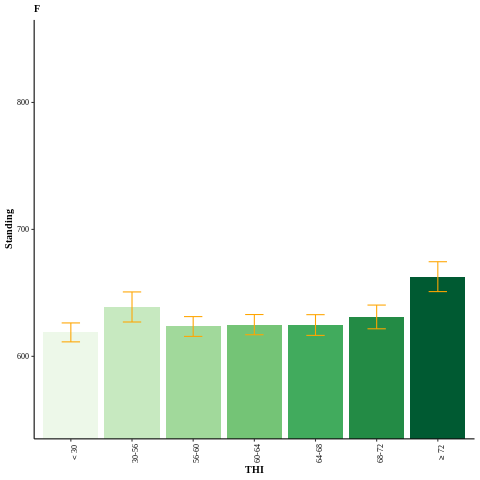

In [ ]:
%%R
finaldf<-finaldfD

finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean), stat="identity",,alpha=1)+
scale_x_discrete(labels=c(expression(""<30),"30-56","56-60","60-64","64-68","68-72",expression("">=72)))+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.3, colour="orange", alpha=1, size=0.5)
p + coord_cartesian(ylim=c(550,850))+ scale_fill_brewer(palette= "Greens")+
theme_classic()+
theme(text=element_text(size=8, family="Times New Roman"), 
      axis.title.y = element_text(color="black", size=10, family="Times New Roman", face='bold'), 
      axis.title.x = element_text(color="black", size=10, family="Times New Roman", face='bold'),
      axis.text = element_text(color="black", size=8,family="Times New Roman"),
      axis.text.x = element_text(size=8, family="Times New Roman",angle=90))+
theme(legend.position = "none")+ 
labs(x = "THI")+ labs(y = "Standing")+labs(title = "F")+ theme(plot.title = element_text(hjust = 0, size=10,face='bold'))

In [ ]:
%%R
ggsave("fig4f.tiff",
  path= '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/Figures/',     
  plot = last_plot(),
  width = 6,
  height = 6,
  units = c("cm"),
  dpi = 1000)

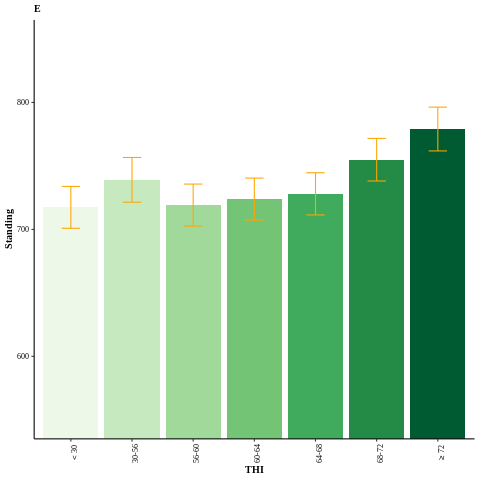

In [ ]:
%%R
finaldf<-finaldfA

finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean), stat="identity",,alpha=1)+
scale_x_discrete(labels=c(expression(""<30),"30-56","56-60","60-64","64-68","68-72",expression("">=72)))+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.3, colour="orange", alpha=1, size=0.5)
p + coord_cartesian(ylim=c(550,850))+ scale_fill_brewer(palette= "Greens")+
theme_classic()+
theme(text=element_text(size=8, family="Times New Roman"), 
      axis.title.y = element_text(color="black", size=10, family="Times New Roman", face='bold'), 
      axis.title.x = element_text(color="black", size=10, family="Times New Roman", face='bold'),
      axis.text = element_text(color="black", size=8,family="Times New Roman"),
      axis.text.x = element_text(size=8, family="Times New Roman",angle=90))+
theme(legend.position = "none")+ 
labs(x = "THI")+ labs(y = "Standing")+labs(title = "E")+ theme(plot.title = element_text(hjust = 0, size=10,face='bold'))

In [ ]:
%%R
ggsave("fig4e.tiff",
  path= '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/Figures/',     
  plot = last_plot(),
  width = 6,
  height = 6,
  units = c("cm"),
  dpi = 1000)

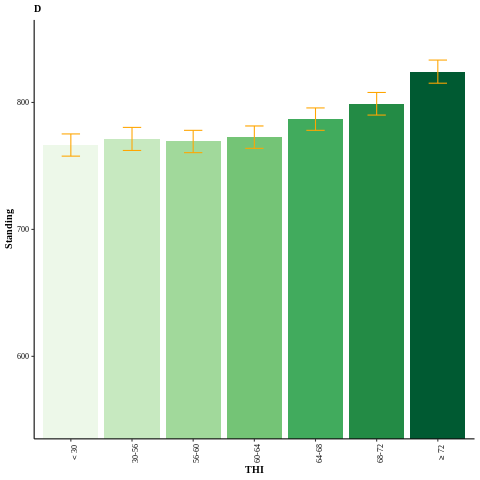

In [ ]:
%%R
finaldf<-finaldfC

finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean), stat="identity",,alpha=1)+
scale_x_discrete(labels=c(expression(""<30),"30-56","56-60","60-64","64-68","68-72",expression("">=72)))+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.3, colour="orange", alpha=1, size=0.5)
p + coord_cartesian(ylim=c(550,850))+ scale_fill_brewer(palette= "Greens")+
theme_classic()+
theme(text=element_text(size=8, family="Times New Roman"), 
      axis.title.y = element_text(color="black", size=10, family="Times New Roman", face='bold'), 
      axis.title.x = element_text(color="black", size=10, family="Times New Roman", face='bold'),
      axis.text = element_text(color="black", size=8,family="Times New Roman"),
      axis.text.x = element_text(size=8, family="Times New Roman",angle=90))+
theme(legend.position = "none")+ 
labs(x = "THI")+ labs(y = "Standing")+labs(title = "D")+ theme(plot.title = element_text(hjust = 0, size=10,face='bold'))

In [ ]:
%%R
ggsave("fig4d.tiff",
  path= '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/Figures/',     
  plot = last_plot(),
  width = 6,
  height = 6,
  units = c("cm"),
  dpi = 1000)

In [ ]:
%%R
LSMsAL<-emmeans::lsmeans(fit.1a, ~ fThiMeanCat, glhargs=list())
print(LSMsAL)

 fThiMeanCat lsmean   SE     df lower.CL upper.CL
 1              717 8.41 296569      701      734
 0              739 8.99 296569      721      757
 2              719 8.44 296569      703      736
 3              724 8.45 296569      707      740
 4              728 8.47 296569      711      745
 5              755 8.57 296569      738      772
 6              779 8.81 296569      762      796

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsCL<-emmeans::lsmeans(fit.1b, ~ fThiMeanCat, glhargs=list())
print(LSMsCL)

 fThiMeanCat lsmean   SE     df lower.CL upper.CL
 1              766 4.47 661899      758      775
 0              771 4.63 661899      762      780
 2              769 4.48 661899      760      778
 3              773 4.49 661899      764      781
 4              787 4.50 661899      778      796
 5              799 4.55 661899      790      808
 6              824 4.66 661899      815      833

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsDL<-emmeans::lsmeans(fit.1c, ~ fThiMeanCat, glhargs=list())
print(LSMsDL)

 fThiMeanCat lsmean   SE    df lower.CL upper.CL
 1              619 3.80 75732      611      626
 0              639 6.05 75732      627      651
 2              624 3.97 75732      616      631
 3              625 4.05 75732      617      633
 4              625 4.18 75732      616      633
 5              631 4.77 75732      622      640
 6              663 6.00 75732      651      675

Results are averaged over the levels of: fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


## Temperature mean figures results

In [ ]:
%%R
url_model6a <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMeanAMS.R"
model<- load(file= url_model6a)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMeanCMS.R'
model<- load(file= url_model6b)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/standing/models/ModelTempMeanDRY.R'
model<- load(file= url_model6c)

In [ ]:
%%R
##LSMs for dry cows
LSMsD<-emmeans::lsmeans(fit.6c, ~ fTempMeanCat, glhargs=list())
dfD<-LSMsD%>%
  as.data.frame()

## LSMSs for AMS
LSMsA<-emmeans::lsmeans(fit.6a, ~ fTempMeanCat, glhargs=list())
dfA<-LSMsA%>%
  as.data.frame()

## LSMs for CMS
LSMsC<-emmeans::lsmeans(fit.6b, ~ fTempMeanCat, glhargs=list())
dfC<-LSMsC%>%
  as.data.frame()

In [ ]:
%%R
TempMean<- c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28")
df1 <- data.frame(TempMean)
finaldfD<-cbind(df1,dfD)
finaldfD<- subset(finaldfD, select = -c(fTempMeanCat))
finaldfC<-cbind(df1,dfC)
finaldfC<- subset(finaldfC, select = -c(fTempMeanCat))
finaldfA<-cbind(df1,dfA)
finaldfA<- subset(finaldfA, select = -c(fTempMeanCat))


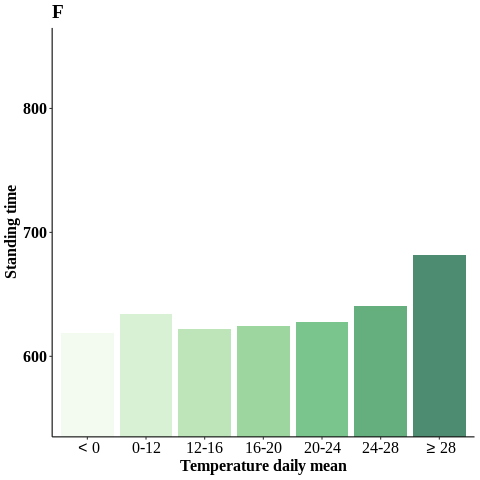

In [ ]:
%%R
finaldf<-finaldfD
finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
scale_x_discrete(labels=c(expression(""<0),"0-12","12-16","16-20","20-24","24-28",expression("">=28)))
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(550,850))+ scale_fill_brewer(palette= "Greens")+ theme(legend.position= "none")+ 
theme_classic()+
theme(text=element_text(size=16, family="Times New Roman", face='bold'), 
      axis.title.y = element_text(color="black", size=16, family="Times New Roman", face= 'bold'), 
      axis.title.x = element_text(color="black", size=16, family="Times New Roman",face= 'bold'),
      axis.text = element_text(color="black", size=16,family="Times New Roman",face= 'bold'))+
theme(legend.position = "none")+
labs(x = "Temperature daily mean")+ labs(y = "Standing time")+labs(title = "F")+ theme(plot.title = element_text(hjust = 0))


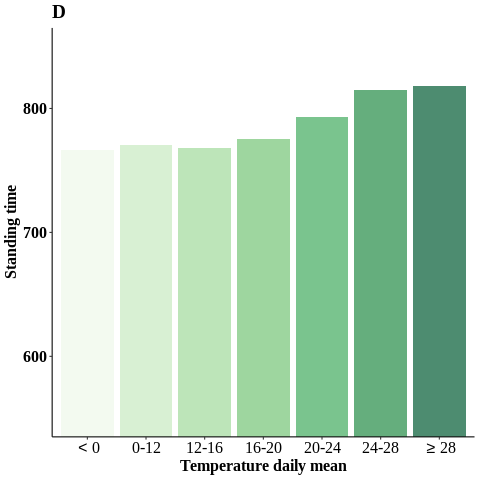

In [ ]:
%%R
finaldf<-finaldfC
finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
scale_x_discrete(labels=c(expression(""<0),"0-12","12-16","16-20","20-24","24-28",expression("">=28)))
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(550,850))+ scale_fill_brewer(palette= "Greens")+ theme(legend.position= "none")+ 
theme_classic()+
theme(text=element_text(size=16, family="Times New Roman", face='bold'), 
      axis.title.y = element_text(color="black", size=16, family="Times New Roman", face= 'bold'), 
      axis.title.x = element_text(color="black", size=16, family="Times New Roman",face= 'bold'),
      axis.text = element_text(color="black", size=16,family="Times New Roman",face= 'bold'))+
theme(legend.position = "none")+
labs(x = "Temperature daily mean")+ labs(y = "Standing time")+labs(title = "D")+ theme(plot.title = element_text(hjust = 0))


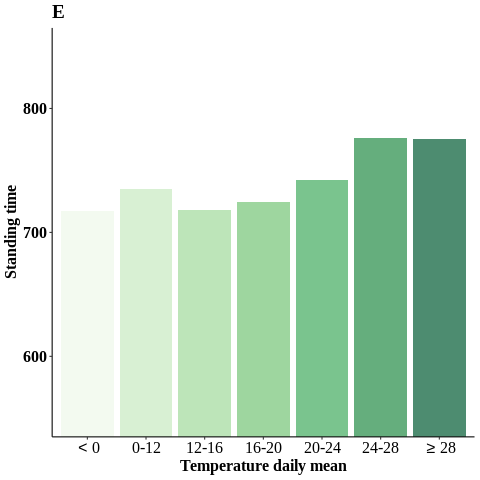

In [ ]:
%%R
finaldf<-finaldfA
finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
scale_x_discrete(labels=c(expression(""<0),"0-12","12-16","16-20","20-24","24-28",expression("">=28)))
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(550,850))+ scale_fill_brewer(palette= "Greens")+ theme(legend.position= "none")+ 
theme_classic()+
theme(text=element_text(size=16, family="Times New Roman", face='bold'), 
      axis.title.y = element_text(color="black", size=16, family="Times New Roman", face= 'bold'), 
      axis.title.x = element_text(color="black", size=16, family="Times New Roman",face= 'bold'),
      axis.text = element_text(color="black", size=16,family="Times New Roman",face= 'bold'))+
theme(legend.position = "none")+
labs(x = "Temperature daily mean")+ labs(y = "Standing time")+labs(title = "E")+ theme(plot.title = element_text(hjust = 0))


In [ ]:
%%R
LSMsAL<-emmeans::lsmeans(fit.6a, ~ fTempMeanCat, glhargs=list())
print(LSMsAL)

 fTempMeanCat lsmean   SE     df lower.CL upper.CL
 1               717 8.43 296569      701      734
 0               735 8.55 296569      718      751
 2               718 8.44 296569      701      734
 3               725 8.46 296569      708      741
 4               743 8.51 296569      726      759
 5               776 8.74 296569      759      793
 6               776 9.97 296569      756      795

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsCL<-emmeans::lsmeans(fit.6b, ~ fTempMeanCat, glhargs=list())
print(LSMsCL)

 fTempMeanCat lsmean   SE     df lower.CL upper.CL
 1               766 4.47 661899      758      775
 0               771 4.53 661899      762      780
 2               768 4.48 661899      759      777
 3               776 4.49 661899      767      784
 4               793 4.51 661899      784      802
 5               815 4.60 661899      806      824
 6               818 5.08 661899      808      828

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsDL<-emmeans::lsmeans(fit.6c, ~ fTempMeanCat, glhargs=list())
print(LSMsDL)

 fTempMeanCat lsmean   SE    df lower.CL upper.CL
 1               619 3.83 75732      611      626
 0               634 4.81 75732      625      644
 2               622 3.91 75732      614      629
 3               625 4.01 75732      617      633
 4               628 4.33 75732      619      636
 5               640 5.53 75732      629      651
 6               682 9.08 75732      664      700

Results are averaged over the levels of: fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 
